What now?

We create two tables with the following data:

# Table 1
- Based on basic data in `~/data/trd/crosses_info.csv`, we want to know 
    - number of loci with
        - TRD
        - of these
            - positive, negative outlier
                - pi
                - fst
                - dxy
                - LD
                - local phylogeny data
                - dn/ds
            - SVs
                - for each SV type, count of loci that overlap with these
            - repetitive elements
                - % region in rep. bp

# Table 2
- All individual TRD loci data, with per locus
    - percentile values for
        - pi
        - fst
        - dxy
        - LD
        - local phylogeny data
        - dn/ds
    - SVs, each type
        - % of loci overlapping with called SV
    - rep elements, each type
        - % locus


# Analysis

And then we look at 

- global distributions of values at TRD locus to find overall trends
- categorizing different types of TRD
- indivdiaul loci in detail by making RMarkdown HTMLs

In [1]:
library(tidytable)
library(ggplot2)

library(stringr)
library(tidyverse)

Warning message:
"package 'tidytable' was built under R version 4.1.3"

Attaching package: 'tidytable'


The following objects are masked from 'package:stats':

    dt, filter, lag


The following object is masked from 'package:base':

    %in%


Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'tidyverse' was built under R version 4.1.3"
-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------ tidyverse 1.3.2 --
v tibble  3.1.8     v purrr   1.0.1
v tidyr   1.3.0     v dplyr   1.1.0
v readr   2.1.3     v forcats 1.0.0
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.3"
Warning message:
"package 'readr' was built under R version 4.1.3"
Warning message:
"package 'purrr' was buil

In [2]:
# merge data from the different analyses to a per-TRD-locus table

# local phylogeny

LP_file<-"/home/jnrunge/data/trd/local_phylogenies_trd_analysis/TRD_regions_with_LP_data.csv.gz"
One_Table<-fread(LP_file)


# SVs

SV_files<-list.files("/home/jnrunge/data/trd/SV_analysis",
                    "SV_data.RDS$", full.names=TRUE)



SV_data<-data.table()
for(f in SV_files){
    SV_data<-bind_rows(SV_data, readRDS(f))
}

SV_data<-filter(SV_data, !is.na(sample))

All_TYPE_source_combinations<-select(SV_data, TYPE, source)%>%distinct()

# I am making sure that all combinations exist, even if 0 for that TRD region / sample, for comparability

for(ci in unique(paste0(pull(SV_data, cross), "_",
                     pull(SV_data, ID), "_",
                       pull(SV_data, sample)))){
   SV_data_sub<-filter(SV_data, paste0(cross,"_",ID,"_",sample)==ci)
   
   SV_data_sub_TYPE_source<-select(SV_data_sub, TYPE, source)%>%distinct()
   missing_TYPE_source<-anti_join(All_TYPE_source_combinations, SV_data_sub_TYPE_source)
   
   new_rows<-mutate(missing_TYPE_source, cross=strsplit(ci,"_",fixed=TRUE)[[1]][1],
                   ID=strsplit(ci,"_",fixed=TRUE)[[1]][2],
                    sample=strsplit(ci,"_",fixed=TRUE)[[1]][3], LEN_rel=0)
       SV_data<-mutate(SV_data, ID=as.character(ID))

   SV_data<-bind_rows(SV_data, new_rows)
      
}


SV_data_summary<-SV_data%>%filter(!is.na(TYPE))%>%
group_by(cross,ID,TYPE,source, sample)%>%summarize(sum_LEN_rel=sum(LEN_rel))

head(SV_data_summary)

Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, source)`
Joining with `by = join_by(TYPE, s

cross,ID,TYPE,source,sample,sum_LEN_rel
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
ChrisC1,1,CONTR,VictorSV,ACP,0
ChrisC1,1,CONTR,VictorSV,BFP,0
ChrisC1,1,DEL,VictorSV,ACP,0
ChrisC1,1,DEL,VictorSV,BFP,0
ChrisC1,1,DUP,VictorSV,ACP,0
ChrisC1,1,DUP,VictorSV,BFP,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


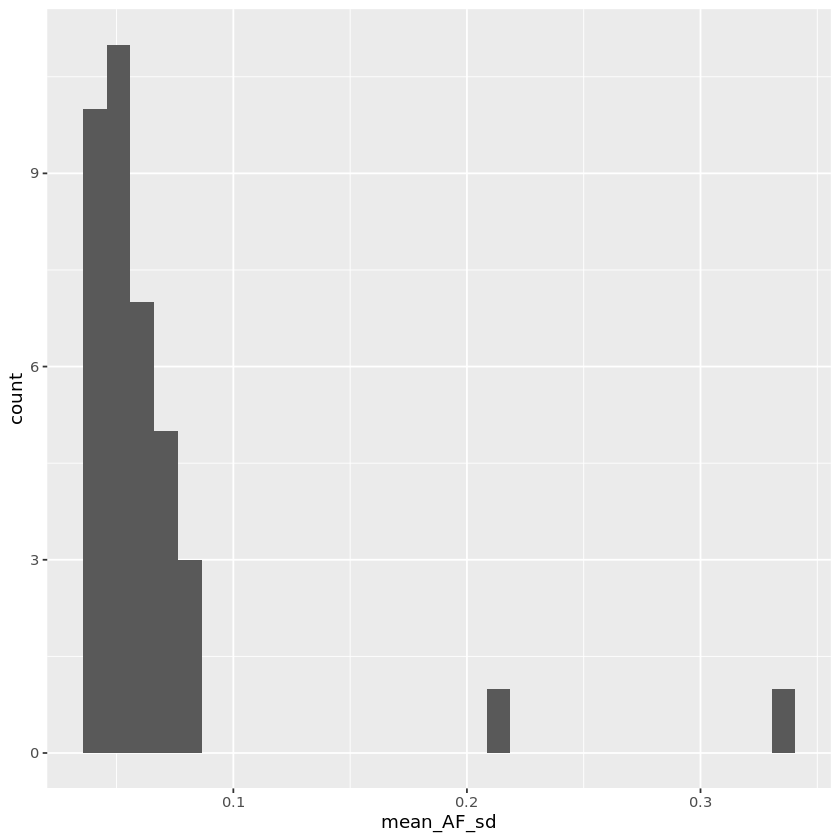

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


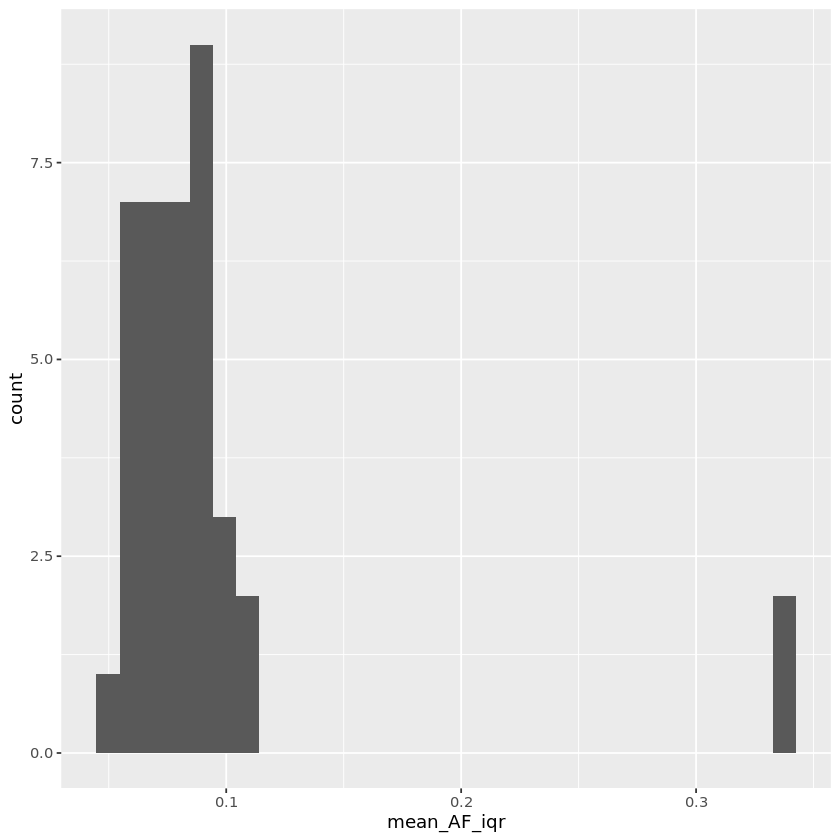

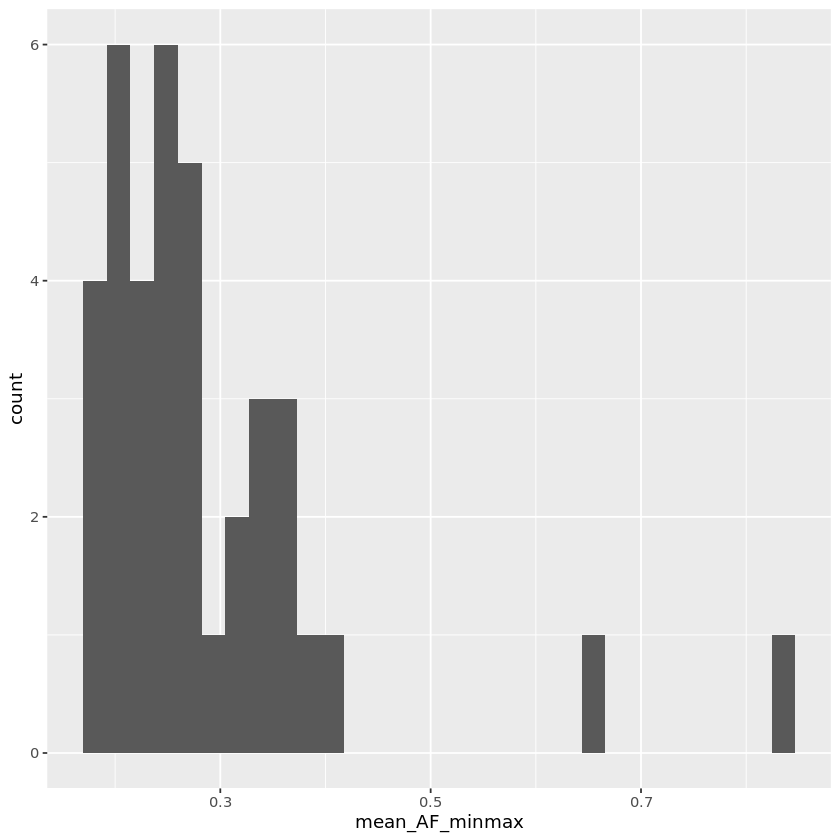

In [3]:
# how noisy is the data? this can be used to exclude crosses from further analyses
# should maybe be earlier in the pipeline...


# Sliding window function
compute_sd <- function(start, vec, window_size) {
  end <- start + window_size - 1
  if (end > length(vec)) return(NA)  # Return NA if window goes beyond vector length
  return(sd(vec[start:end], na.rm=TRUE))
}
compute_IQR <- function(start, vec, window_size) {
  end <- start + window_size - 1
  if (end > length(vec)) return(NA)  # Return NA if window goes beyond vector length
  return(IQR(vec[start:end], na.rm=TRUE))
}
compute_MinMax <- function(start, vec, window_size) {
  end <- start + window_size - 1
  if (end > length(vec)) return(NA)  # Return NA if window goes beyond vector length
  return(max(vec[start:end], na.rm=TRUE)-min(vec[start:end], na.rm=TRUE))
}
# Apply sliding window function
window_size <- 1000
step <- 10

AF_files<-list.files("/home/jnrunge/data/TRD/results/shiny","-AF.csv.gz$", full.names = TRUE)

AF_noisyness_df<-data.table()

for(i in 1:length(AF_files)){
    AF<-fread(AF_files[i])
    cross<-strsplit(basename(AF_files[i]),"-",fixed=TRUE)[[1]][1]
    cross

    AF<-mutate(AF, AF=AD_A1/sumCount)%>%pull(AF)


    results <- map_dbl(seq(1, length(AF), by = step), compute_sd, vec = AF, window_size = window_size)
    results2 <- map_dbl(seq(1, length(AF), by = step), compute_IQR, vec = AF, window_size = window_size)
    results3 <- map_dbl(seq(1, length(AF), by = step), compute_MinMax, vec = AF, window_size = window_size)

    # Remove NAs from the results
    results <- results[!is.na(results)]

    AF_noisyness_df<-bind_rows(AF_noisyness_df, data.table(cross=cross, mean_AF_sd=mean(results, na.rm=TRUE),
                                                          mean_AF_iqr=mean(results2, na.rm=TRUE),
                                                          mean_AF_minmax=mean(results3, na.rm=TRUE)))
}

ggplot(AF_noisyness_df, aes(mean_AF_sd))+
geom_histogram()
ggplot(AF_noisyness_df, aes(mean_AF_iqr))+
geom_histogram()
ggplot(AF_noisyness_df, aes(mean_AF_minmax))+
geom_histogram()

In [4]:
# the noisyness algorithms do not really help me get a result that makes visual sense, so I will just exclude crosses based on visual deduction

excluded_crosses<-c("YJNRC29","YJNRC30","YJNRC31","YJNRC32","YJNRC4","YJNRC9")
One_Table<-filter(One_Table, !(cross %in% excluded_crosses))

In [5]:
get_and_plot_AF=function(OT_slice, plot=TRUE){
    AF_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",pull(OT_slice, cross),"-AF.csv.gz")
    AF<-fread(AF_file)
    extended_by<-200000
    AF_extended<-filter(AF, chr==pull(OT_slice,chr) & global_pos >= (pull(OT_slice, global_start)-extended_by) & global_pos <= (pull(OT_slice, global_end)+extended_by))
    
    # make sure the model is centered (0) at the midpoint for ideal fitting (?) or most comparable fitting between loci
    mid <- (pull(OT_slice, global_start) + pull(OT_slice, global_end)) / 2

    
    AF_extended <- AF_extended %>%
      mutate(diff = abs(global_pos - mid)) %>%     # Compute absolute difference for each row
      mutate(midpoint = ifelse(diff == min(diff), TRUE, FALSE)) %>%  # Set midpoint column
      select(-diff)                               # Remove the temporary difference column

    AF<-filter(AF, chr==pull(OT_slice,chr) & global_pos >= pull(OT_slice, global_start) & global_pos <= pull(OT_slice, global_end))
    AF_values<-pull(AF,AD_A1)/pull(AF,sumCount)
    AF_value<-mean(AF_values)
    
    # peak AF
    AF_values_peak<-AF_values[abs(AF_values-0.5)>quantile(abs(AF_values-0.5), 0.8)]
    AF_value_peak<-mean(AF_values_peak)
    
    
    AF_values_extended<-pull(AF_extended,AD_A1)/pull(AF_extended,sumCount)
    
    # standardized positioning for comparable model fits
    
    AF_positions<-(1:length(AF_values_extended))/length(AF_values_extended)
    # correct so that 0 is where the midpoint is
    AF_positions_zero<-which(pull(AF_extended, midpoint))
    AF_positions<-AF_positions-AF_positions[AF_positions_zero]
    
    AF_here<-data.table(pos=AF_positions, AF=AF_values_extended)
    summary(AF_lm<-lm(AF~poly(pos,2),AF_here))
    AF_lm_poly1<-lm(AF~pos, AF_here)
    AF_here<-mutate(AF_here,predict=predict(AF_lm))
    
    if(plot==TRUE){
        return(ggplot(AF_here, aes(pos, AF))+
            geom_point()+geom_line(aes(pos,predict))+ggtitle(paste(pull(OT_slice, cross),
                                                          pull(OT_slice, ID))))
    }
    
    return(list(AF_value,
               AF_lm, AF_lm_poly1, anova(AF_lm_poly1,AF_lm),AF_value_peak))
}

In [6]:
summary(get_and_plot_AF(filter(One_Table, paste(cross, ID)=="ChrisC1 9"), FALSE)[[2]]$residuals)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1545924 -0.0461782  0.0003621  0.0000000  0.0450761  0.1493456 

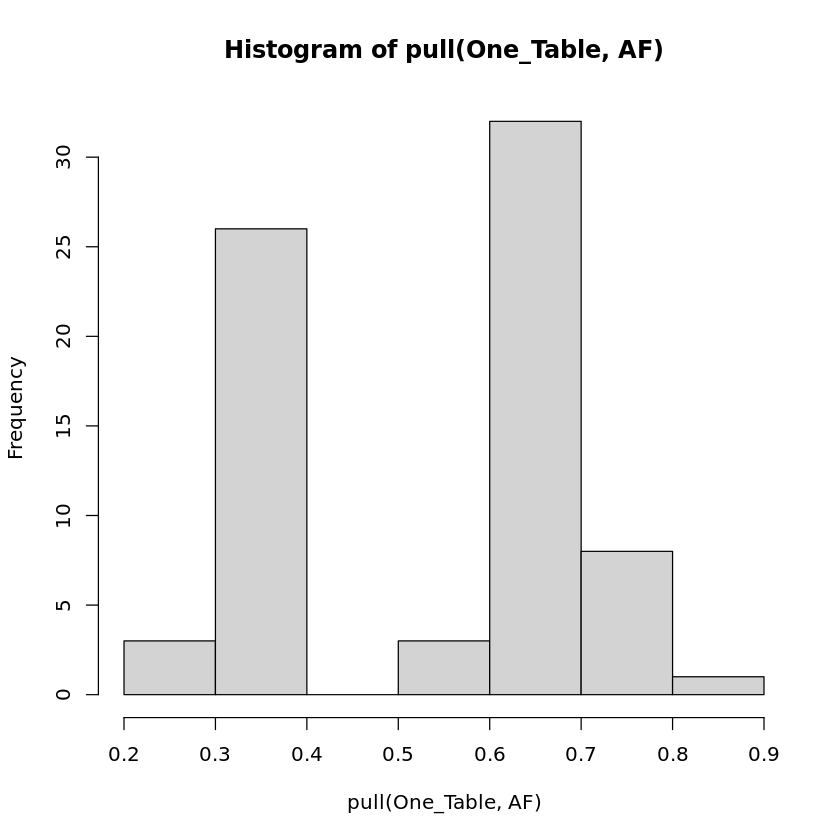

In [7]:
# I will also exclude TRD that do not rise and fall or that span entire chromosomes


# &

# we need to know which direction the distortion is and how strong it is
# to distinguish different cases

# just add AF to all TRD regions

# and lm stats

One_Table<-mutate(One_Table, AF=NA, AF_peak=NA, AF_lm_int=NA, AF_lm_poly1=NA, AF_lm_poly2=NA, AF_lm_r2=NA, AF_lm_anova=NA, AF_lm_anova_RSS=NA, AF_lm_poly1_1=NA,
                 AF_lm_resid_median=NA)

for(i in 1:nrow(One_Table)){
    OT_slice<-slice(One_Table, i)
    AF_values<-get_and_plot_AF(OT_slice,FALSE)
    AF_value<-AF_values[[1]]
    AF_lm<-AF_values[[2]]
    AF_lm_p1<-AF_values[[3]]
    AF_lm_anova_val<-AF_values[[4]]
    AF_value_peak<-AF_values[[5]]
    
    One_Table<-mutate(One_Table, AF=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),
                                           AF_value, AF), AF_peak=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),
                                           AF_value_peak, AF_peak),
                     AF_lm_int=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm$coefficients[1],
                              AF_lm_int),
                     AF_lm_poly1=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm$coefficients[2],
                              AF_lm_poly1),
                     AF_lm_poly2=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm$coefficients[3],
                              AF_lm_poly2),
                      AF_lm_r2=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),summary(AF_lm)$r.squared,
                              AF_lm_r2),
                      AF_lm_resid_median=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),median(AF_lm$residuals),
                              AF_lm_resid_median),
                      AF_lm_anova=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm_anova_val$`Pr(>F)`[2],
                              AF_lm_anova),
                                        AF_lm_anova_RSS=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm_anova_val$`Sum of Sq`[2],
                              AF_lm_anova_RSS),
                      AF_lm_poly1_1=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm_p1$coefficients[2],
                              AF_lm_poly1_1)
                     )
}

hist(pull(One_Table, AF))

One_Table<-mutate(One_Table, Distorter=ifelse(AF>0.5,"1","2"))

In [8]:
select(One_Table, AF, AF_peak)

AF,AF_peak
<dbl>,<dbl>
0.3594302,0.2749362
0.6273687,0.6992257
0.3207525,0.1957798
0.3735331,0.2917361
0.7023946,0.8326486
0.3508972,0.2796522
0.2347472,0.1754774
0.2654709,0.1601890
0.6678352,0.7508860


In [9]:
# this was an initial set of visually inferred TRD loci

bad_TRD_visual_inference<-c("ChrisC4 2","YJNRC12 1","YJNRC12 2",
                            "YJNRC17 8", "YJNRC21 3", "YJNRC24 3",
                            "YJNRC24 4", "YJNRC24 5", "YJNRC24 6",
                            "YJNRC7 4", "YJNRC8 7")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


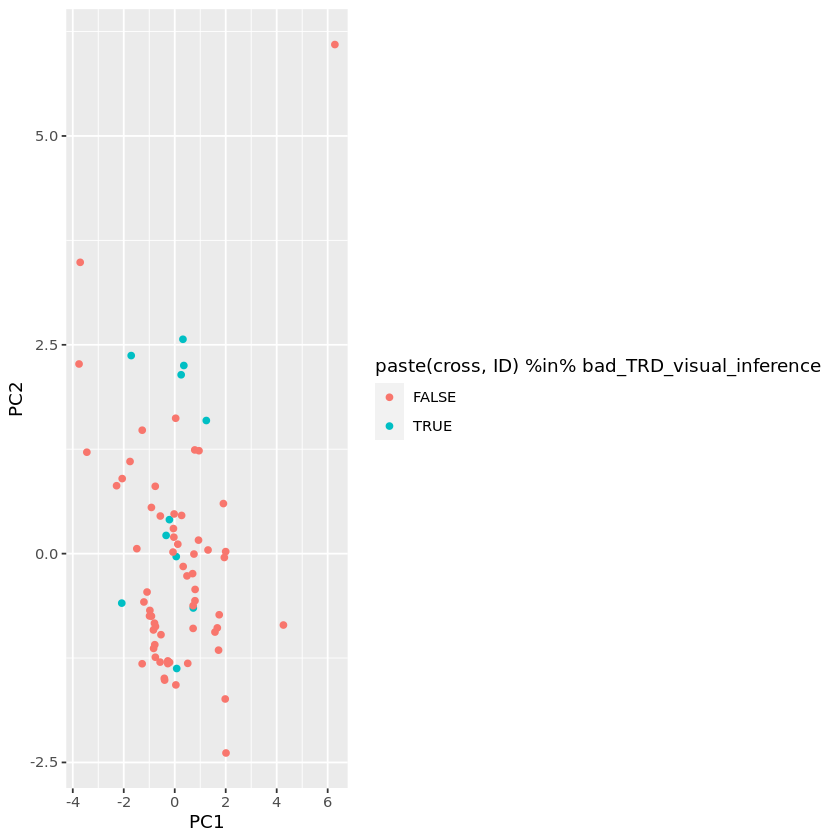

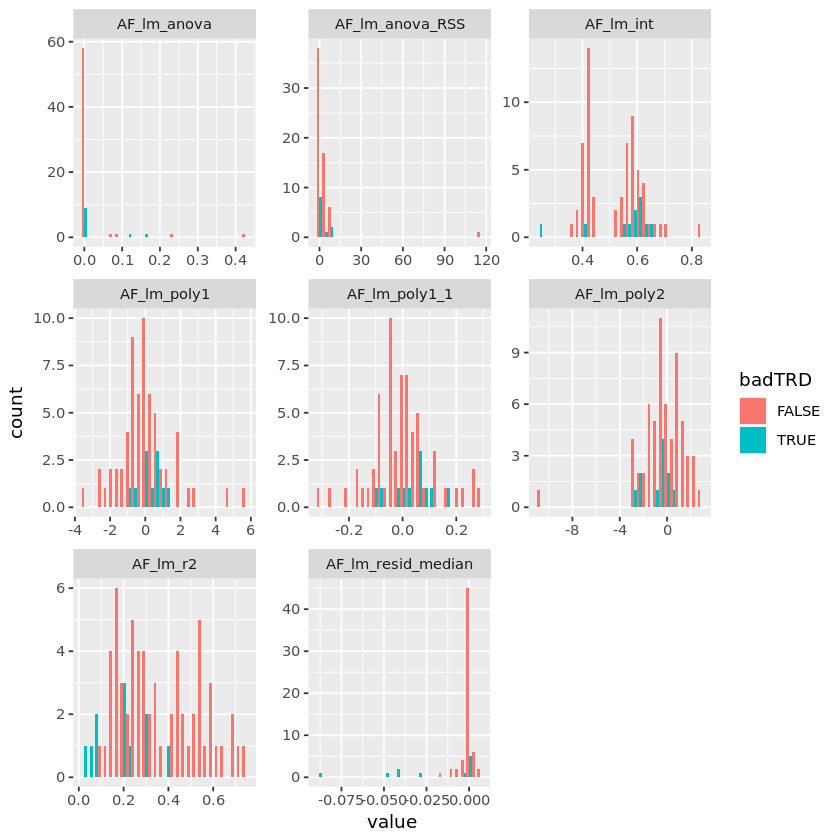

In [10]:
# I am trying to find some commonality among "bad" TRD regions to find more like them, but 
# decided to abandon this as it became a senseless timesink.

AF_lm_PCA<-prcomp(select(One_Table, AF_lm_int, AF_lm_poly1, AF_lm_poly2, AF_lm_r2, AF_lm_anova,
                        AF_lm_anova_RSS,AF_lm_resid_median,
                        AF_lm_poly1_1)%>%mutate(AF_lm_int=as.numeric(scale(AF_lm_int)),
                                                                                           AF_lm_poly1=as.numeric(scale(AF_lm_poly1)),
                                                                                           AF_lm_poly2=as.numeric(scale(AF_lm_poly2)),
                                                                                           AF_lm_r2=as.numeric(scale(AF_lm_r2)),
                                                                                            AF_lm_anova_RSS=as.numeric(scale(AF_lm_anova_RSS)),
                                                                                            AF_lm_anova=as.numeric(scale(AF_lm_anova)),
                                                AF_lm_resid_median=as.numeric(scale(AF_lm_resid_median)),
                                               AF_lm_poly1_1=as.numeric(scale(AF_lm_poly1_1))))$x
AF_lm_PCA<-as.data.frame(AF_lm_PCA)
ggplot(bind_cols(One_Table,AF_lm_PCA), aes(PC1, PC2,
                                          color=paste(cross, ID)%in%bad_TRD_visual_inference))+
geom_point()

ggplot(pivot_longer(mutate(One_Table, badTRD=paste(cross, ID)%in%bad_TRD_visual_inference),
                    c(AF_lm_int, AF_lm_poly1, AF_lm_poly2, AF_lm_r2,AF_lm_anova, AF_lm_anova_RSS, AF_lm_poly1_1,AF_lm_resid_median)),
       aes(value, fill=badTRD))+facet_wrap(~name, scales="free")+
       geom_histogram(position="dodge")

In [11]:
# filter out bad TRD loci

# to do this, I ended up defining a few different cases and removing those

One_Table<-mutate(One_Table, polynomial_filtered_out=FALSE) # TRUE == remove

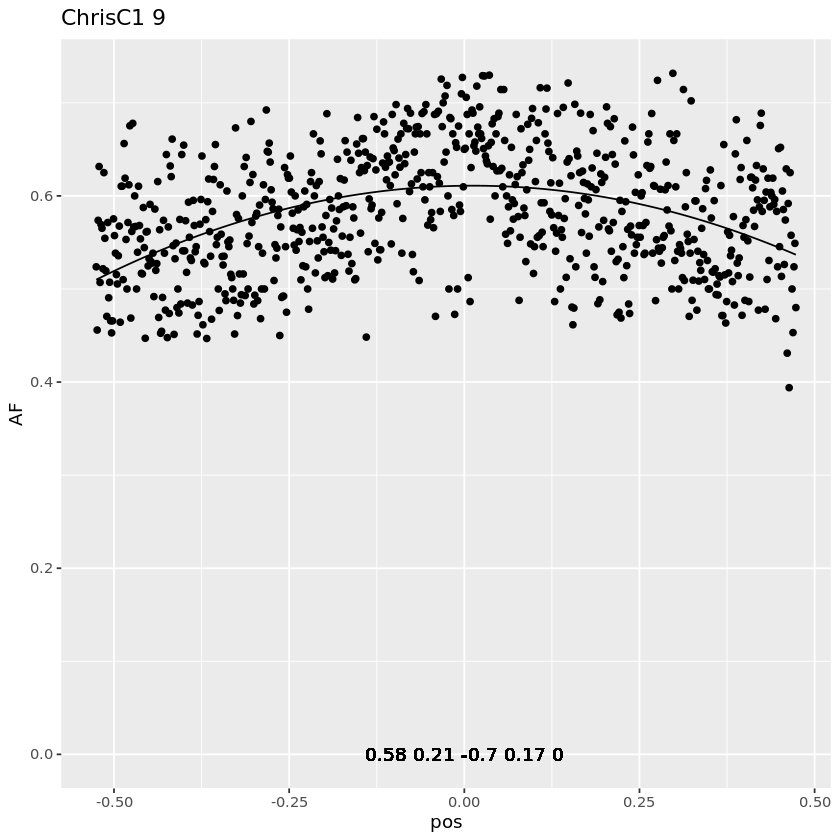

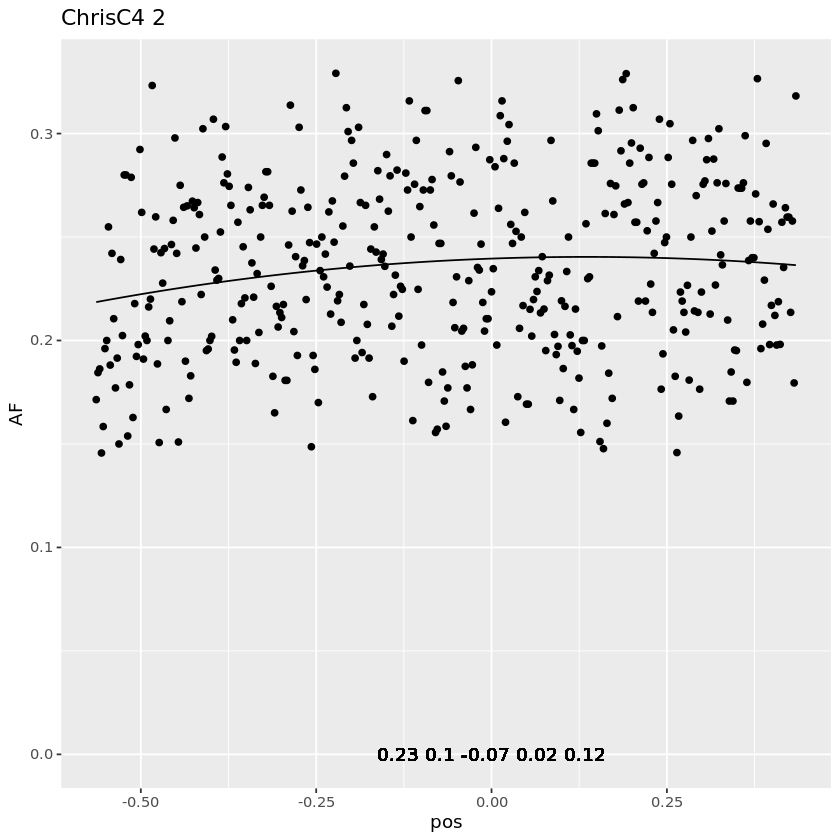

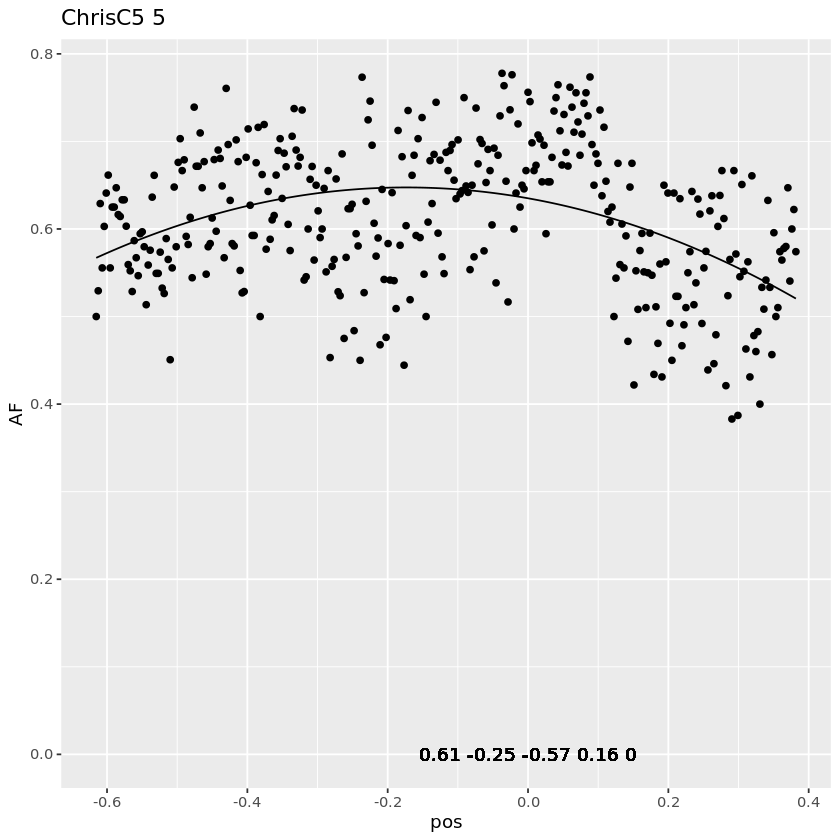

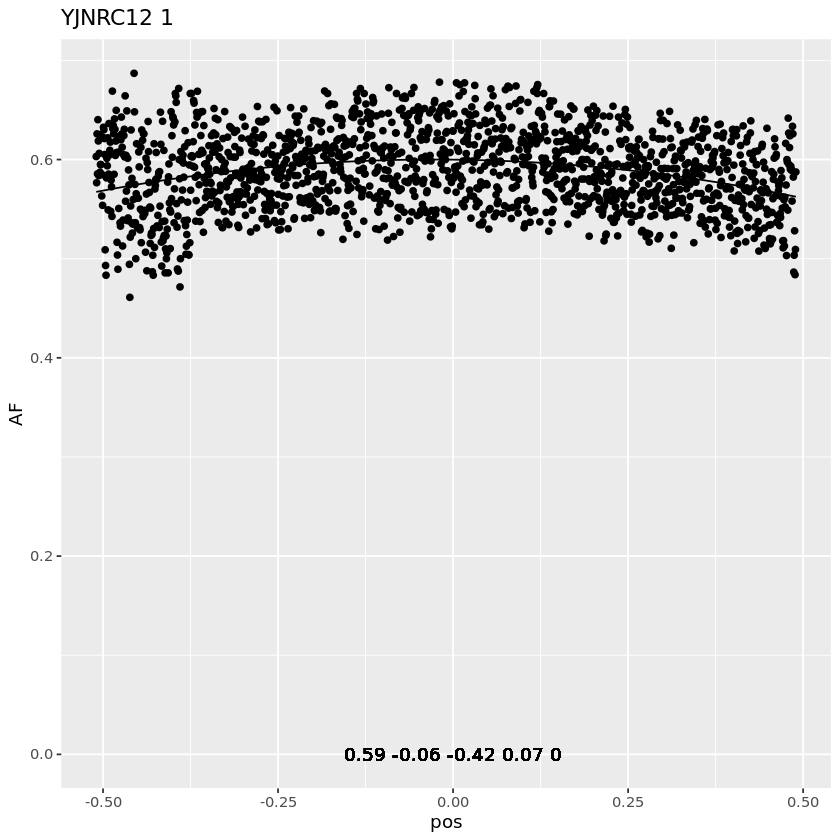

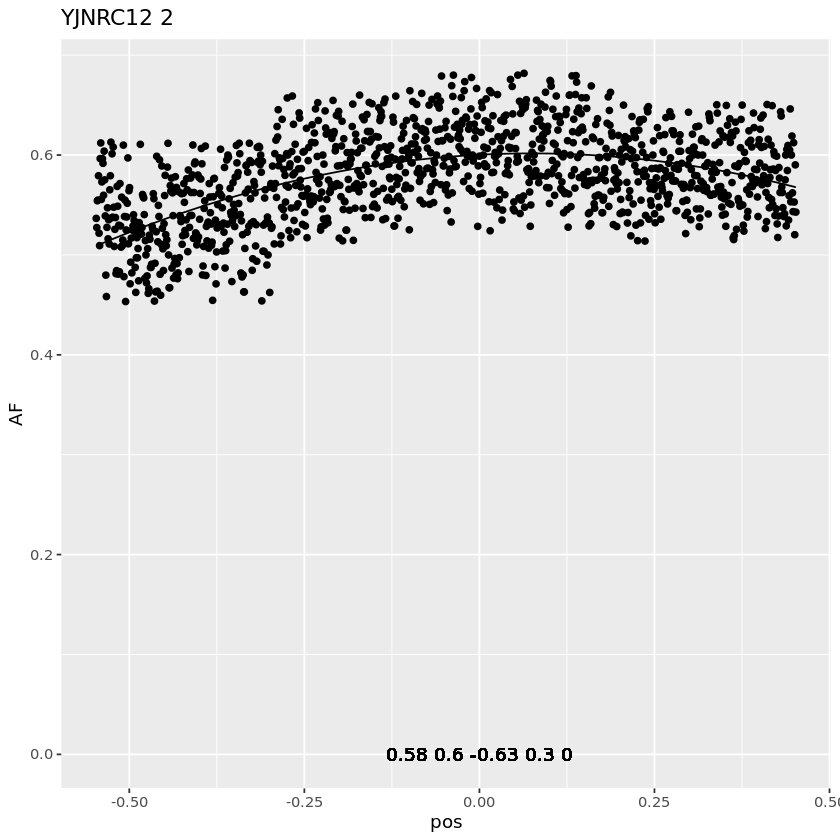

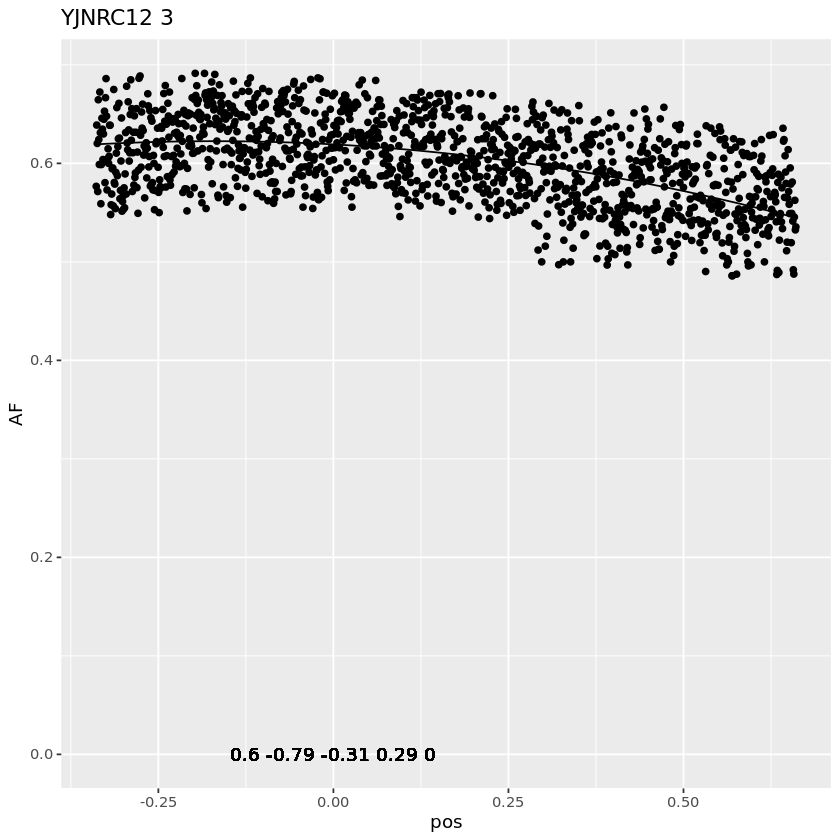

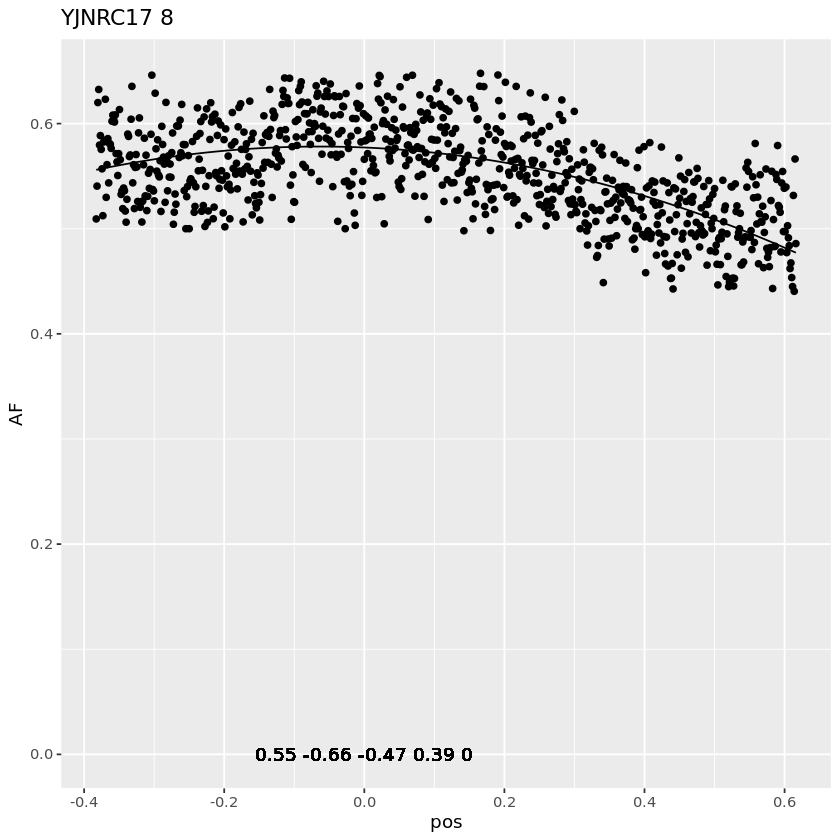

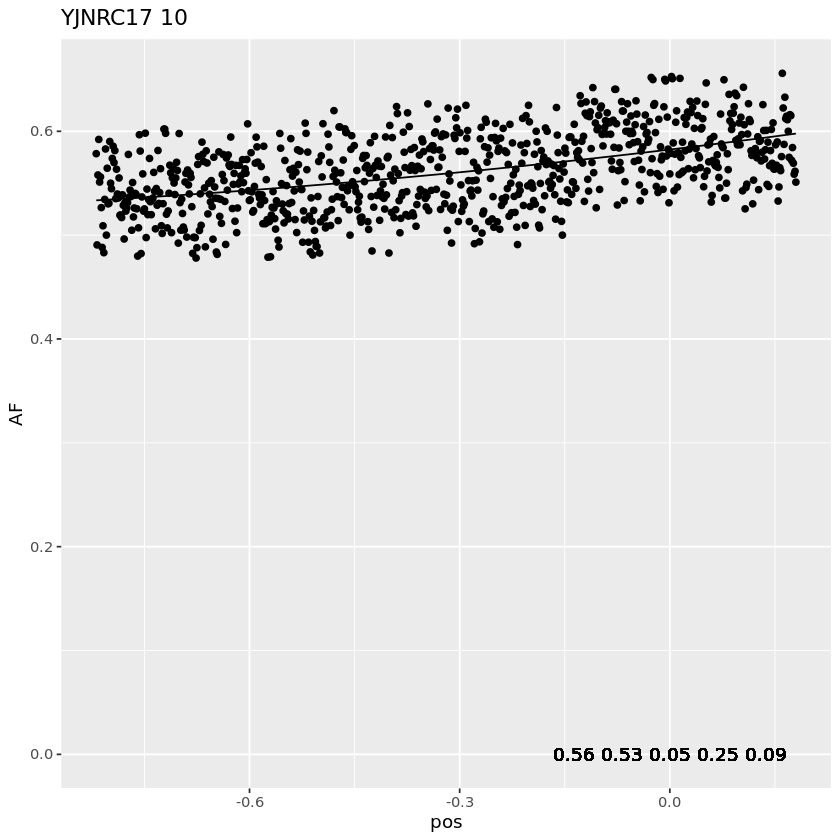

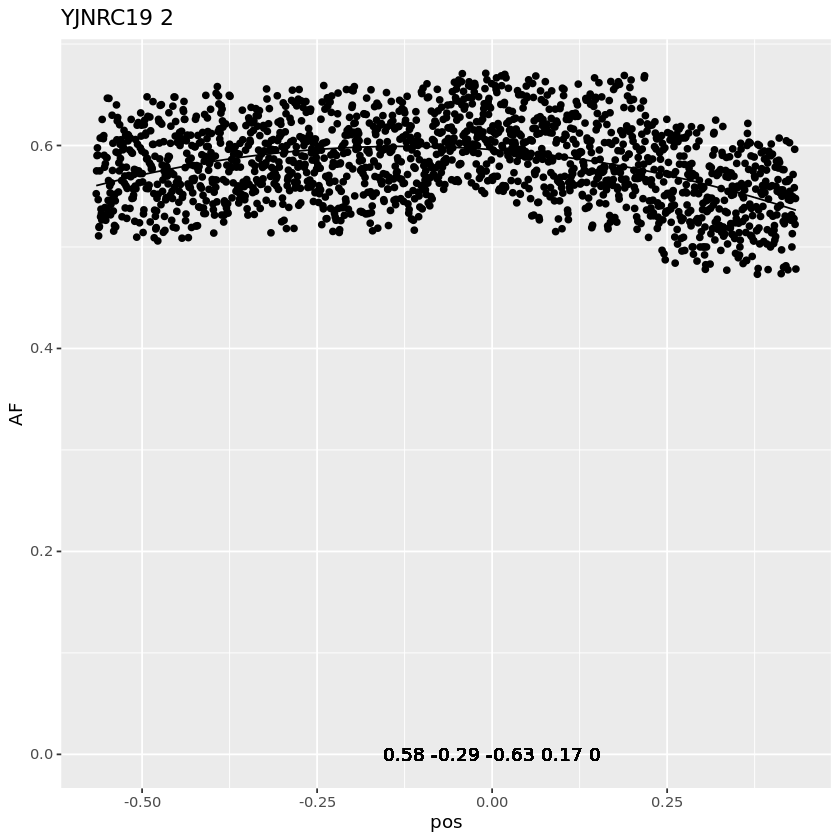

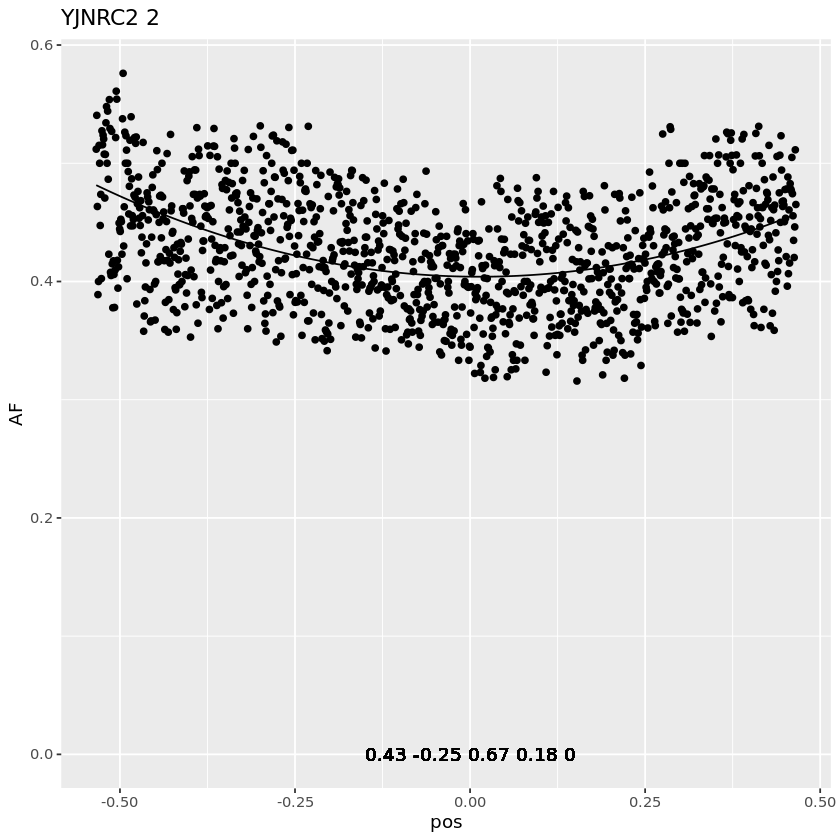

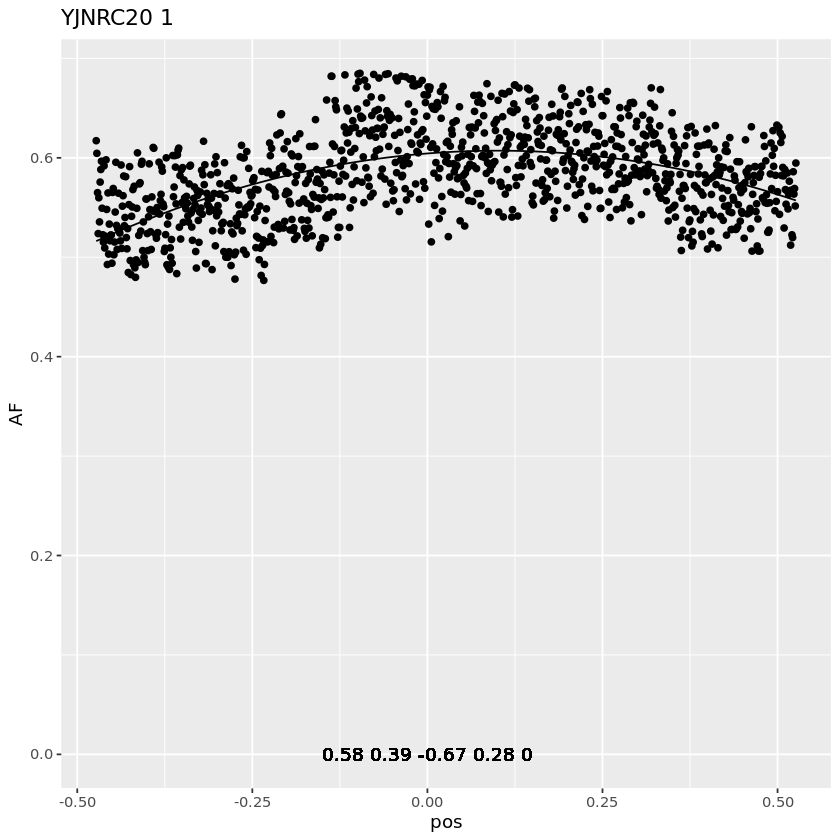

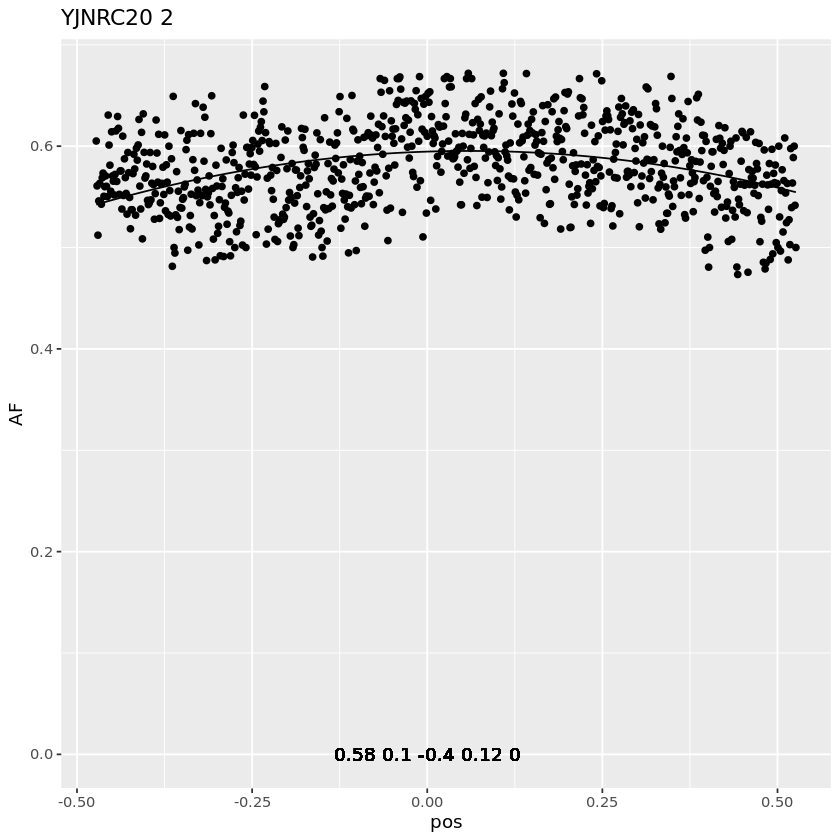

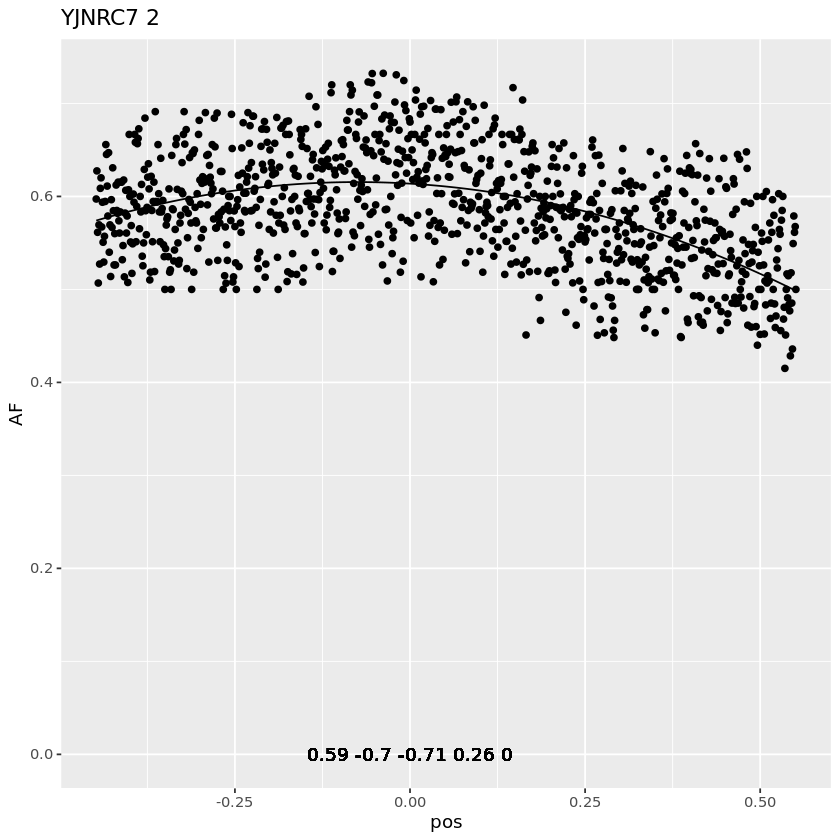

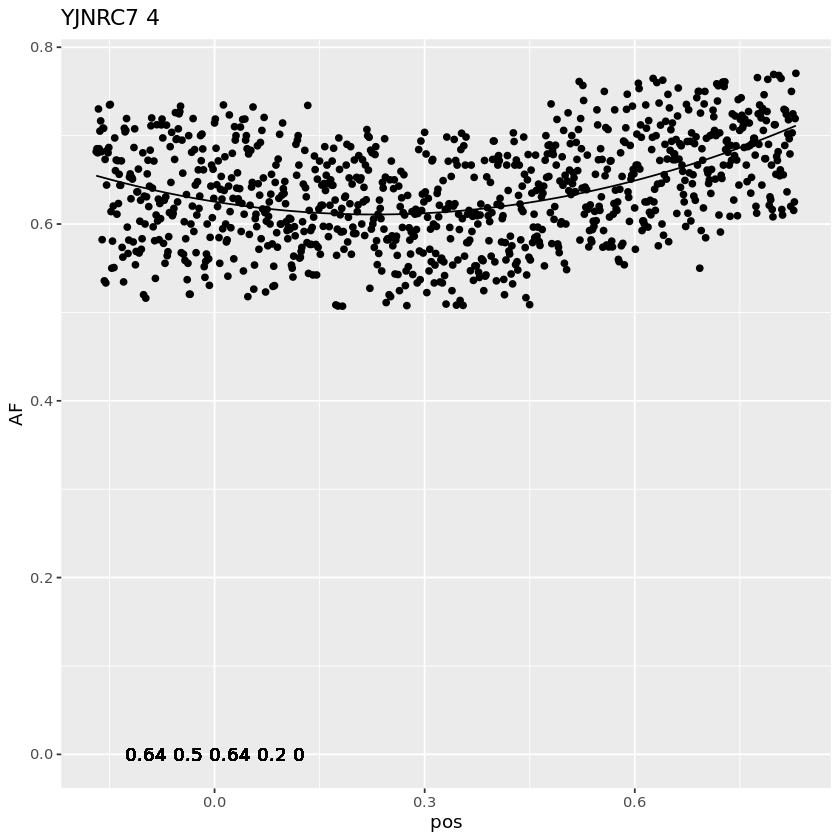

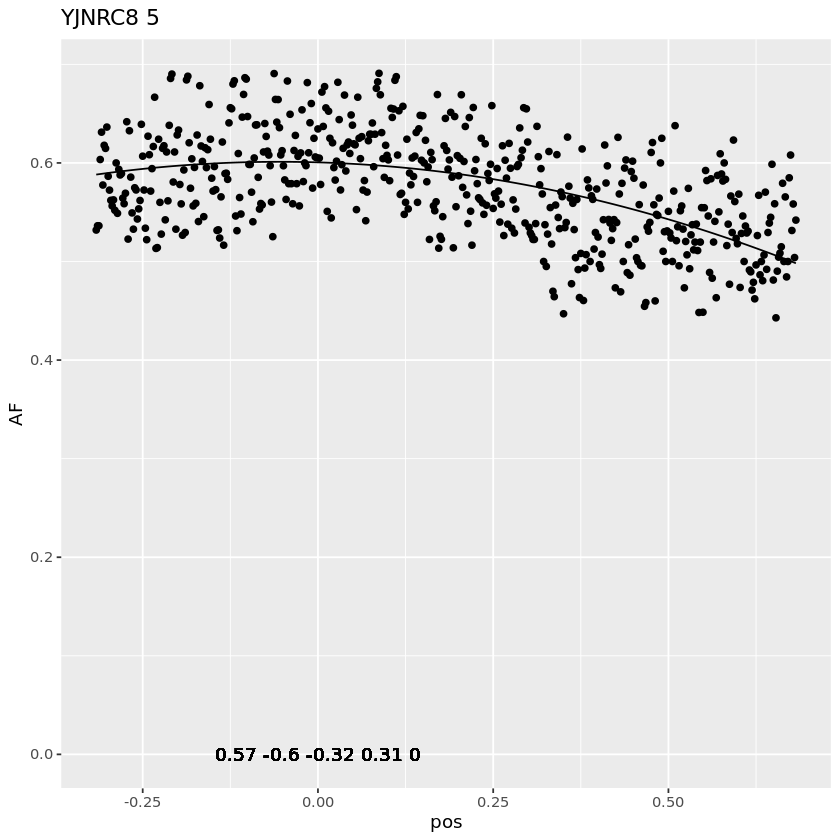

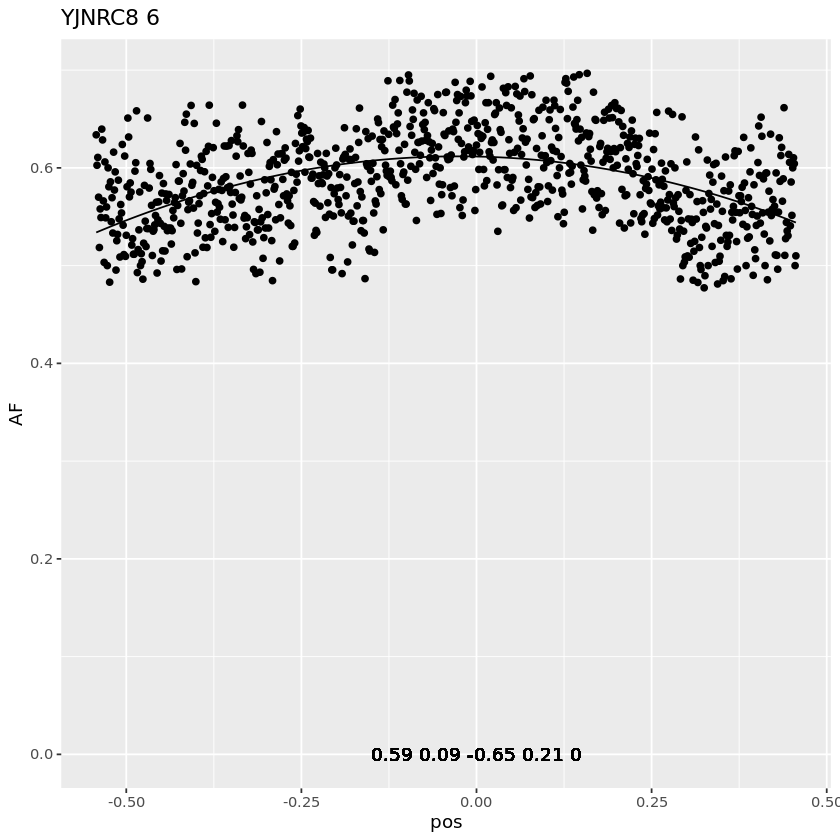

In [12]:
# flat regions

val<-0.8

for(i in which(abs(pull(One_Table, AF_lm_poly1_1))<val&
              abs(pull(One_Table, AF_lm_poly1))<val&
              abs(pull(One_Table, AF_lm_poly2))<val)){
    
    One_Table<-mutate(One_Table, polynomial_filtered_out=ifelse(row_number()==i, TRUE, polynomial_filtered_out))
    
    print(get_and_plot_AF(slice(One_Table,i))+geom_text(mapping=aes(0,0,label=paste(round(pull(slice(One_Table,i), AF_lm_int),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_poly1),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_poly2),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_r2),2),
                                                                                   round(pull(slice(One_Table,i), AF_lm_anova),2)))))
}

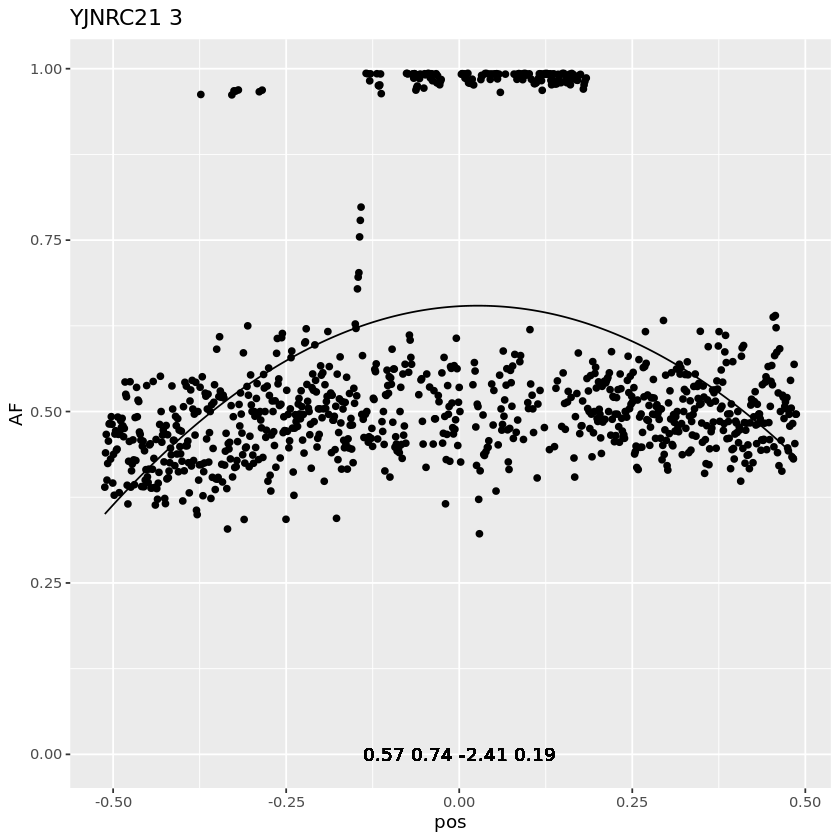

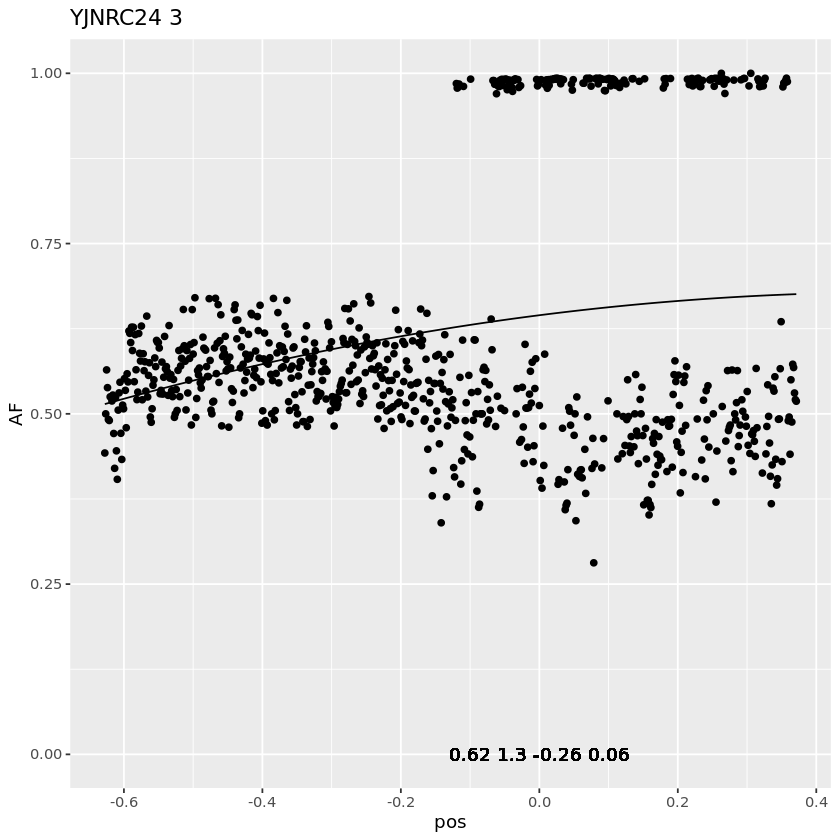

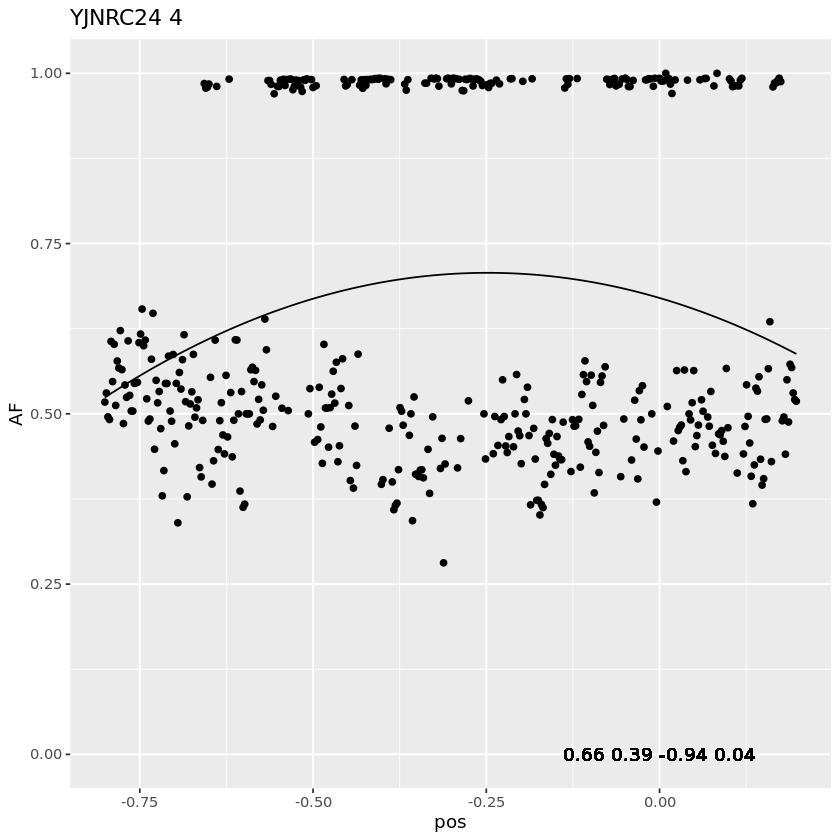

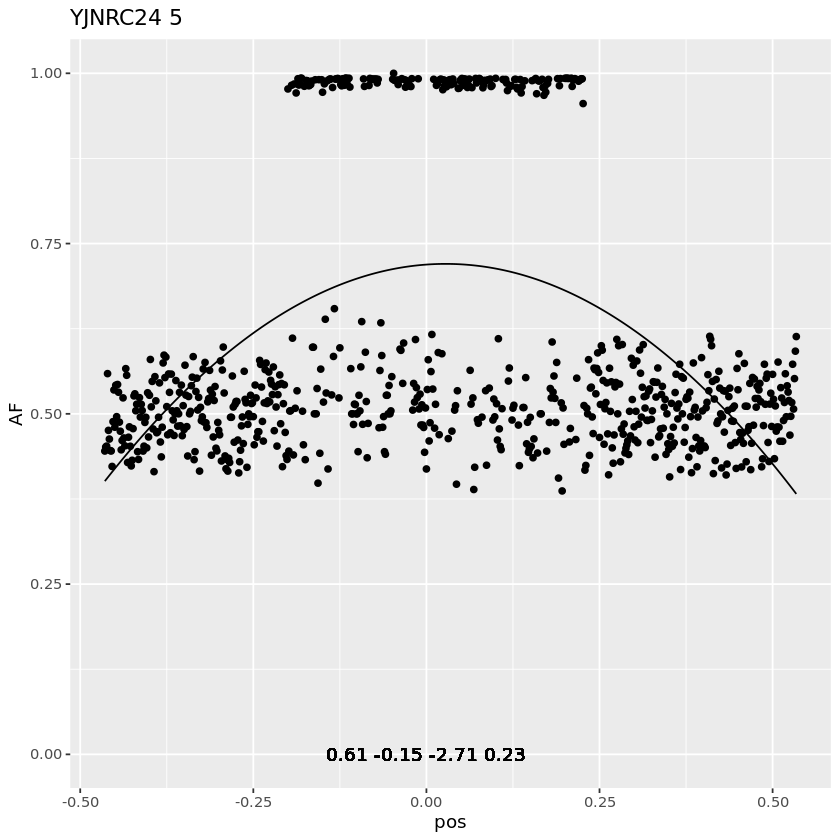

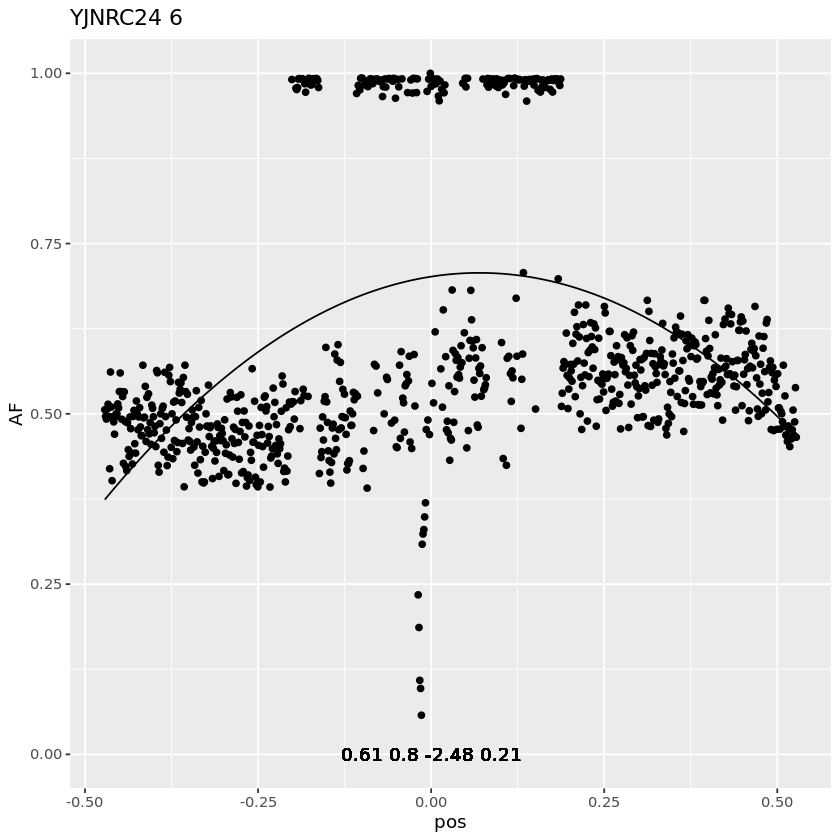

In [13]:
# bad fit

for(i in which(abs(pull(One_Table, AF_lm_resid_median))>0.02)){
    One_Table<-mutate(One_Table, polynomial_filtered_out=ifelse(row_number()==i, TRUE, polynomial_filtered_out))
    print(get_and_plot_AF(slice(One_Table,i))+geom_text(mapping=aes(0,0,label=paste(round(pull(slice(One_Table,i), AF_lm_int),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_poly1),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_poly2),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_r2),2)))))
}

`summarise()` has grouped output by 'polynomial_filtered_out'. You can override using the `.groups` argument.


polynomial_filtered_out,bad_viz_inf,n
<lgl>,<lgl>,<int>
FALSE,FALSE,51
FALSE,TRUE,1
TRUE,FALSE,11
TRUE,TRUE,10


ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,...,AF_lm_poly1,AF_lm_poly2,AF_lm_r2,AF_lm_anova,AF_lm_anova_RSS,AF_lm_poly1_1,AF_lm_resid_median,Distorter,polynomial_filtered_out,bad_viz_inf
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
7,115,chromosome15,10192979,10244627,51648,YJNRC8,273227,324875,0.853775,...,-0.8429246,0.1795785,0.2863155,0.0001137534,0.03224844,-0.0992249,-0.002680573,2,FALSE,TRUE


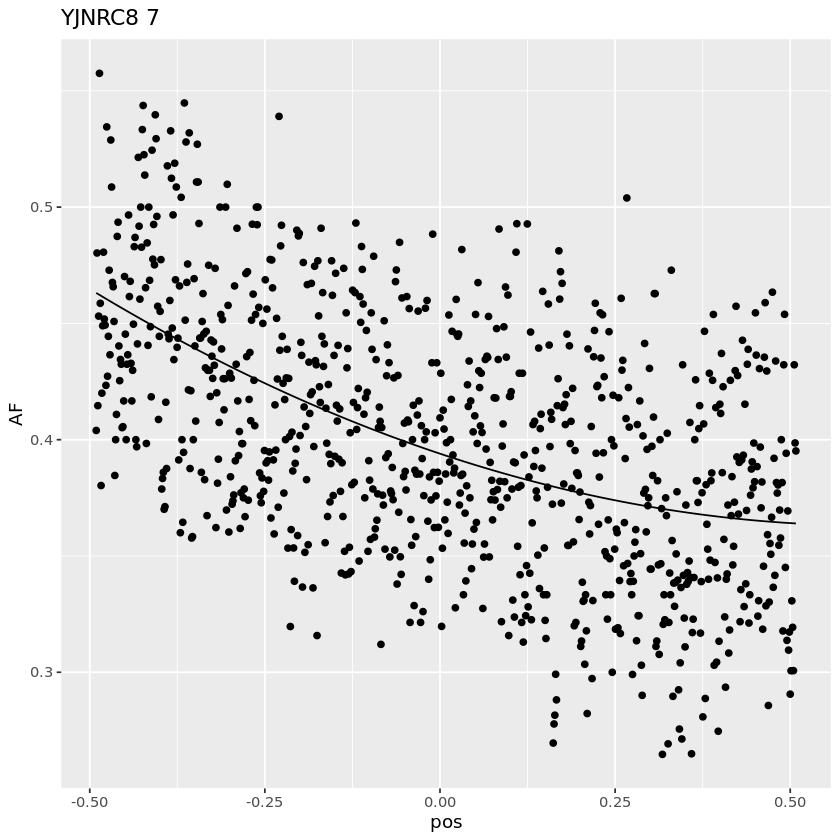

In [14]:
# is there any visually bad TRD region that is not filtered out by the two definitions above?

# yes at the moment there is one, but it looks fine actually, so I only use the new filtering from above

summarize(group_by(One_Table<-One_Table%>%mutate(bad_viz_inf=paste(cross, ID)%in%bad_TRD_visual_inference), polynomial_filtered_out, bad_viz_inf),
          n=n())

filter(One_Table, bad_viz_inf==TRUE & polynomial_filtered_out==FALSE)

get_and_plot_AF(filter(One_Table, bad_viz_inf==TRUE & polynomial_filtered_out==FALSE))

In [15]:
One_Table<-filter(One_Table, polynomial_filtered_out==FALSE)

In [16]:
# before looking at data, make sure to respect the filtering
SV_data_summary<-filter(SV_data_summary, paste(cross,ID)%in% paste(pull(One_Table, cross), pull(One_Table, ID)))

In [17]:
SV_data_summary_parent_v_parent<-SV_data_summary%>%group_by(cross,ID,TYPE)%>%summarize(LEN_rel_diff_abs=abs(sum_LEN_rel[1]-sum_LEN_rel[2]))
head(SV_data_summary_parent_v_parent)
filter(SV_data_summary_parent_v_parent, is.na(LEN_rel_diff_abs))

`summarise()` has grouped output by 'cross', 'ID'. You can override using the `.groups` argument.


cross,ID,TYPE,LEN_rel_diff_abs
<chr>,<chr>,<chr>,<dbl>
ChrisC1,1,CONTR,0
ChrisC1,1,DEL,0
ChrisC1,1,DUP,0
ChrisC1,1,INS,0
ChrisC1,1,INV,0
ChrisC1,1,TRA,0


cross,ID,TYPE,LEN_rel_diff_abs
<chr>,<chr>,<chr>,<dbl>


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


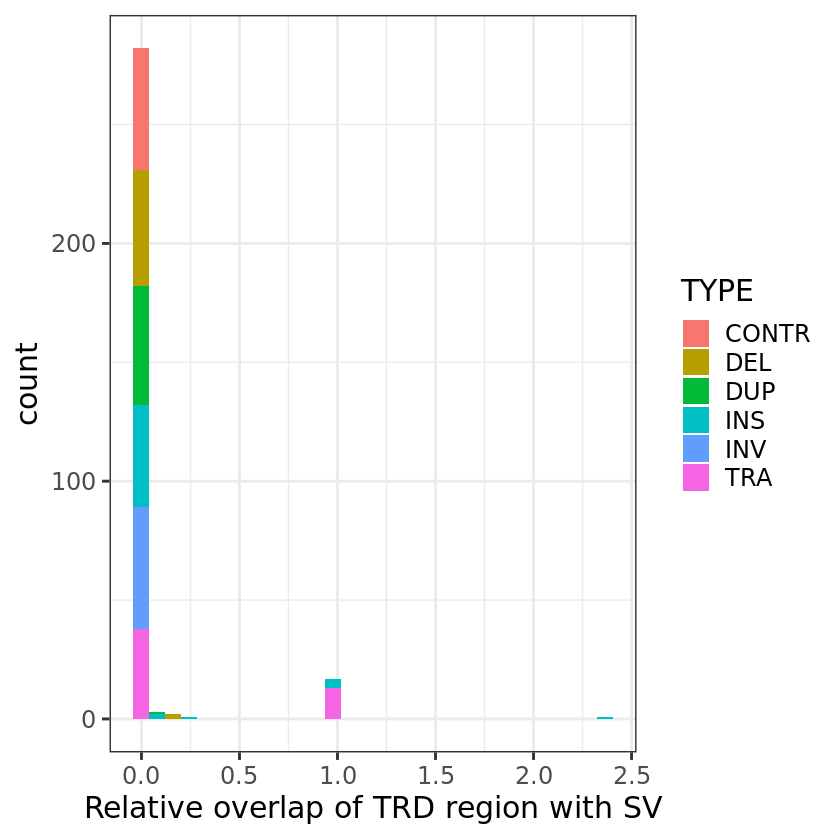

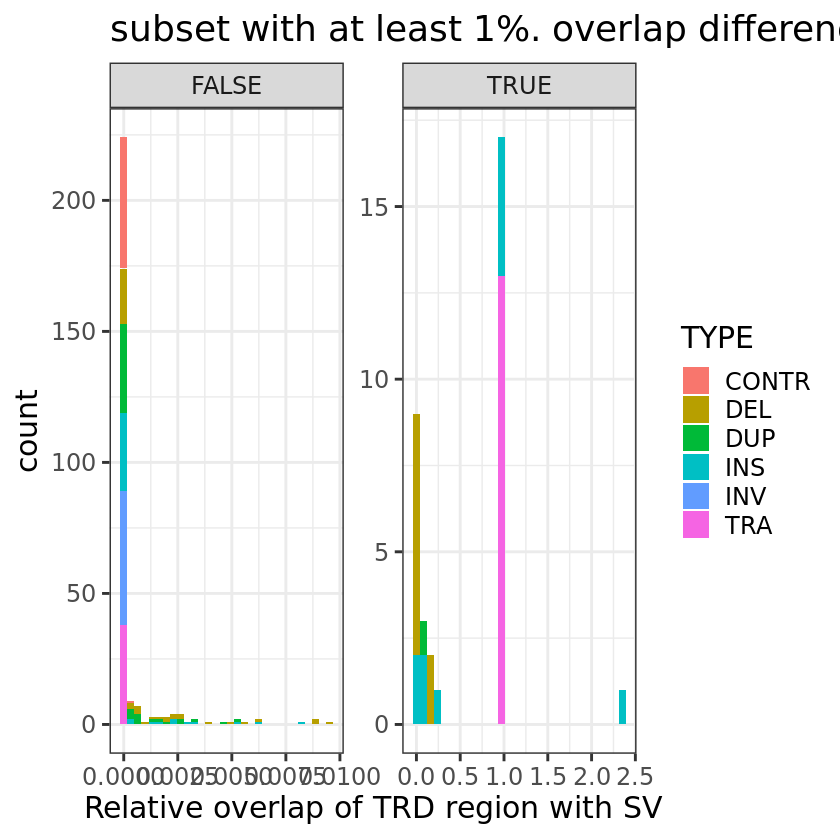

In [18]:
# What sort of SVs are involved?

library(ggplot2)
ggplot(SV_data_summary_parent_v_parent, aes(LEN_rel_diff_abs, fill=TYPE))+
geom_histogram()+
#facet_wrap(~source)+#+scale_y_log10()
theme_bw(18)+
xlab("Relative overlap of TRD region with SV")

library(ggplot2)
ggplot(SV_data_summary_parent_v_parent, aes(LEN_rel_diff_abs, fill=TYPE))+
geom_histogram()+
facet_wrap(~LEN_rel_diff_abs>0.01,scales = "free")+#+scale_y_log10()
theme_bw(18)+
xlab("Relative overlap of TRD region with SV")+ggtitle("subset with at least 1%. overlap difference")

In [19]:
# add a column that says if this TRD if this cross's strongest TRD

One_Table <- One_Table %>% 
  group_by(cross) %>%
  mutate(strongest = abs(AF - 0.5) == max(abs(AF - 0.5), na.rm = TRUE)) %>%
  ungroup()


Call:
lm(formula = tree_changes_raw ~ log(lengthBp), data = One_Table)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46689 -0.15303 -0.00452  0.07487  1.05773 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    9.38814    0.57415   16.35   <2e-16 ***
log(lengthBp) -0.56921    0.04723  -12.05   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2304 on 50 degrees of freedom
Multiple R-squared:  0.7439,	Adjusted R-squared:  0.7388 
F-statistic: 145.2 on 1 and 50 DF,  p-value: < 2.2e-16



Call:
lm(formula = tree_distance ~ log(lengthbp), data = random_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7349 -0.1868 -0.0669  0.0835  5.6643 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    8.869630   0.029017   305.7   <2e-16 ***
log(lengthbp) -0.525489   0.002443  -215.1   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3751 on 39998 degrees of freedom
Multiple R-squared:  0.5364,	Adjusted R-squared:  0.5363 
F-statistic: 4.627e+04 on 1 and 39998 DF,  p-value: < 2.2e-16


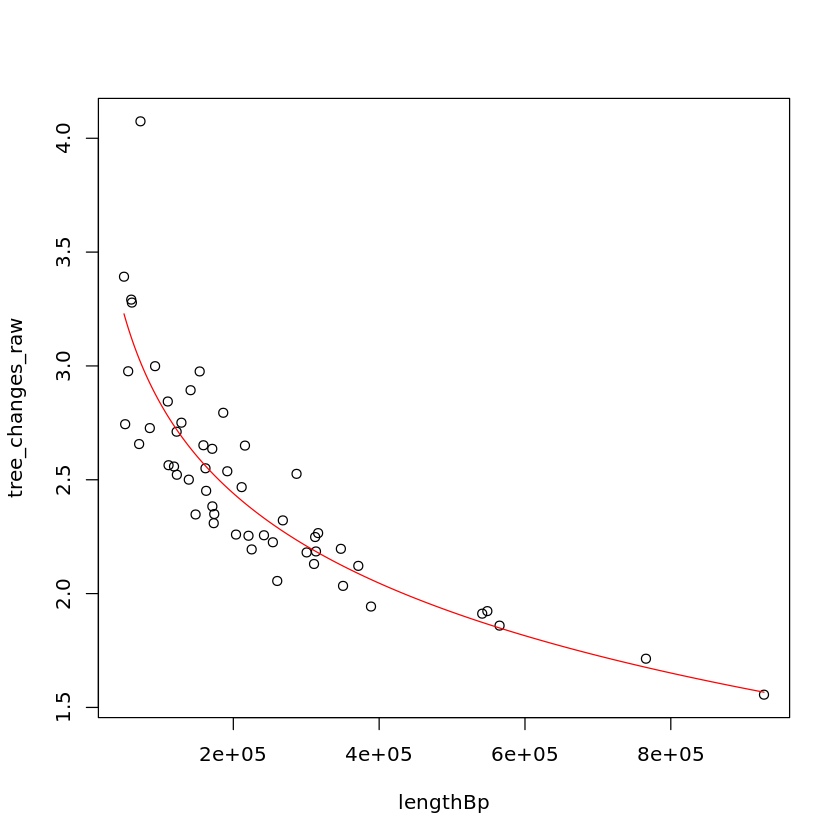

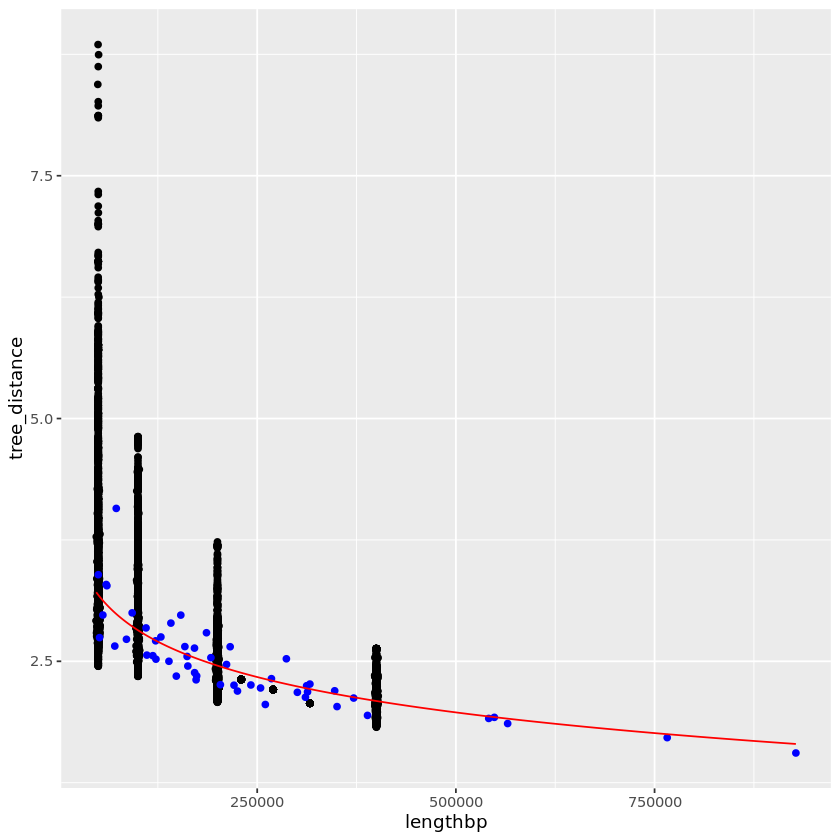

In [20]:
# quick evidence that tree changes at TRD locus needed to be corrected for size of TRD region
# the necessary changes have been made to 02_Local-Phylogeny now.

poly_model <- lm(tree_changes_raw ~ log(lengthBp), data = One_Table)
summary(poly_model)
x <- with(One_Table, seq(min(lengthBp), max(lengthBp), length.out=2000))
y <- predict(poly_model, newdata = data.frame(lengthBp = x))

plot(tree_changes_raw ~ lengthBp, data = One_Table)
lines(x, y, col = "red")

random_data<-fread("/home/jnrunge/data/trd/local_phylogenies_random_tree_data_distances.csv.gz") # from 02_Local-Phy

tree_distance_length_model <- lm(tree_distance ~ log(lengthbp),random_data)
summary(tree_distance_length_model)
x <- seq(min(pull(random_data,lengthbp)), max(pull(One_Table,lengthBp)), length.out=2000)
y <- predict(tree_distance_length_model, newdata = data.frame(lengthbp = x))

ggplot(random_data, aes(lengthbp,tree_distance))+
geom_point()+geom_point(data=One_Table, aes(lengthBp,tree_changes_raw), color="blue")+
geom_line(data=data.table(x=x,y=y), aes(x,y), color="red")




In [21]:
# somehow the correction based on residuals seems wrong in 02_Local-Phy, lets try again here

residuals_TRD_regions<-pull(One_Table, tree_changes_raw)-as.numeric(predict(tree_distance_length_model, data.table(lengthbp=pull(One_Table,lengthBp))))

mean_dist <- mean(tree_distance_length_model$residuals, na.rm = TRUE)
sd_dist <- sd(tree_distance_length_model$residuals, na.rm = TRUE)

residuals_TRD_regions_sd_dist<-(residuals_TRD_regions - mean_dist) / sd_dist

One_Table<-mutate(One_Table, tree_changes_sd_multiplier=residuals_TRD_regions_sd_dist)

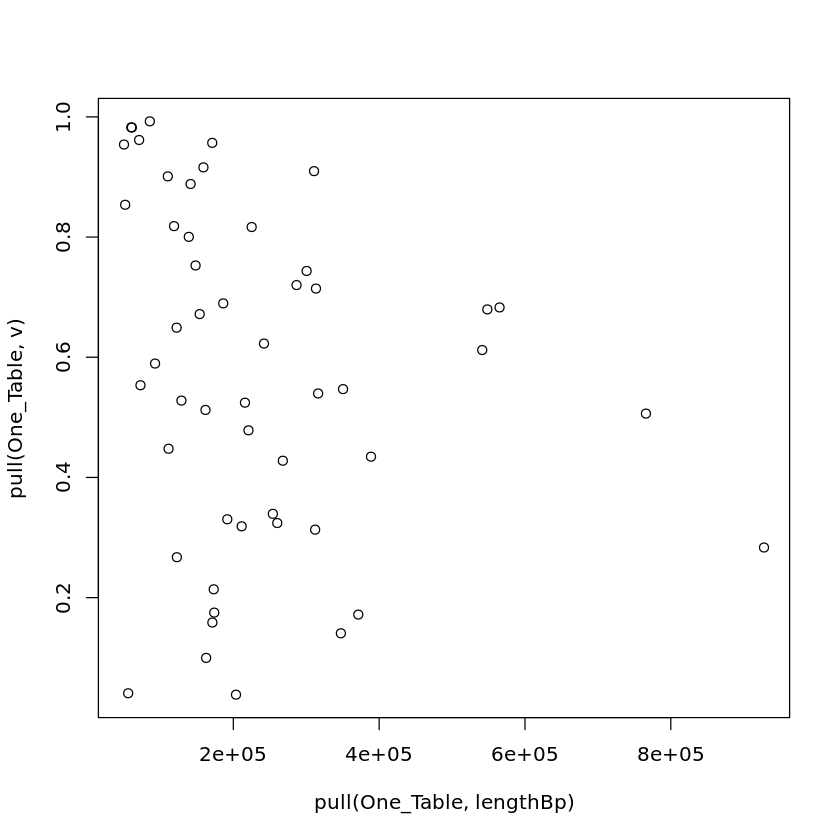

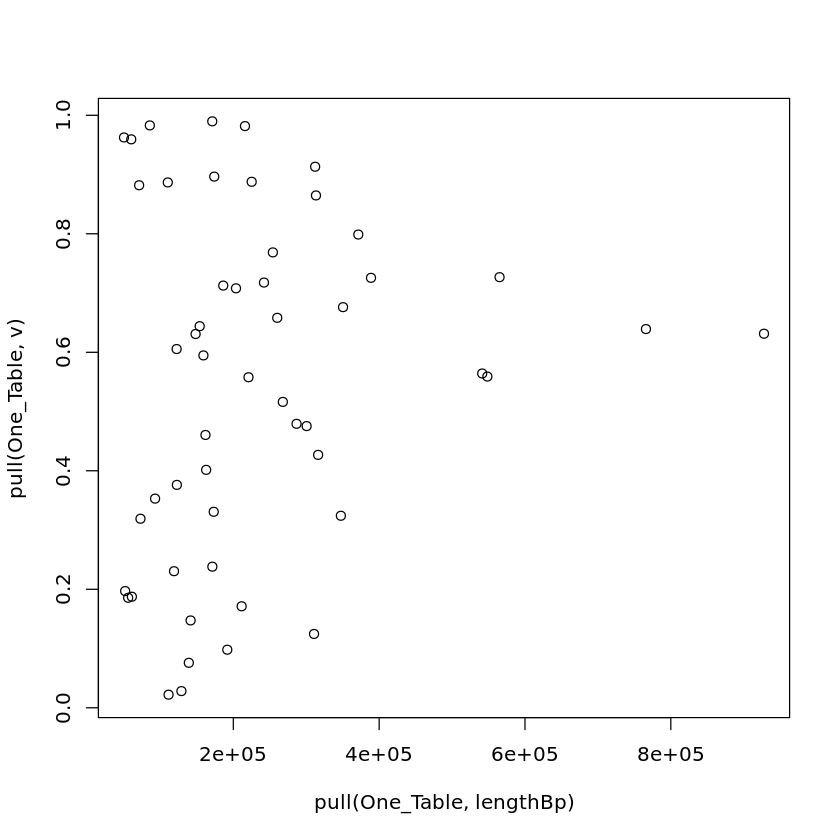

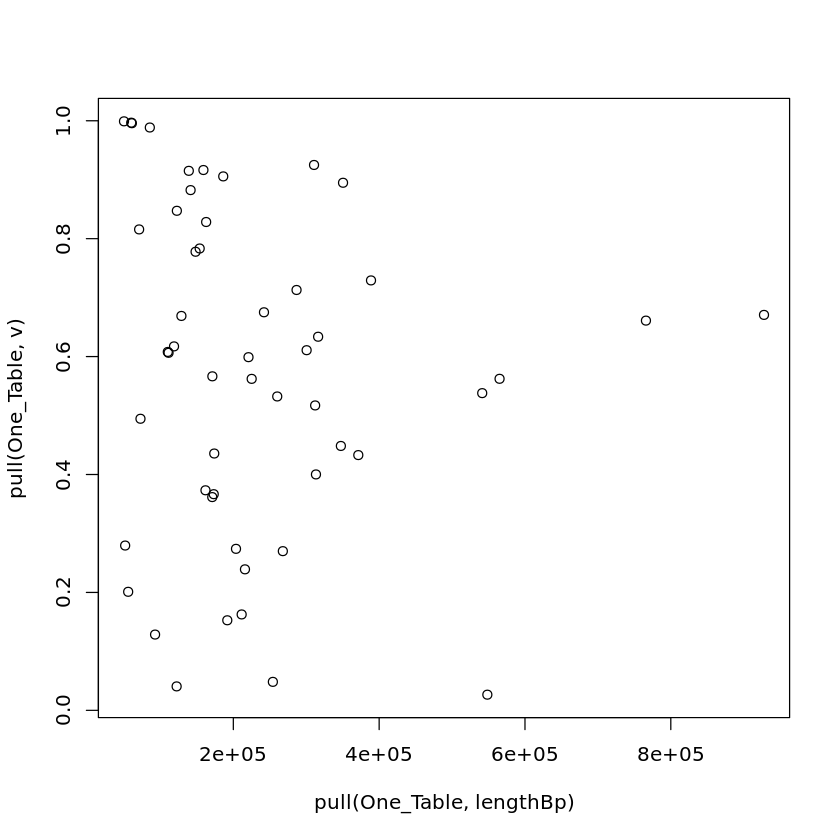

value,pAnova
<chr>,<dbl>
PCA_eucldist_quantile_1,0.1037522
PCA_eucldist_quantile_2,0.2500081
IBS_eucldist_quantile_1,0.5104842
IBS_eucldist_quantile_2,0.7344060


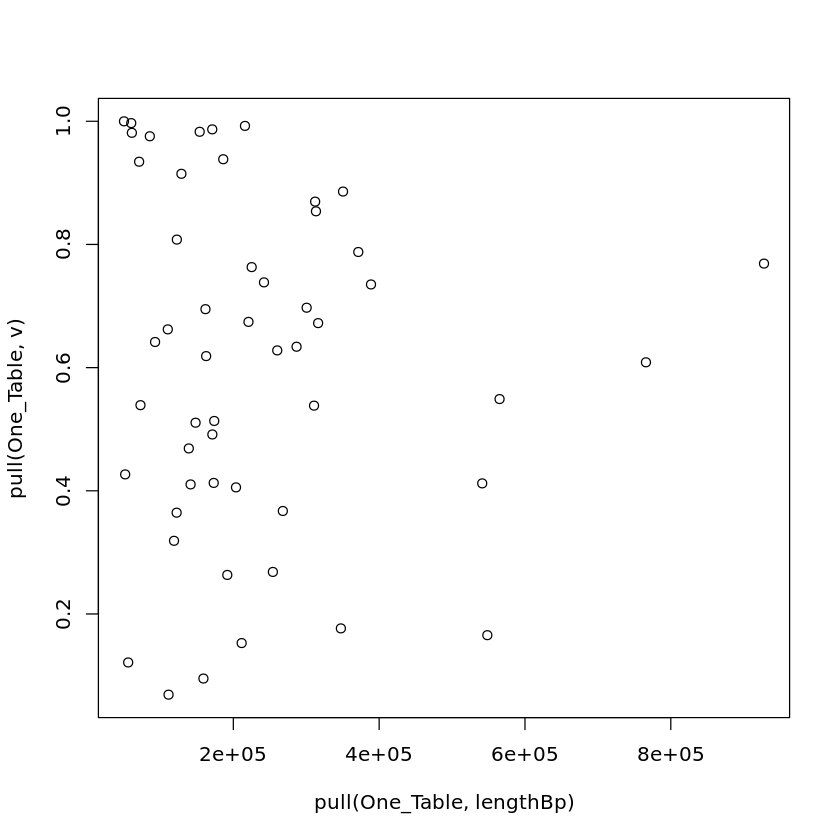

In [22]:
# the same is not the case for other local phylogeny measures
lp_bias<-data.table(value=c("PCA_eucldist_quantile_1",
                           "PCA_eucldist_quantile_2","IBS_eucldist_quantile_1",
                           "IBS_eucldist_quantile_2"), pAnova=NA)
for(v in pull(lp_bias,value)){
    lp_bias<-mutate(lp_bias, pAnova=ifelse(value==v, anova(lm(pull(One_Table,v)~pull(One_Table, lengthBp)), lm(pull(One_Table,v)~1, One_Table))$`Pr(>F)`[2],pAnova))
    plot(pull(One_Table,v)~pull(One_Table, lengthBp))
}

lp_bias

In [23]:
options(repr.plot.width=10, repr.plot.height=10)

# LP data prep


LP_colnames=c("PCA_eucldist_quantile_1","PCA_eucldist_sd_multiplier_1","IBS_eucldist_quantile_1","IBS_eucldist_sd_multiplier_1","tree_changes_quantile","tree_changes_sd_multiplier","PCA_eucldist_quantile_2","PCA_eucldist_sd_multiplier_2","IBS_eucldist_quantile_2","IBS_eucldist_sd_multiplier_2")
#LP_colnames=LP_colnames[grepl("quant",LP_colnames,fixed=TRUE)]
LP_summary<-pivot_longer(One_Table%>%select(Distorter, strongest, all_of(LP_colnames)), cols = LP_colnames)
LP_summary <- LP_summary %>% mutate(Distorter = case_when(
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") & 
    substr(name, nchar(name), nchar(name)) == Distorter ~ TRUE,
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") ~ FALSE,
  TRUE ~ NA_real_
))
LP_summary <- LP_summary %>% mutate(name = str_remove(name, "_[12]$"))

LP_summary <- LP_summary %>% 
  group_by(name) %>% 
  mutate(value_normalized = ifelse(grepl("quant",name,fixed=TRUE),value-0.5,value)) %>% 
  ungroup()

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(LP_colnames)

  # Now:
  data %>% select(all_of(LP_colnames))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


Next I am showing that the IBS and PCA values are overall higher than from the expected value (0.5 / 0.0), but not by much and the SD data indicates this to be perhaps driven by a few extreme examples, promising potential for interpretation.

Whether the value is taken from distorter or disorted does not matter, however, indicating more general changes at the locus.

**tree data not yet interpreted due to unfinished fix**


	One Sample t-test

data:  filter(LP_summary, name == "IBS_eucldist_quantile") %>% pull(value)
t = 3.2855, df = 103, p-value = 0.001392
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5349351 0.6413462
sample estimates:
mean of x 
0.5881406 



	One Sample t-test

data:  filter(LP_summary, name == "PCA_eucldist_quantile") %>% pull(value)
t = 2.0388, df = 103, p-value = 0.04403
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5015393 0.6114237
sample estimates:
mean of x 
0.5564815 



	One Sample t-test

data:  filter(LP_summary, name == "IBS_eucldist_sd_multiplier") %>% pull(value)
t = 2.9384, df = 103, p-value = 0.004072
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.1503277 0.7746111
sample estimates:
mean of x 
0.4624694 



	One Sample t-test

data:  filter(LP_summary, name == "PCA_eucldist_sd_multiplier") %>% pull(value)
t = 1.6695, df = 103, p-value = 0.09806
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.03637189  0.42339942
sample estimates:
mean of x 
0.1935138 



	One Sample t-test

data:  filter(LP_summary, name == "tree_changes_sd_multiplier") %>% pull(value)
t = -0.38032, df = 51, p-value = 0.7053
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.2030578  0.1383763
sample estimates:
  mean of x 
-0.03234073 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_quantile") %>% pull(value)
t = 0.6312, df = 99.639, p-value = 0.5294
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07280019  0.14073192
sample estimates:
mean of x mean of y 
0.6051236 0.5711577 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_quantile") %>% pull(value)
t = -0.099558, df = 101.79, p-value = 0.9209
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1159747  0.1048892
sample estimates:
mean of x mean of y 
0.5537101 0.5592529 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_sd_multiplier") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_sd_multiplier") %>% pull(value)
t = 0.52501, df = 101.17, p-value = 0.6007
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4607813  0.7924688
sample estimates:
mean of x mean of y 
0.5453912 0.3795475 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_sd_multiplier") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_sd_multiplier") %>% pull(value)
t = 0.1992, df = 97.793, p-value = 0.8425
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4158257  0.5086187
sample estimates:
mean of x mean of y 
0.2167120 0.1703155 


name,mean
<chr>,<dbl>
IBS_eucldist_quantile,0.58814062
IBS_eucldist_sd_multiplier,0.46246937
PCA_eucldist_quantile,0.55648149
PCA_eucldist_sd_multiplier,0.19351377
tree_changes_quantile,0.00000000
tree_changes_sd_multiplier,-0.03234073


Distorter,strongest,name,value,value_normalized
<dbl>,<lgl>,<chr>,<dbl>,<dbl>
0,FALSE,PCA_eucldist_quantile,0.2672750,-0.2327250
0,FALSE,PCA_eucldist_sd_multiplier,-0.2581440,-0.2581440
0,FALSE,IBS_eucldist_quantile,0.8473000,0.3473000
0,FALSE,IBS_eucldist_sd_multiplier,0.2468172,0.2468172
NA,FALSE,tree_changes_quantile,0.0000000,-0.5000000
NA,FALSE,tree_changes_sd_multiplier,-0.5086706,-0.5086706


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


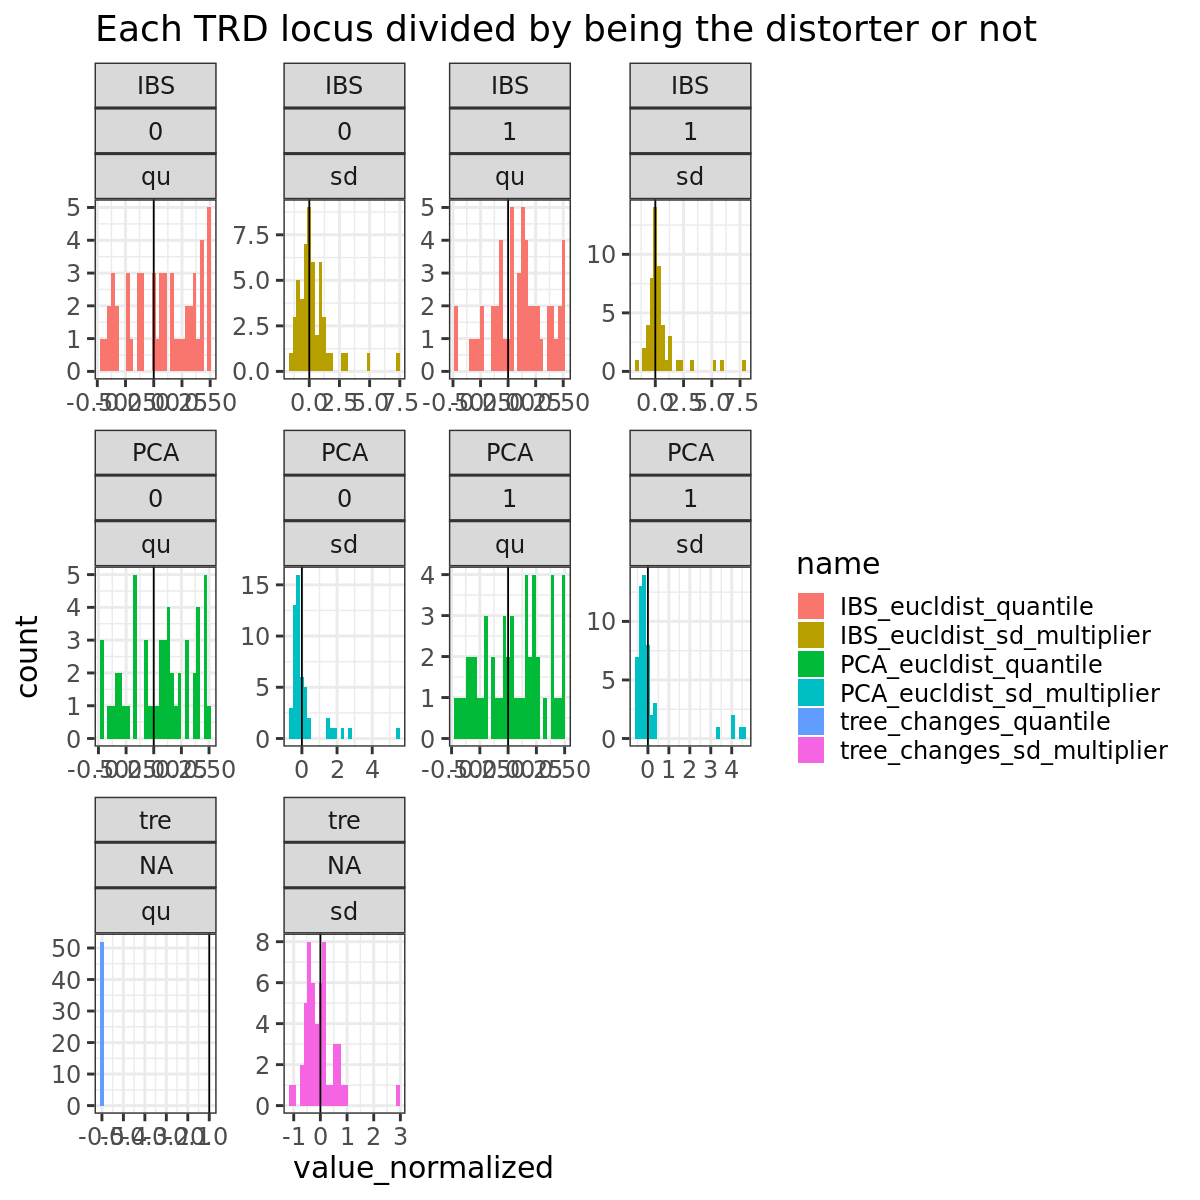

In [24]:
t.test(filter(LP_summary, name == "IBS_eucldist_quantile")%>%pull(value), mu=0.5)
t.test(filter(LP_summary, name == "PCA_eucldist_quantile")%>%pull(value), mu=0.5)
t.test(filter(LP_summary, name == "IBS_eucldist_sd_multiplier")%>%pull(value), mu=0)
t.test(filter(LP_summary, name == "PCA_eucldist_sd_multiplier")%>%pull(value), mu=0)

t.test(filter(LP_summary, name == "tree_changes_sd_multiplier")%>%pull(value), mu=0)


t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)

LP_summary%>%group_by(name)%>%summarize(mean=mean(value,na.rm=TRUE))

head(LP_summary)
ggplot(LP_summary, aes(value_normalized,fill=name))+
geom_histogram(position="dodge")+geom_vline(xintercept=0)+
facet_wrap(~substr(name,1,3)+Distorter+substr(name,14,15),scales="free")+theme_bw(18)+ggtitle("Each TRD locus divided by being the distorter or not")

In [25]:
# does not matter if we are looking at the strongest distorter

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

[1] 0.606165

[1] 0.8303192

[1] 0.7239892

[1] 0.9863009

[1] 0.4643099

[1] 0.8348736

[1] 0.3647384

[1] 0.817912

In [26]:
# pixy data overview

pixy_files<-list.files("/home/jnrunge/data/trd/pop_genomics","relative-measures.RDS$",full.names = TRUE)
pixy_df<-data.table()
for(f in pixy_files){
    f_<-readRDS(f)


f_ <- lapply(f_, function(x) {
  if ("pi_pop" %in% names(x)) {
    names(x)[names(x) == "pi_pop"] <- "sum_value"
  }
  x
})

df <- f_ %>%
  purrr::imap_dfr(function(y, name) {
    data.table(analysis = name, t(y))
  })
    
    df<-mutate(df, file=basename(f))
    
    pixy_df<-bind_rows(pixy_df, df)
    
}
pixy_df<-mutate(pixy_df, ecdf_value=as.numeric(ecdf_value))
pixy_df<-mutate(pixy_df, standardized_measure=as.numeric(standardized_measure))
pixy_df<-mutate(pixy_df, sum_value=as.numeric(sum_value))
pixy_df_OG<-pixy_df
head(pixy_df)






analysis,sum_value,ecdf_value,standardized_measure,file
<chr>,<dbl>,<dbl>,<dbl>,<chr>
pi_distorter,0.0009943079,0.3612785,-0.08921610,ChrisC1.1-relative-measures.RDS
pi_other,0.0034313165,0.5492884,-0.06241907,ChrisC1.1-relative-measures.RDS
fst,0.1083332162,0.7935371,0.48939505,ChrisC1.1-relative-measures.RDS
dxy,0.0027576655,0.5276395,-0.06862047,ChrisC1.1-relative-measures.RDS
pi_distorter,0.0008429781,0.6485542,-0.03174992,ChrisC1.13-relative-measures.RDS
pi_other,0.0036112803,0.5879682,-0.05219997,ChrisC1.13-relative-measures.RDS


In [27]:
getCrossAndID=function(x){
    x<-strsplit(x, "-", fixed=TRUE)[[1]][1]
    x<-strsplit(x, ".", fixed=TRUE)[[1]]
    return(data.table(cross=x[1], ID=x[2]))
}

pixy_df<-bind_cols(pixy_df, bind_rows(lapply(pull(pixy_df, file), getCrossAndID)))
head(pixy_df)
pixy_df%>%pull(cross)%>%unique()

pixy_df<-select(pixy_df, -file)%>%
  pivot_wider(names_from = analysis, 
              values_from = c(sum_value, ecdf_value, standardized_measure),
              names_sep = "_",
              id_cols = c(cross, ID))

pixy_df<-filter(pixy_df, paste(cross,ID) %in% paste(pull(One_Table, cross), pull(One_Table, ID)))

analysis,sum_value,ecdf_value,standardized_measure,file,cross,ID
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
pi_distorter,0.0009943079,0.3612785,-0.08921610,ChrisC1.1-relative-measures.RDS,ChrisC1,1
pi_other,0.0034313165,0.5492884,-0.06241907,ChrisC1.1-relative-measures.RDS,ChrisC1,1
fst,0.1083332162,0.7935371,0.48939505,ChrisC1.1-relative-measures.RDS,ChrisC1,1
dxy,0.0027576655,0.5276395,-0.06862047,ChrisC1.1-relative-measures.RDS,ChrisC1,1
pi_distorter,0.0008429781,0.6485542,-0.03174992,ChrisC1.13-relative-measures.RDS,ChrisC1,13
pi_other,0.0036112803,0.5879682,-0.05219997,ChrisC1.13-relative-measures.RDS,ChrisC1,13


[1] "ChrisC1" "ChrisC3" "ChrisC4" "ChrisC5" "ChrisC7" "ChrisC8" "YJNRC12"
 [8] "YJNRC14" "YJNRC15" "YJNRC18" "YJNRC19" "YJNRC2"  "YJNRC20" "YJNRC21"
[15] "YJNRC22" "YJNRC23" "YJNRC24" "YJNRC25" "YJNRC26" "YJNRC27" "YJNRC29"
[22] "YJNRC3"  "YJNRC30" "YJNRC31" "YJNRC32" "YJNRC4"  "YJNRC5"  "YJNRC6" 
[29] "YJNRC7"  "YJNRC8"  "YJNRC9"

In [28]:
pixy_df<-mutate(pixy_df, ID=as.numeric(ID))
One_Table<-full_join(One_Table, pixy_df, by=c("cross","ID"))

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 8 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 8 rows containing missing values (`geom_point()`)."


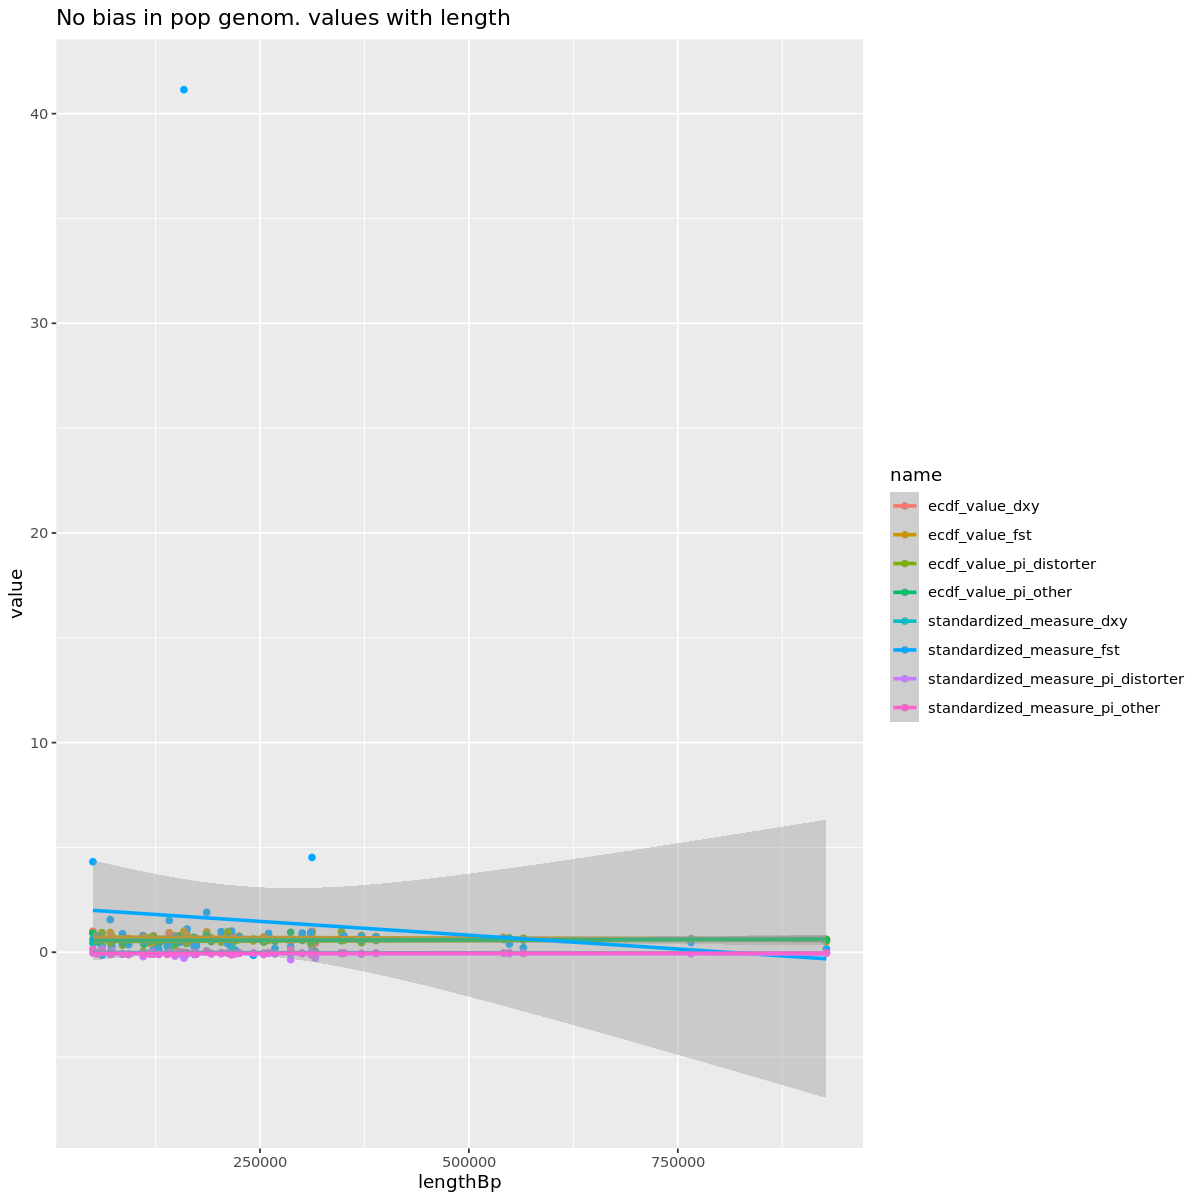

In [29]:
ggplot(One_Table%>%select(cross,ID,ecdf_value_fst,ecdf_value_dxy,ecdf_value_pi_distorter,ecdf_value_pi_other,standardized_measure_fst,standardized_measure_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,lengthBp)%>%
pivot_longer(cols = c(ecdf_value_fst, ecdf_value_dxy, ecdf_value_pi_distorter, 
                        ecdf_value_pi_other, standardized_measure_fst, standardized_measure_dxy, 
                        standardized_measure_pi_distorter, standardized_measure_pi_other)),
       aes(lengthBp, value, color=name))+
geom_point()+geom_smooth(method="lm")+ggtitle("No bias in pop genom. values with length")

evidence that fst is increased at trd loci, but mixed results for other values; probably more interesting to look at specific examples

In [30]:
pixy_global_tests<-data.table(value=c("ecdf_value_fst","ecdf_value_dxy","ecdf_value_pi_distorter","ecdf_value_pi_other","standardized_measure_fst","standardized_measure_dxy","standardized_measure_pi_distorter","standardized_measure_pi_other"),
                             p=NA, mean=NA)
for(i in 1:nrow(pixy_global_tests)){
    pgt_slice<-slice(pixy_global_tests, i)
    pgt_slice_value<-pull(pgt_slice, value)
    ttest_value<-t.test(pull(One_Table, pgt_slice_value), mu=ifelse(startsWith(pgt_slice_value,"ecdf"),0.5,0))$p.value
    pixy_global_tests<-mutate(pixy_global_tests, p=ifelse(value==pgt_slice_value,ttest_value,p))
    pixy_global_tests<-mutate(pixy_global_tests, mean=ifelse(value==pgt_slice_value,mean(pull(One_Table, pgt_slice_value),na.rm=TRUE),mean))
}
pixy_global_tests

value,p,mean
<chr>,<dbl>,<dbl>
ecdf_value_fst,6.458854e-13,0.70618794
ecdf_value_dxy,1.401076e-07,0.61397622
ecdf_value_pi_distorter,3.534860e-01,0.52833639
ecdf_value_pi_other,4.158842e-05,0.57716114
standardized_measure_fst,6.673441e-02,1.50317107
standardized_measure_dxy,2.381609e-01,-0.01817466
standardized_measure_pi_distorter,4.220058e-08,-0.07486163
standardized_measure_pi_other,4.572375e-09,-0.04971125


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 54 rows containing non-finite values (`stat_bin()`)."


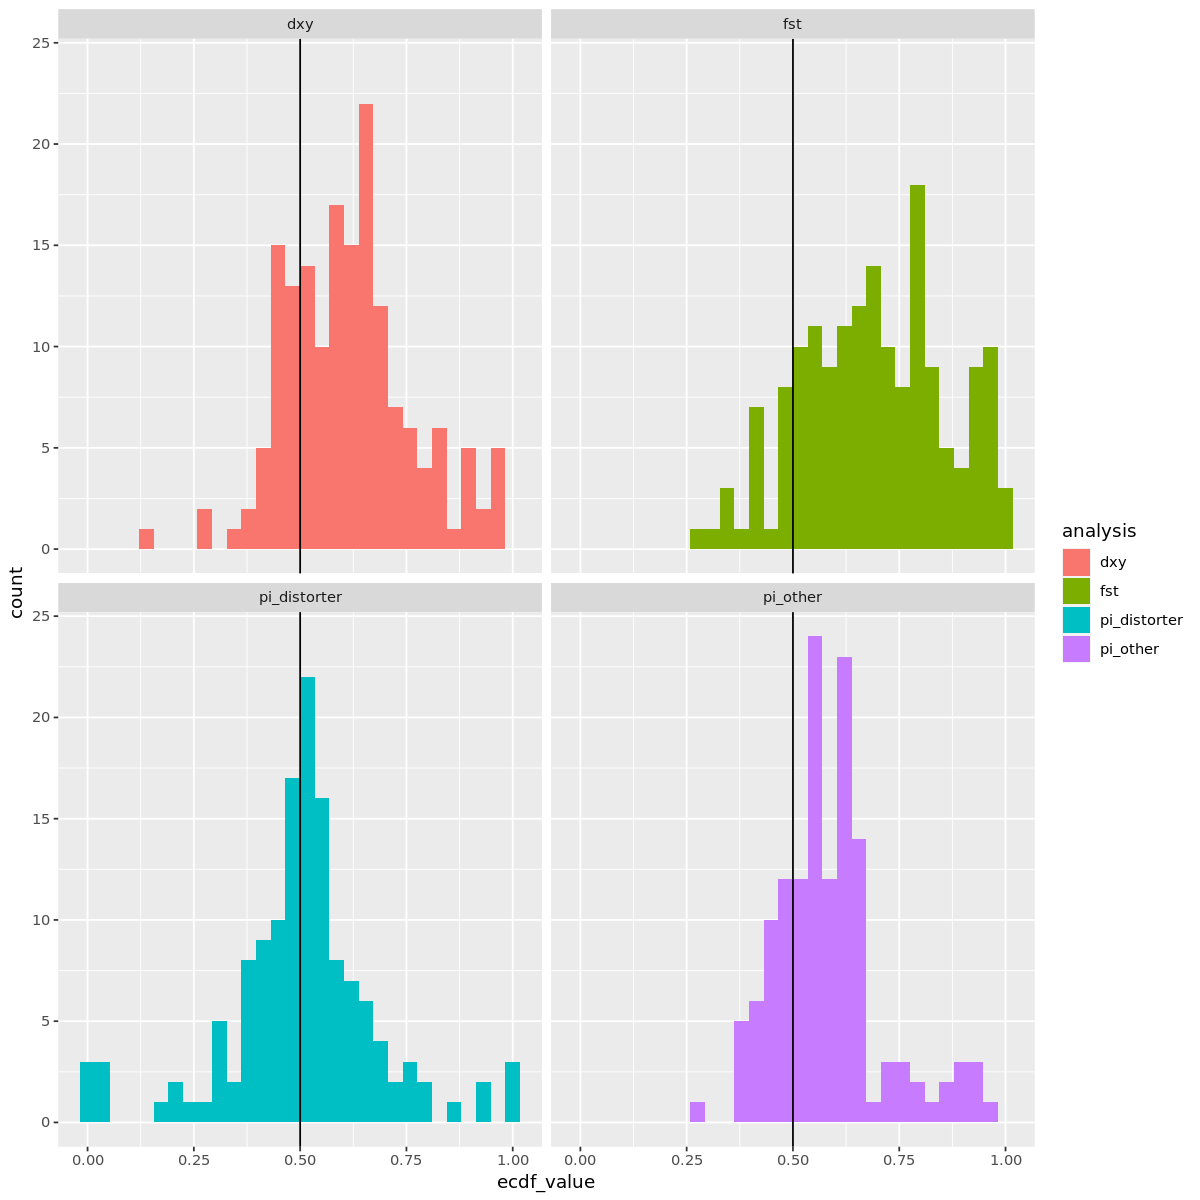

In [31]:
ggplot(pixy_df_OG, aes(ecdf_value, fill=analysis))+
geom_histogram()+facet_wrap(~analysis)+geom_vline(xintercept = 0.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 54 rows containing non-finite values (`stat_bin()`)."


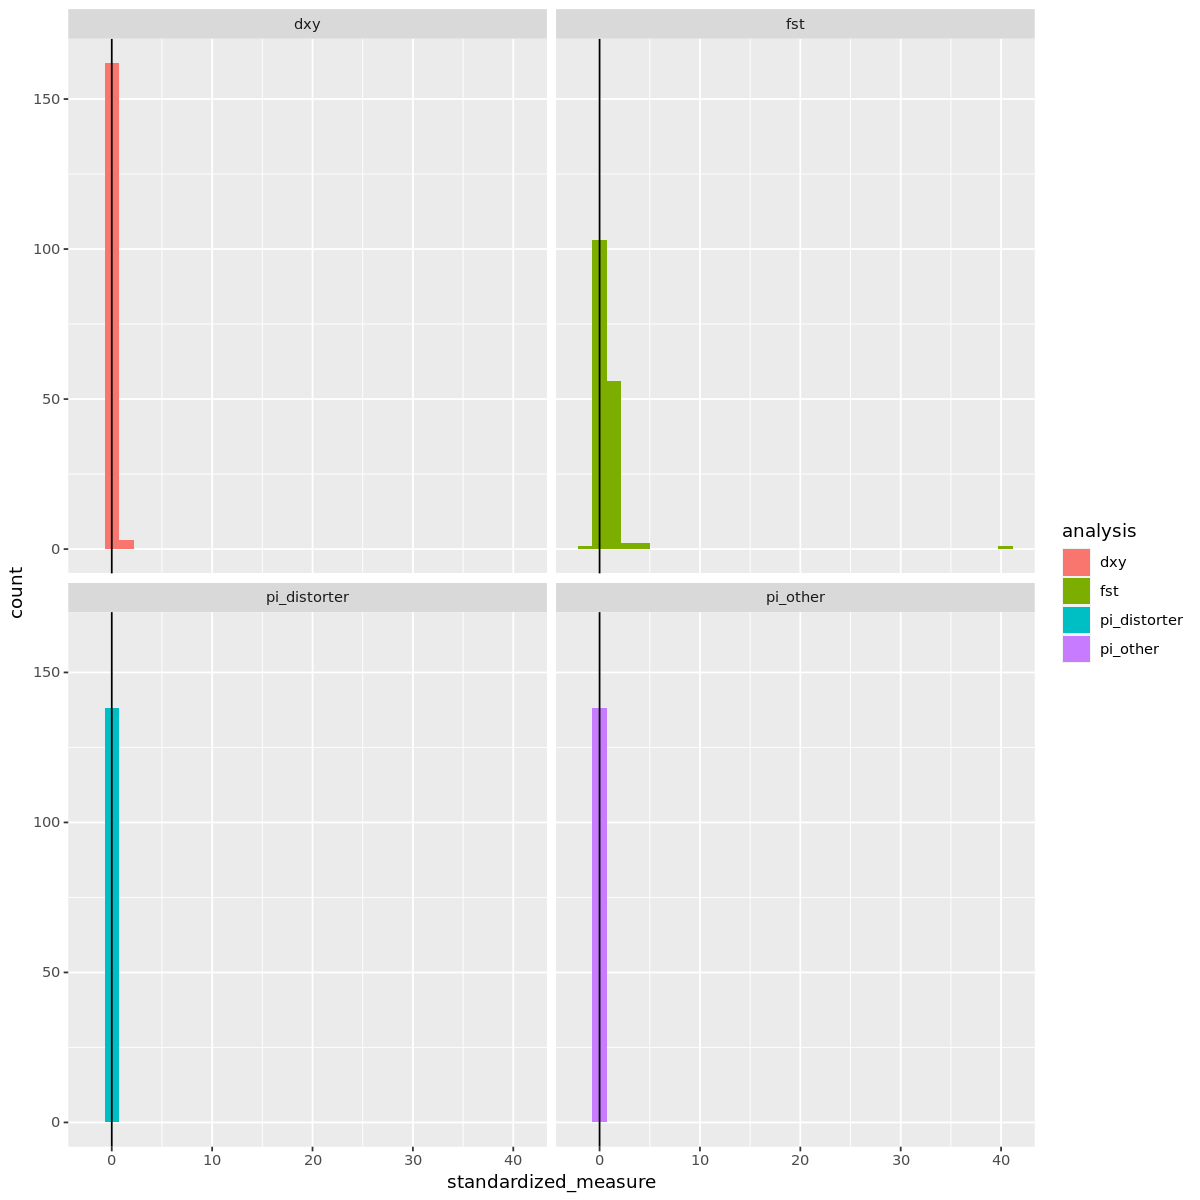

In [32]:
ggplot(pixy_df_OG, aes(standardized_measure, fill=analysis))+
geom_histogram()+facet_wrap(~analysis)+geom_vline(xintercept = 0)

In [33]:
colnames(One_Table)

[1] "ID"                                "lengthSNPs"                       
 [3] "chr"                               "global_start"                     
 [5] "global_end"                        "lengthBp"                         
 [7] "cross"                             "start"                            
 [9] "end"                               "PCA_eucldist_quantile_1"          
[11] "PCA_eucldist_sd_multiplier_1"      "IBS_eucldist_quantile_1"          
[13] "IBS_eucldist_sd_multiplier_1"      "tree_changes_quantile"            
[15] "tree_changes_sd_multiplier"        "tree_changes_raw"                 
[17] "PCA_eucldist_quantile_2"           "PCA_eucldist_sd_multiplier_2"     
[19] "IBS_eucldist_quantile_2"           "IBS_eucldist_sd_multiplier_2"     
[21] "AF"                                "AF_peak"                          
[23] "AF_lm_int"                         "AF_lm_poly1"                      
[25] "AF_lm_poly2"                       "AF_lm_r2"                         
[27] "AF_lm_anova"                       "AF_lm_anova_RSS"                  
[29] "AF_lm_poly1_1"                     "AF_lm_resid_median"               
[31] "Distorter"                         "polynomial_filtered_out"          
[33] "bad_viz_inf"                       "strongest"                        
[35] "sum_value_pi_distorter"            "sum_value_pi_other"               
[37] "sum_value_fst"                     "sum_value_dxy"                    
[39] "ecdf_value_pi_distorter"           "ecdf_value_pi_other"              
[41] "ecdf_value_fst"                    "ecdf_value_dxy"                   
[43] "standardized_measure_pi_distorter" "standardized_measure_pi_other"    
[45] "standardized_measure_fst"          "standardized_measure_dxy"

In [34]:
# add SV data to big table#
One_Table<-One_Table%>%mutate(ID=as.character(ID))
One_Table<-left_join(One_Table,pivot_wider(SV_data_summary_parent_v_parent, id_cols=c("cross","ID"), names_from=c("TYPE"), values_from = c("LEN_rel_diff_abs"), values_fill = 0), by=c("cross","ID"))
One_Table

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,...,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,CONTR,DEL,DUP,INS,INV,TRA
<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339,0.267275,...,-0.089216098,-0.062419070,0.48939505,-0.068620474,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.0000000
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,0.682900,...,-0.031749918,-0.052199966,0.21550380,-0.050090593,0.000000e+00,0.000000e+00,0.000000e+00,2.831137e-05,0,0.0000000
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,0.478400,...,-0.079262337,-0.042589452,0.09760369,-0.055308074,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.0000000
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,0.714300,...,-0.076357850,-0.061159202,0.51830964,-0.062600736,0.000000e+00,1.184044e-03,0.000000e+00,3.102131e-03,0,0.0000000
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,0.158575,...,-0.055523523,-0.092672270,0.29004999,-0.077213260,0.000000e+00,0.000000e+00,1.851106e-03,0.000000e+00,0,0.0000000
2,137,chromosome4,1633021,1919730,286709,ChrisC5,304176,590885,0.720150,...,-0.357261606,0.126157502,0.24140746,-0.080087789,2.092714e-05,3.006882e-02,0.000000e+00,1.695099e-03,0,0.0000000
3,3567,chromosome5,2975476,3287692,312216,ChrisC7,96134,408350,0.313125,...,0.094128891,-0.139754239,4.52148000,0.343674634,0.000000e+00,2.242038e-03,2.306096e-04,1.441310e-04,0,0.0000000
4,6799,chromosome7,3915832,4681735,765903,ChrisC7,204825,970728,0.506275,...,-0.074388991,-0.045772699,0.46429916,0.011153187,3.394686e-05,5.003245e-03,2.232659e-04,8.208611e-03,0,0.0000000
7,1227,chromosome11,6558616,6697564,138948,ChrisC7,29994,168942,0.800375,...,-0.069770519,-0.099646934,0.27885234,-0.085671112,0.000000e+00,1.029162e-03,3.375363e-03,2.303020e-04,0,0.0000000


In [35]:
One_Table<-filter(One_Table, !is.na(chr))

In [36]:
# add LD and TD data
LD_data<-fread("/home/jnrunge/data/trd/LD_data/LD_plot_data.csv.gz")
TD_data<-fread("/home/jnrunge/data/trd/TD_data/TD_plot_data.csv.gz")
One_Table<-One_Table%>%mutate(ID=as.numeric(ID))

One_Table<-left_join(One_Table, LD_data)
One_Table<-left_join(One_Table, TD_data)

Joining with `by = join_by(ID, cross)`
Joining with `by = join_by(ID, cross)`


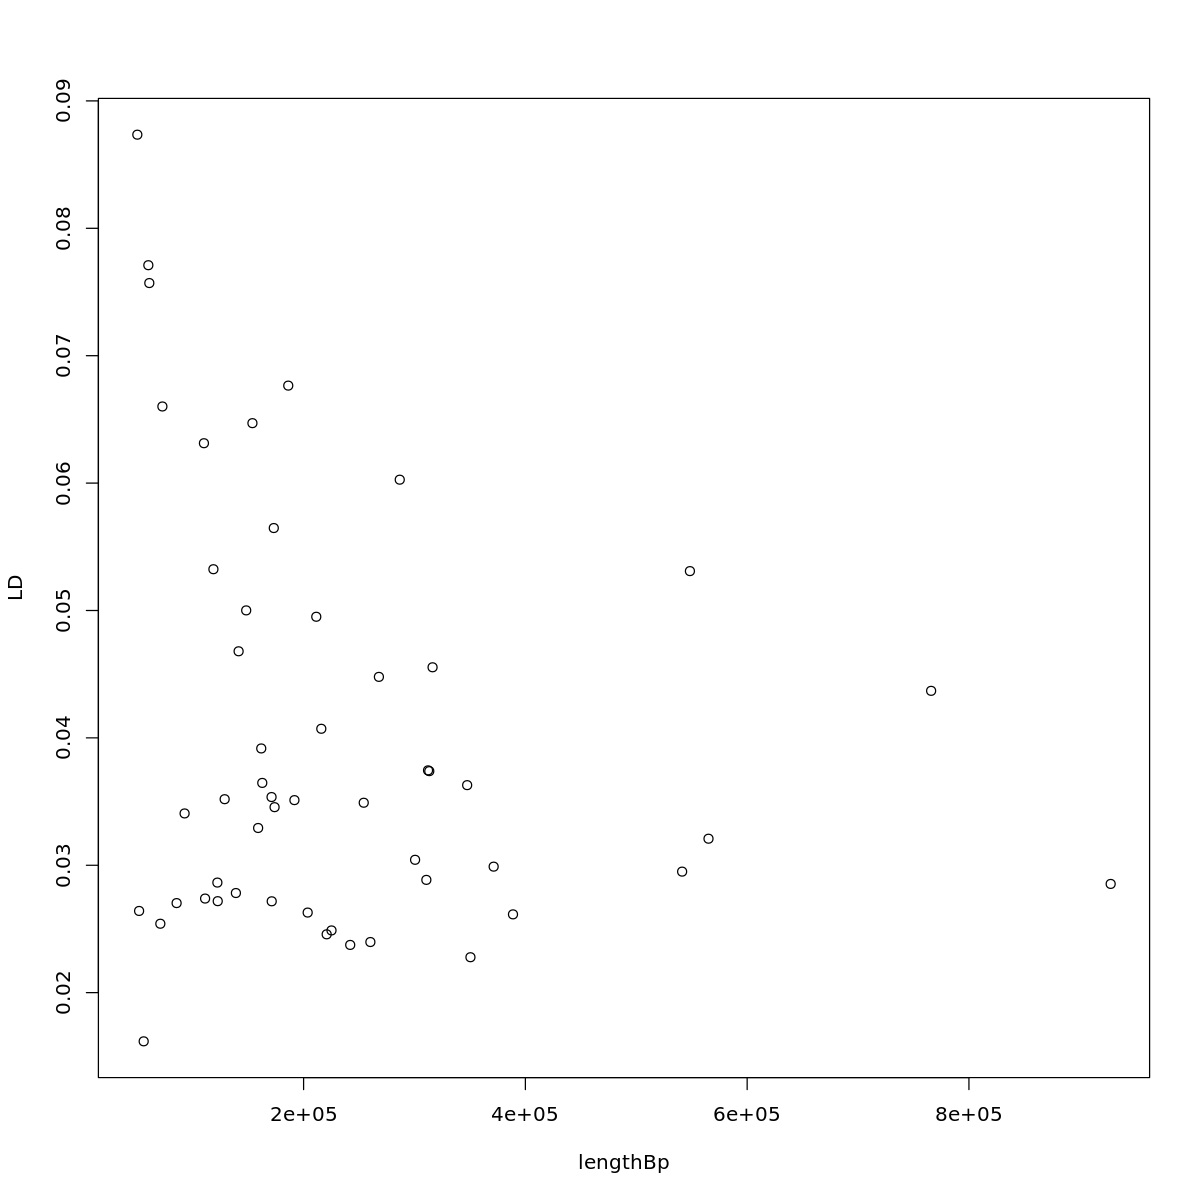

In [37]:
plot(LD ~ lengthBp, One_Table)

In [38]:
paste(colnames(One_Table),collapse=",")

[1] "ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2,AF,AF_peak,AF_lm_int,AF_lm_poly1,AF_lm_poly2,AF_lm_r2,AF_lm_anova,AF_lm_anova_RSS,AF_lm_poly1_1,AF_lm_resid_median,Distorter,polynomial_filtered_out,bad_viz_inf,strongest,sum_value_pi_distorter,sum_value_pi_other,sum_value_fst,sum_value_dxy,ecdf_value_pi_distorter,ecdf_value_pi_other,ecdf_value_fst,ecdf_value_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,CONTR,DEL,DUP,INS,INV,TRA,LD,LD_sd_multi_1,LD_sd_multi_2,TD,TD_sd_multi,TD_ecdf"

In [39]:
scale_numeric<-function(x){
    return(as.numeric(scale(x, center = FALSE)))
}

In [40]:
colnames(One_Table)

[1] "ID"                                "lengthSNPs"                       
 [3] "chr"                               "global_start"                     
 [5] "global_end"                        "lengthBp"                         
 [7] "cross"                             "start"                            
 [9] "end"                               "PCA_eucldist_quantile_1"          
[11] "PCA_eucldist_sd_multiplier_1"      "IBS_eucldist_quantile_1"          
[13] "IBS_eucldist_sd_multiplier_1"      "tree_changes_quantile"            
[15] "tree_changes_sd_multiplier"        "tree_changes_raw"                 
[17] "PCA_eucldist_quantile_2"           "PCA_eucldist_sd_multiplier_2"     
[19] "IBS_eucldist_quantile_2"           "IBS_eucldist_sd_multiplier_2"     
[21] "AF"                                "AF_peak"                          
[23] "AF_lm_int"                         "AF_lm_poly1"                      
[25] "AF_lm_poly2"                       "AF_lm_r2"                         
[27] "AF_lm_anova"                       "AF_lm_anova_RSS"                  
[29] "AF_lm_poly1_1"                     "AF_lm_resid_median"               
[31] "Distorter"                         "polynomial_filtered_out"          
[33] "bad_viz_inf"                       "strongest"                        
[35] "sum_value_pi_distorter"            "sum_value_pi_other"               
[37] "sum_value_fst"                     "sum_value_dxy"                    
[39] "ecdf_value_pi_distorter"           "ecdf_value_pi_other"              
[41] "ecdf_value_fst"                    "ecdf_value_dxy"                   
[43] "standardized_measure_pi_distorter" "standardized_measure_pi_other"    
[45] "standardized_measure_fst"          "standardized_measure_dxy"         
[47] "CONTR"                             "DEL"                              
[49] "DUP"                               "INS"                              
[51] "INV"                               "TRA"                              
[53] "LD"                                "LD_sd_multi_1"                    
[55] "LD_sd_multi_2"                     "TD"                               
[57] "TD_sd_multi"                       "TD_ecdf"

In [41]:
summarize(group_by(One_Table, Distorter), n=n())

Distorter,n
<chr>,<int>
1,25
2,27


In [42]:
# acknowldgeding TRD direction in the PCA / IBS data

One_Table<-mutate(One_Table, PCA_eucldist_sd_multiplier_distorter=ifelse(Distorter==1,
                                                                         PCA_eucldist_sd_multiplier_1,
                                                                         PCA_eucldist_sd_multiplier_2),
                    PCA_eucldist_sd_multiplier_other=ifelse(Distorter==2,
                                                                         PCA_eucldist_sd_multiplier_1,
                                                                         PCA_eucldist_sd_multiplier_2),
                 IBS_eucldist_sd_multiplier_distorter=ifelse(Distorter==1,
                                                                         IBS_eucldist_sd_multiplier_1,
                                                                         IBS_eucldist_sd_multiplier_2),
                 IBS_eucldist_sd_multiplier_other=ifelse(Distorter==2,
                                                                         IBS_eucldist_sd_multiplier_1,
                                                                         IBS_eucldist_sd_multiplier_2),
                 
                 
                 PCA_eucldist_quantile_distorter=ifelse(Distorter==1,
                                                                         PCA_eucldist_sd_multiplier_1,
                                                                         PCA_eucldist_sd_multiplier_2),
                    PCA_eucldist_quantile_other=ifelse(Distorter==2,
                                                                         PCA_eucldist_sd_multiplier_1,
                                                                         PCA_eucldist_sd_multiplier_2),
                 IBS_eucldist_quantile_distorter=ifelse(Distorter==1,
                                                                         IBS_eucldist_sd_multiplier_1,
                                                                         IBS_eucldist_sd_multiplier_2),
                 IBS_eucldist_quantile_other=ifelse(Distorter==2,
                                                                         IBS_eucldist_sd_multiplier_1,
                                                                         IBS_eucldist_sd_multiplier_2))

name,mean,ttest_p_value
<chr>,<dbl>,<dbl>
IBS_eucldist_sd_multiplier_distorter,0.54539124,2.334582e-02
IBS_eucldist_sd_multiplier_other,0.37954751,8.072352e-02
LD_sd_multi_1,2.56495073,4.739848e-22
LD_sd_multi_2,-0.93950236,1.689429e-12
PCA_eucldist_sd_multiplier_distorter,0.21671201,2.366472e-01
PCA_eucldist_sd_multiplier_other,0.17031552,2.508150e-01
TD_sd_multi,0.22309548,1.353164e-01
standardized_measure_dxy,-0.01817466,2.381609e-01
standardized_measure_fst,1.50317107,6.673441e-02


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


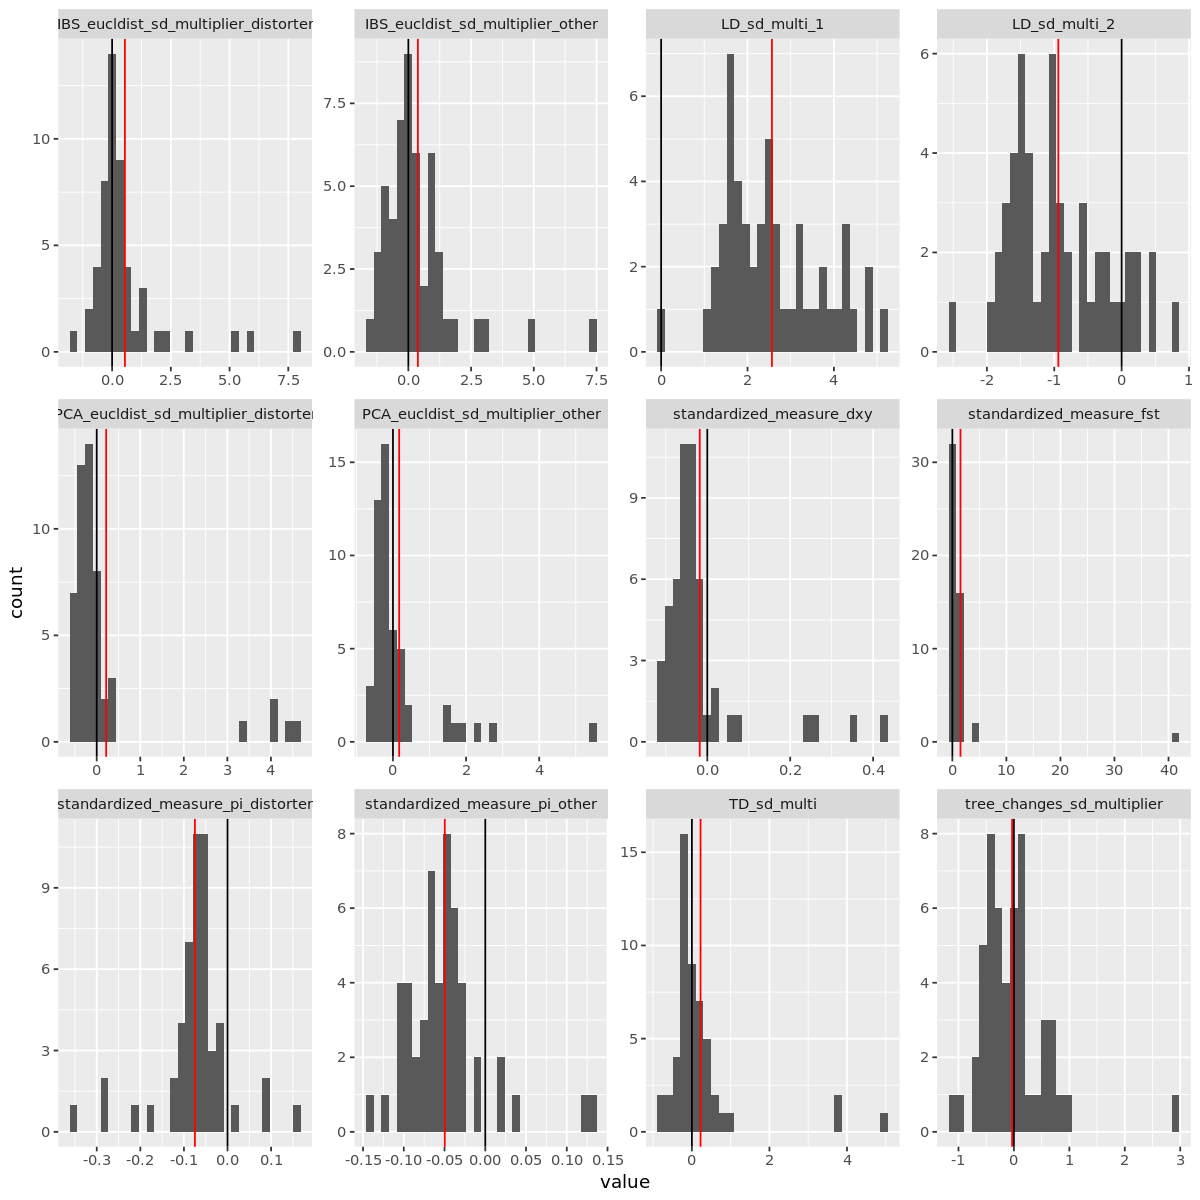

In [43]:
# is the mean different from expectation?

One_Table_sd_based_values<-One_Table%>%select(matches("sd|standardized"))%>%select(!matches("multiplier_[12]"))%>%
pivot_longer(cols=everything())%>%filter(!is.na(value))

One_Table_sd_based_values_means<-One_Table_sd_based_values%>%group_by(name)%>%summarize(mean=mean(value),
                                                                                       ttest_p_value=t.test(value,
                                                                                                           mu=0)$p.value)
One_Table_sd_based_values_means
ggplot(One_Table_sd_based_values,
      aes(value))+
geom_histogram()+facet_wrap(~name, scales="free")+geom_vline(xintercept=0)+
geom_vline(data=One_Table_sd_based_values_means, aes(xintercept=mean), color="red")



In [44]:
knitr::kable(One_Table_sd_based_values_means)



|name                                 |       mean| ttest_p_value|
|:------------------------------------|----------:|-------------:|
|IBS_eucldist_sd_multiplier_distorter |  0.5453912|     0.0233458|
|IBS_eucldist_sd_multiplier_other     |  0.3795475|     0.0807235|
|LD_sd_multi_1                        |  2.5649507|     0.0000000|
|LD_sd_multi_2                        | -0.9395024|     0.0000000|
|PCA_eucldist_sd_multiplier_distorter |  0.2167120|     0.2366472|
|PCA_eucldist_sd_multiplier_other     |  0.1703155|     0.2508150|
|TD_sd_multi                          |  0.2230955|     0.1353164|
|standardized_measure_dxy             | -0.0181747|     0.2381609|
|standardized_measure_fst             |  1.5031711|     0.0667344|
|standardized_measure_pi_distorter    | -0.0748616|     0.0000000|
|standardized_measure_pi_other        | -0.0497113|     0.0000000|
|tree_changes_sd_multiplier           | -0.0323407|     0.7052890|

In [45]:
# getting rid of the SVs and also NAs
# only one type of variable (sd multipliers) for now so that no scaling issues can arise
clustering_subset<-select(One_Table, AF,
                         #PCA_eucldist_sd_multiplier_distorter,
                          IBS_eucldist_sd_multiplier_distorter,
                          #tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,
                          tree_changes_sd_multiplier,
                        #PCA_eucldist_sd_multiplier_other,
                          IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi)


clustering_subset <- clustering_subset %>% mutate(AF=abs(AF-0.5)) %>%
  # Scale all columns
  mutate_all(~ scale_numeric(.)) %>% mutate(row=row_number())%>%
  # Convert to rowwise data frame
  rowwise() %>%
  # Remove rows with NA values
  filter(!any(is.na(c_across(everything()))))

OneTable_rows_in_clustering_subset<-pull(clustering_subset, row)
clustering_subset<-select(clustering_subset, -row)

In [46]:
clustering_subset%>%cor()

,AF,IBS_eucldist_sd_multiplier_distorter,tree_changes_sd_multiplier,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi
AF,1.00000000,-0.2344328,0.05698518,-0.04284717,-0.21281743,0.12391933,-0.11903483,-0.03201923,0.06756408,-0.15423333
IBS_eucldist_sd_multiplier_distorter,-0.23443278,1.0000000,0.22020360,0.69091821,0.15783634,0.58145424,0.12865489,0.58712914,0.40435260,0.89294596
tree_changes_sd_multiplier,0.05698518,0.2202036,1.00000000,0.17112112,0.14516103,0.25215598,0.06700552,0.27217964,0.61587355,0.25374797
IBS_eucldist_sd_multiplier_other,-0.04284717,0.6909182,0.17112112,1.00000000,0.12013658,0.37266989,-0.05772605,0.66223178,0.31815412,0.71626761
standardized_measure_pi_distorter,-0.21281743,0.1578363,0.14516103,0.12013658,1.00000000,-0.10968451,-0.32505686,0.46479671,0.01856729,0.23875184
standardized_measure_pi_other,0.12391933,0.5814542,0.25215598,0.37266989,-0.10968451,1.00000000,0.03938881,0.32605066,0.41488517,0.65627570
standardized_measure_fst,-0.11903483,0.1286549,0.06700552,-0.05772605,-0.32505686,0.03938881,1.00000000,0.06978197,-0.01226888,0.08332773
standardized_measure_dxy,-0.03201923,0.5871291,0.27217964,0.66223178,0.46479671,0.32605066,0.06978197,1.00000000,0.37279926,0.62294291
LD_sd_multi_2,0.06756408,0.4043526,0.61587355,0.31815412,0.01856729,0.41488517,-0.01226888,0.37279926,1.00000000,0.44984389
TD_sd_multi,-0.15423333,0.8929460,0.25374797,0.71626761,0.23875184,0.65627570,0.08332773,0.62294291,0.44984389,1.00000000


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


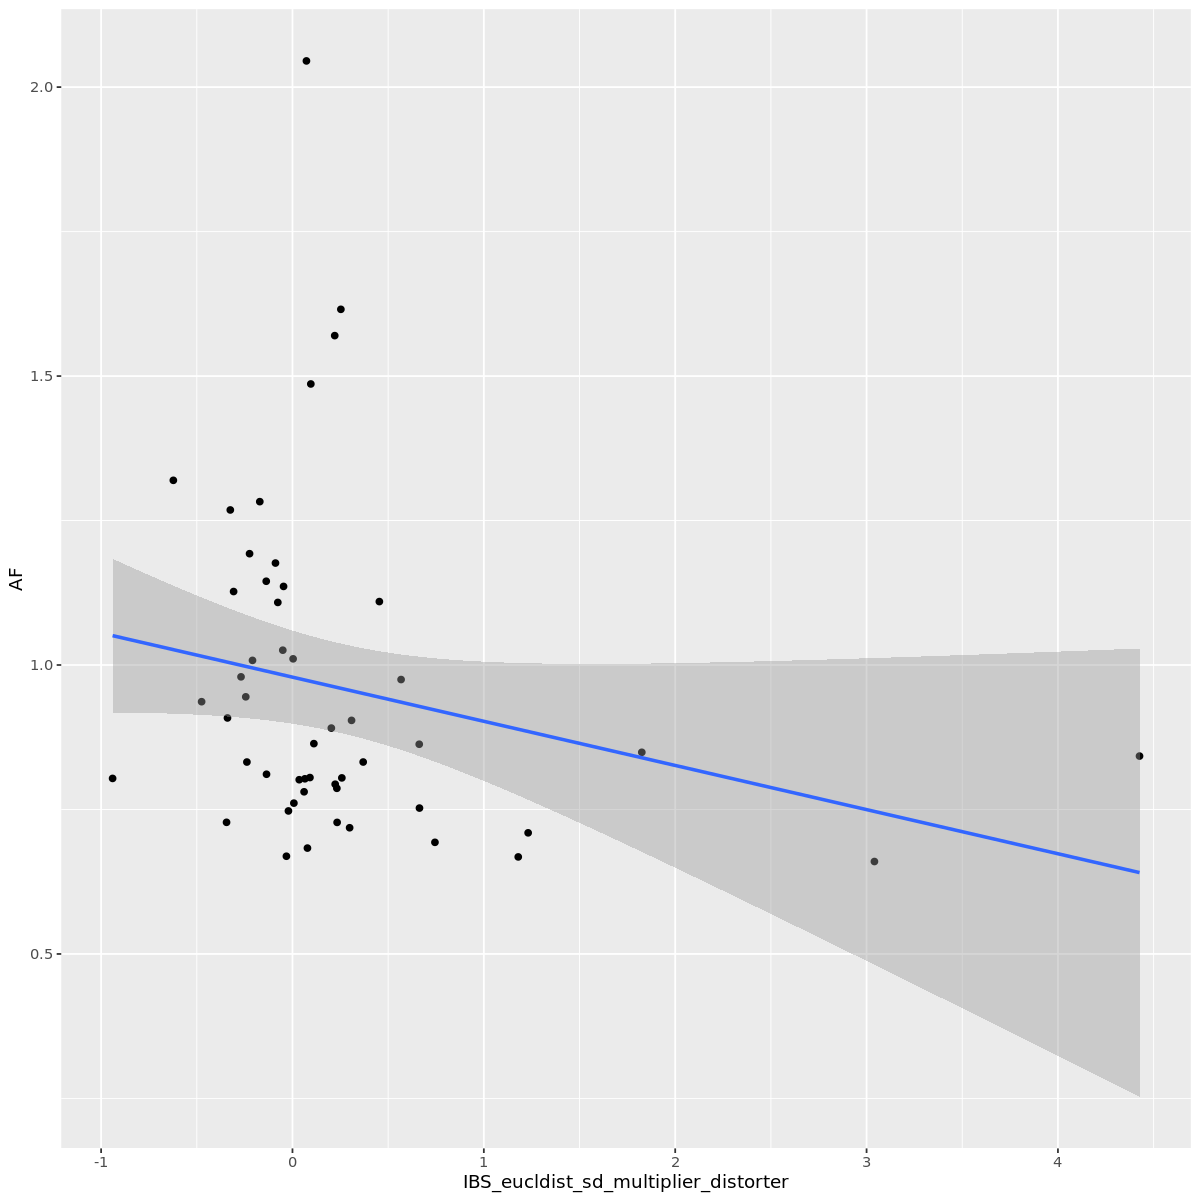

`geom_smooth()` using formula = 'y ~ x'


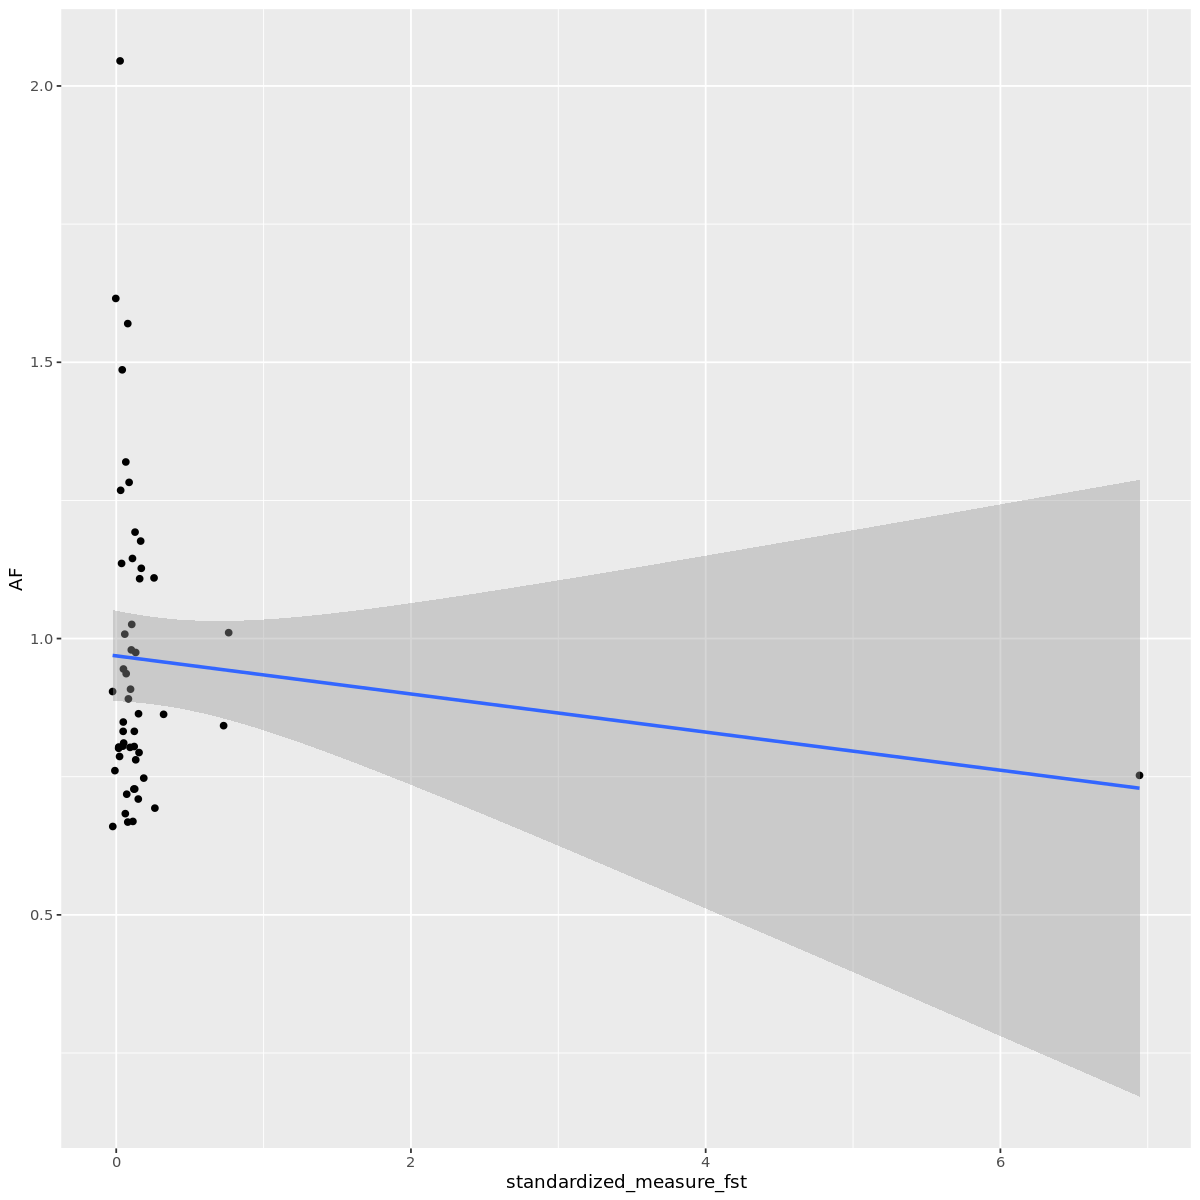

`geom_smooth()` using formula = 'y ~ x'


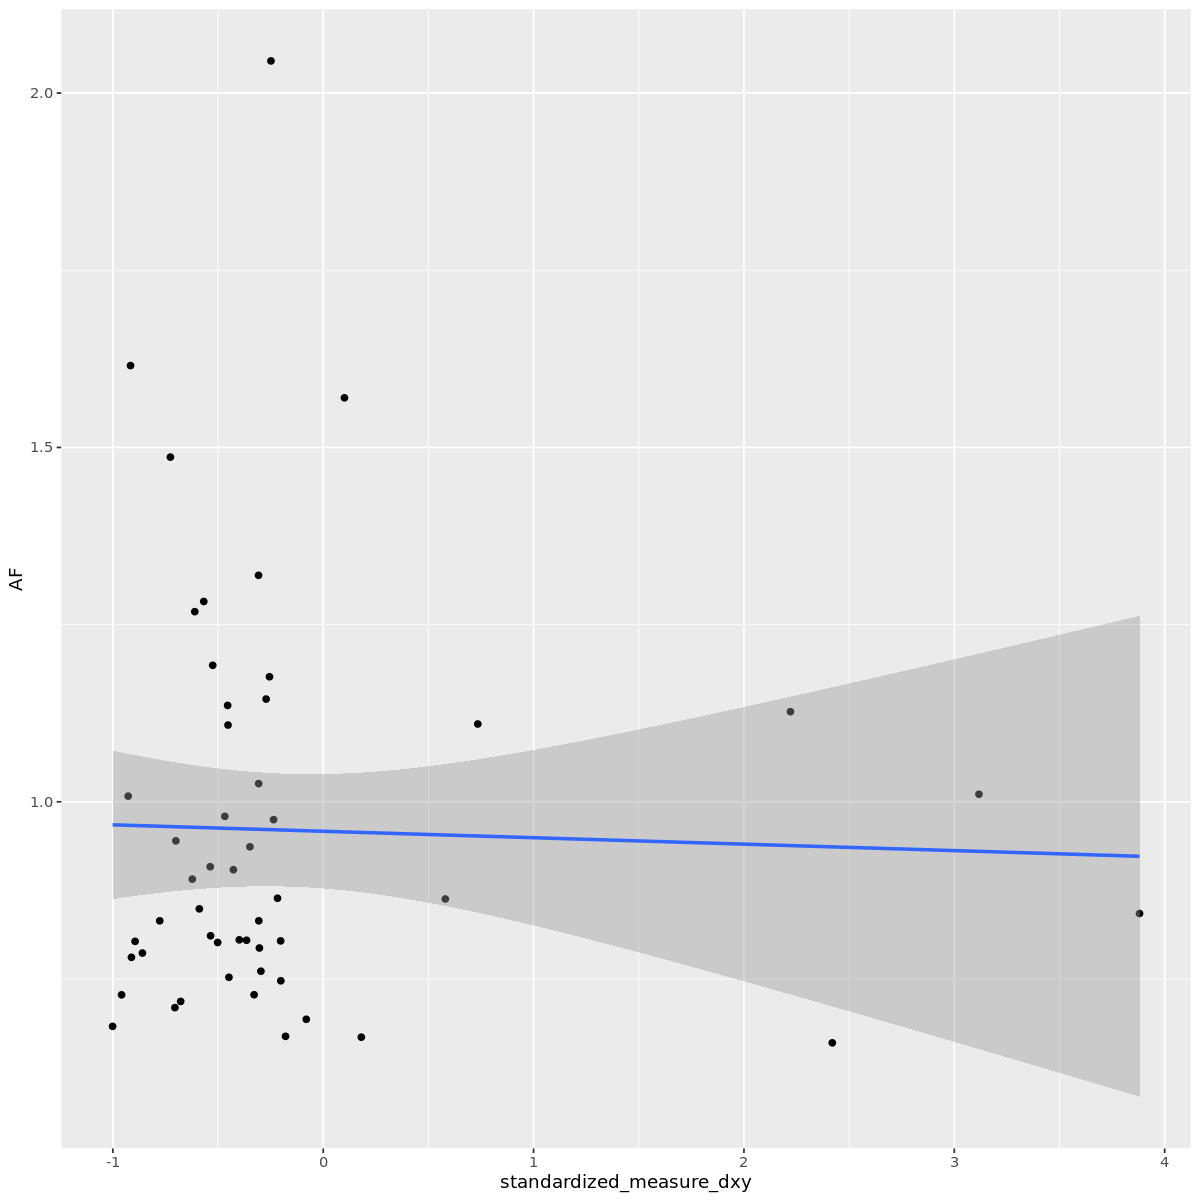

`geom_smooth()` using formula = 'y ~ x'


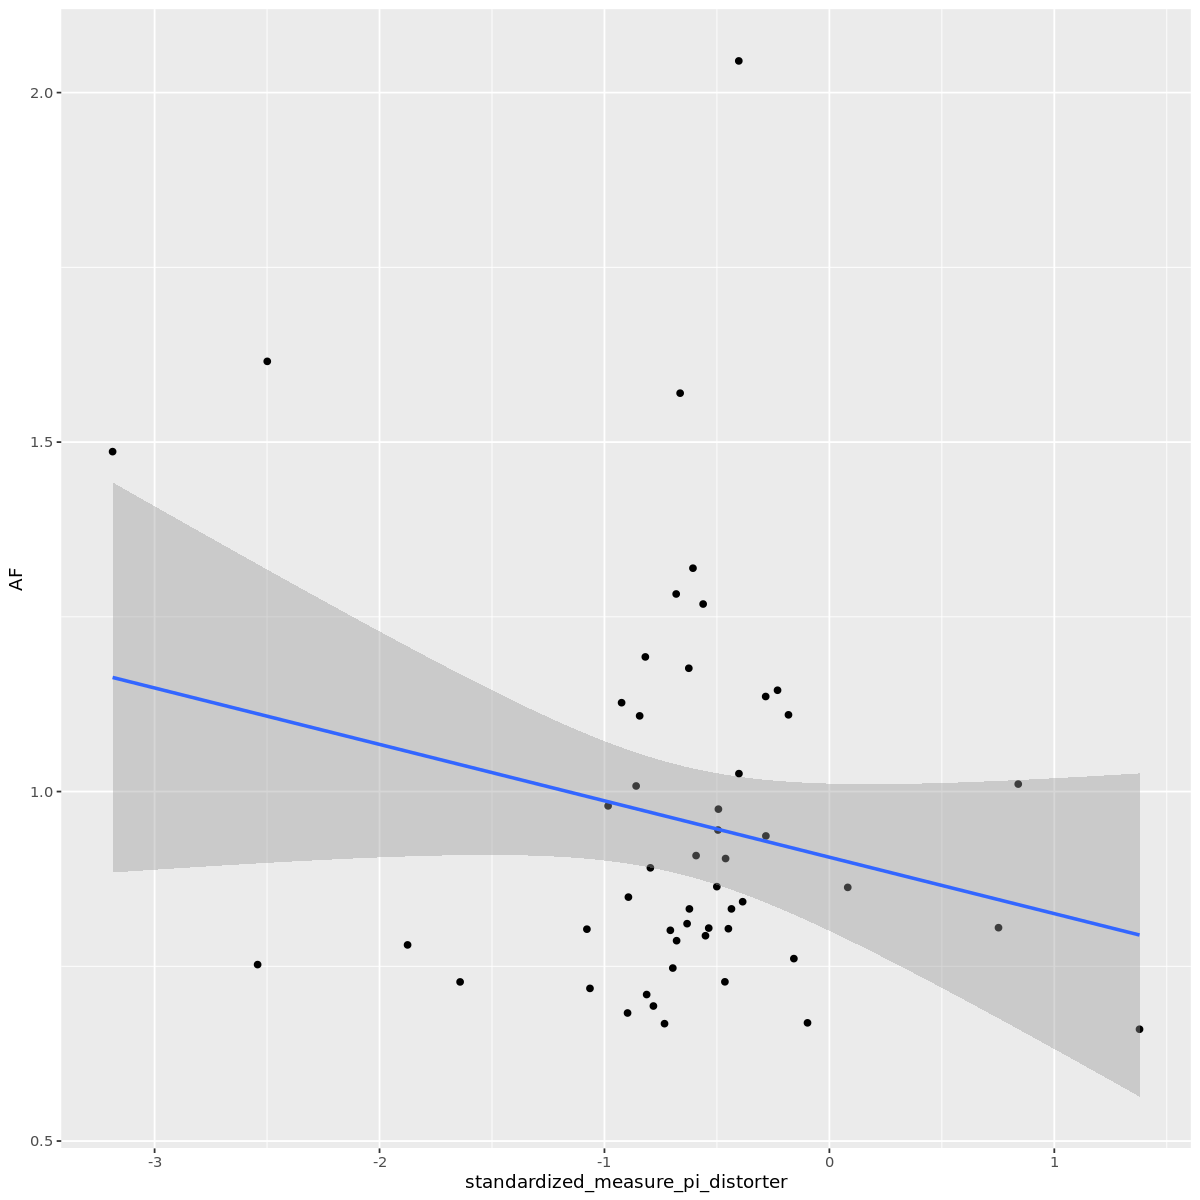

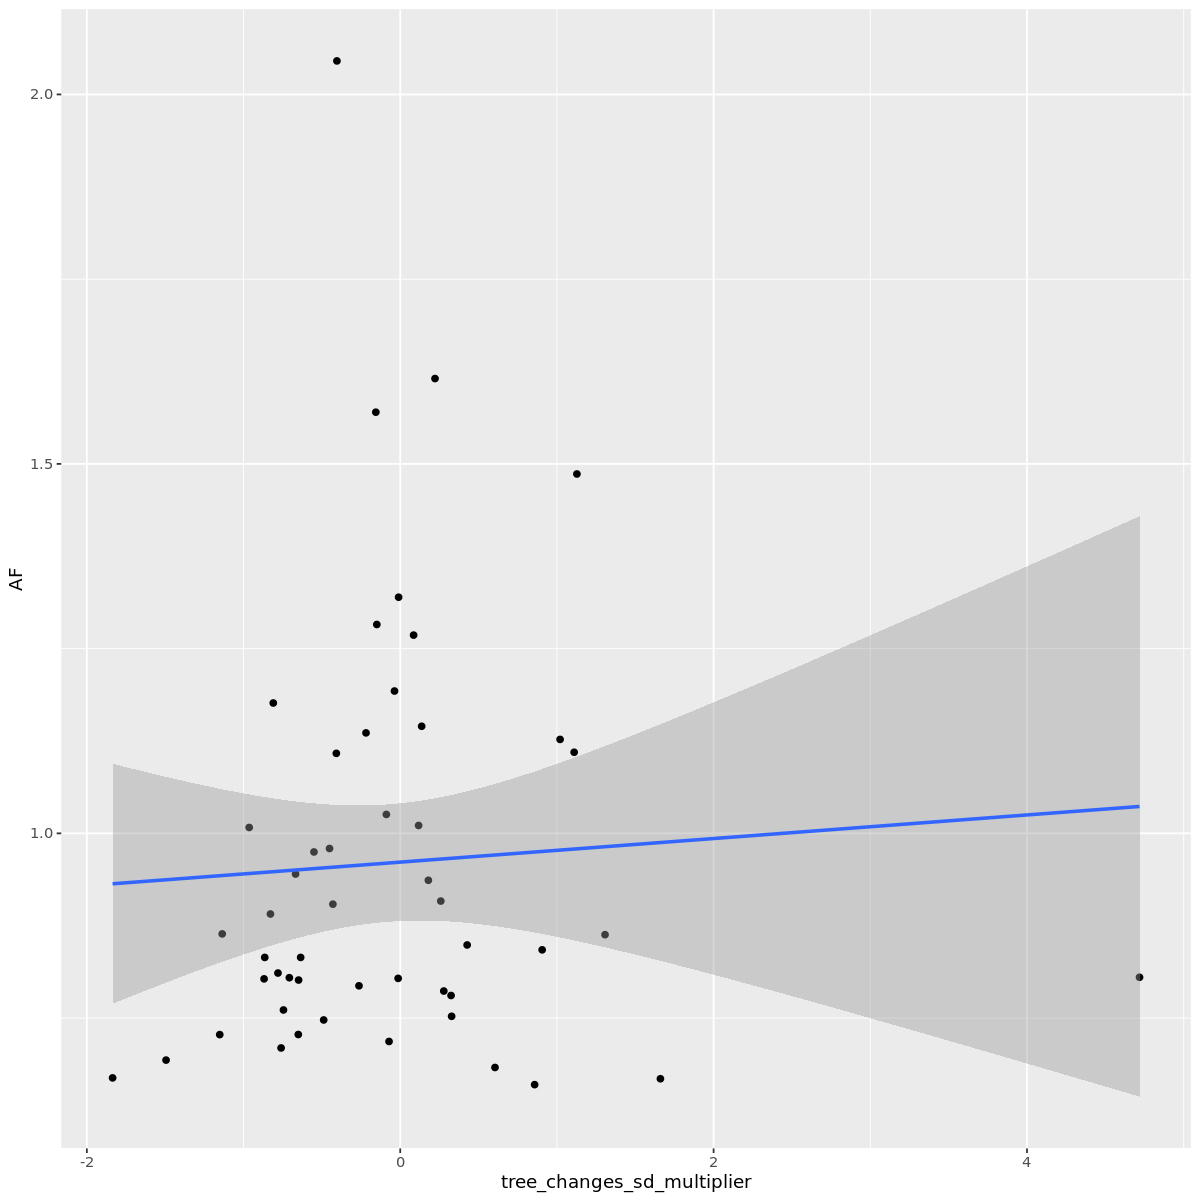

In [47]:
# no correlations with AF

ggplot(clustering_subset, aes(IBS_eucldist_sd_multiplier_distorter, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(standardized_measure_fst, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(standardized_measure_dxy, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(standardized_measure_pi_distorter, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(tree_changes_sd_multiplier, AF))+
geom_point()+geom_smooth(method="lm")

In [48]:
# grouping the TRD loci has not been a success

classify_values=function(x){
    # to group the TRD regions, I am classifying them by whether they are average or strong
    if(x >= 1){
        return("high")
    }
    if(x <= -1){
        return("weak")
    }
    return("average")
}
l_classify_values=function(x){
    return(unlist(lapply(x, classify_values)))
}

clustering_subset%>%
mutate_all(~ l_classify_values(.))%>%
group_by_all()%>%summarize(n=n())%>%arrange(-n)

head(clustering_subset_classified<-clustering_subset%>%
mutate_all(~ l_classify_values(.)))


# Function to compute co-occurrence
count_cooccurrence <- function(data, cols) {
  data %>%
    group_by(across(all_of(cols))) %>%
    summarise(count = n(), .groups = 'drop') %>%
    arrange(-count)
}

# Compute co-occurrence for all combinations of columns
results_list <- lapply(2:length(clustering_subset_classified), function(n) {
  combn(names(clustering_subset_classified), n, FUN = function(cols) {
    count_cooccurrence(clustering_subset_classified, cols)
  }, simplify = FALSE)
})

# Flatten the list of results
results <- do.call(c, results_list)

# Combine all results into a single tibble
cooccurrence_results <- bind_rows(results, .id = 'combination')

print(cooccurrence_results)


`summarise()` has grouped output by 'AF', 'IBS_eucldist_sd_multiplier_distorter', 'tree_changes_sd_multiplier', 'IBS_eucldist_sd_multiplier_other', 'standardized_measure_pi_distorter',
'standardized_measure_pi_other', 'standardized_measure_fst', 'standardized_measure_dxy', 'LD_sd_multi_2'. You can override using the `.groups` argument.


AF,IBS_eucldist_sd_multiplier_distorter,tree_changes_sd_multiplier,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi,n
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
average,average,average,average,average,average,average,average,weak,average,8
high,average,average,average,average,average,average,average,weak,average,6
high,average,average,average,average,average,average,average,average,average,5
average,average,average,average,average,average,average,average,average,average,4
average,average,average,average,average,weak,average,average,average,average,3
average,average,average,average,average,weak,average,average,weak,average,3
average,average,weak,average,average,average,average,average,weak,average,3
average,average,average,average,average,weak,average,weak,average,average,1
average,average,average,average,weak,average,average,average,average,average,1


AF,IBS_eucldist_sd_multiplier_distorter,tree_changes_sd_multiplier,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
average,average,average,average,average,average,average,average,weak,average
high,average,average,average,average,average,average,average,weak,average
average,average,average,average,average,average,average,average,weak,average
high,average,average,average,average,average,average,average,average,average
average,average,average,average,average,weak,average,average,weak,average
high,average,high,average,weak,high,average,average,average,average


# A tibble: 12,807 x 12
   combina~1 AF    IBS_e~2 count tree_~3 IBS_e~4 stand~5 stand~6 stand~7 stand~8
   <chr>     <chr> <chr>   <int> <chr>   <chr>   <chr>   <chr>   <chr>   <chr>  
 1 1         aver~ average    29 NA      NA      NA      NA      NA      NA     
 2 1         high  average    17 NA      NA      NA      NA      NA      NA     
 3 1         aver~ high        5 NA      NA      NA      NA      NA      NA     
 4 2         aver~ NA         27 average NA      NA      NA      NA      NA     
 5 2         high  NA         14 average NA      NA      NA      NA      NA     
 6 2         aver~ NA          4 weak    NA      NA      NA      NA      NA     
 7 2         aver~ NA          3 high    NA      NA      NA      NA      NA     
 8 2         high  NA          3 high    NA      NA      NA      NA      NA     
 9 3         aver~ NA         31 NA      average NA      NA      NA      NA     
10 3         high  NA         16 NA      average NA      NA      NA      NA     
# ..

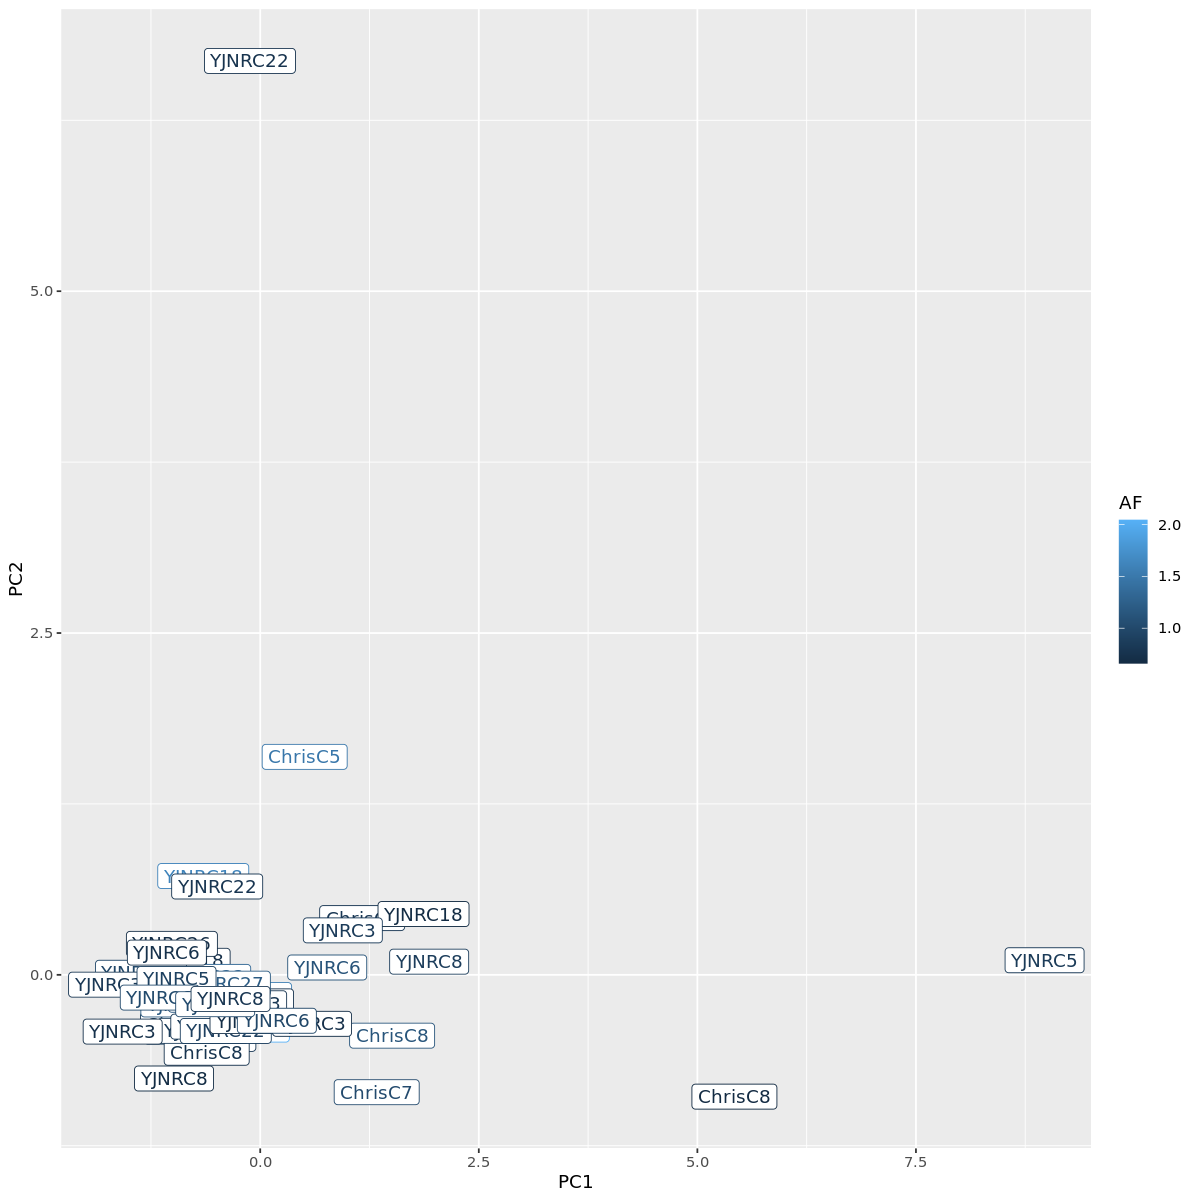

In [49]:
# also PCA is not all that helpful, but maybe the outliers can be pointed out

pca_df<-bind_cols(clustering_subset,as.data.frame(prcomp(select(clustering_subset, -AF))$x))
pca_df<-bind_cols(pca_df, data.table(row=OneTable_rows_in_clustering_subset))
pca_df<-left_join(pca_df, mutate(One_Table, row=row_number())%>%select(cross,ID,row), by="row")
ggplot(pca_df,
      aes(PC1,PC2,color=AF))+
geom_point()+geom_label(mapping=aes(label=cross))

In [50]:
saveRDS(pca_df, "~/data/trd/genomic_signals_pca.RDS")

In [51]:
cluster_transposed<-t(as.data.frame(select(clustering_subset, -AF)))
colnames(cluster_transposed)<-1:ncol(cluster_transposed)

Warning message:
"package 'PCAtools' was built under R version 4.1.3"
Loading required package: ggrepel

Warning message:
"package 'ggrepel' was built under R version 4.1.3"

Attaching package: 'PCAtools'


The following objects are masked from 'package:stats':

    biplot, screeplot


Warning message:
"Removed 5 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 5 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_label_repel()`)."


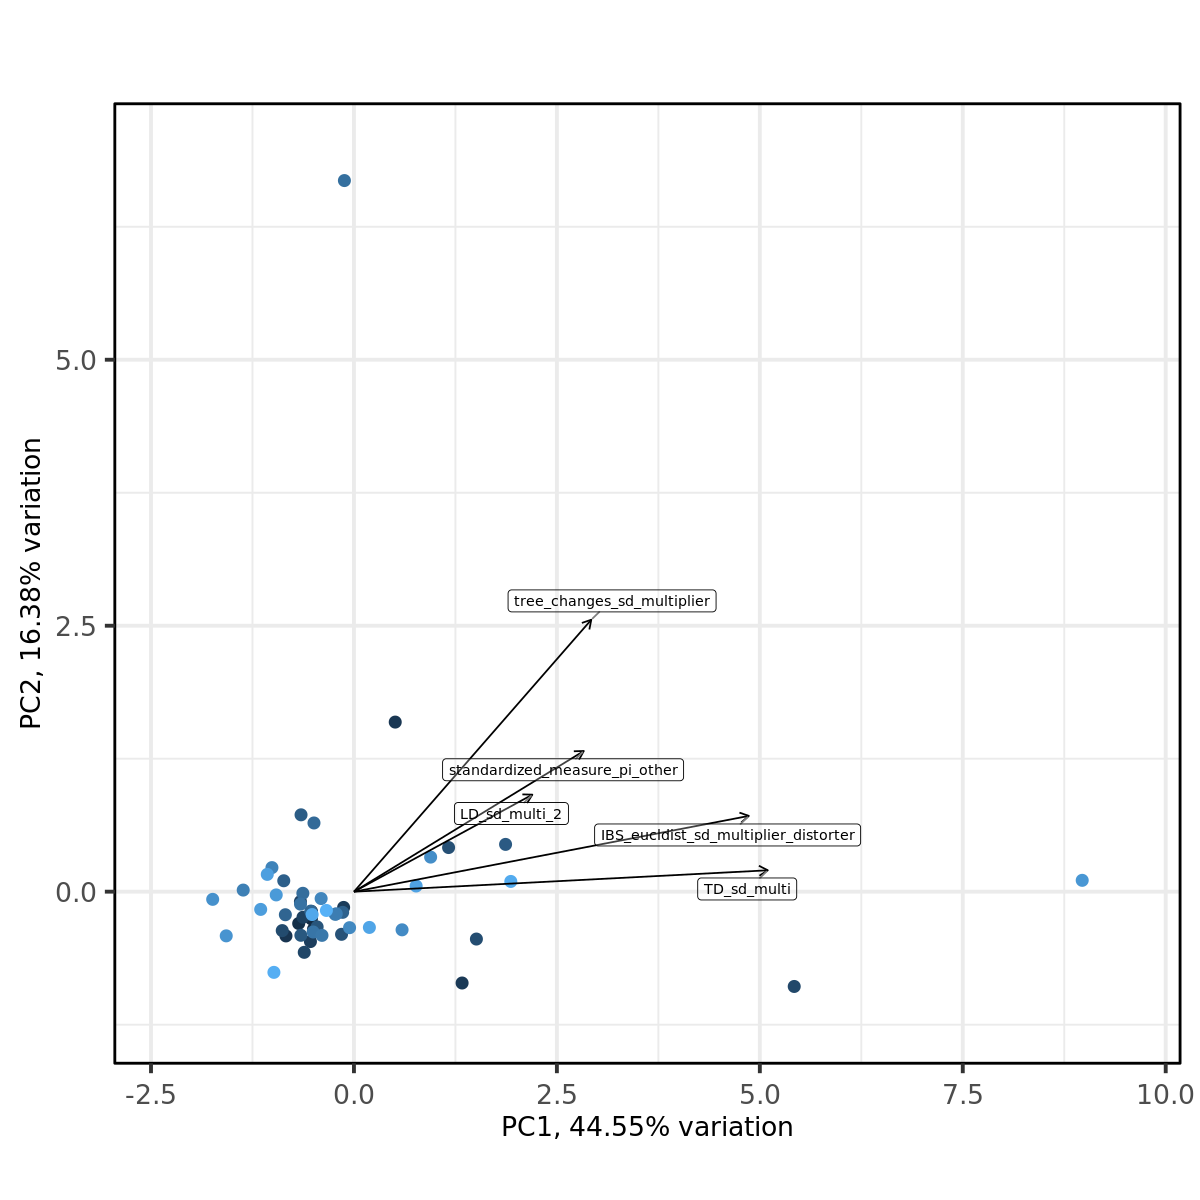

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_label_repel()`)."


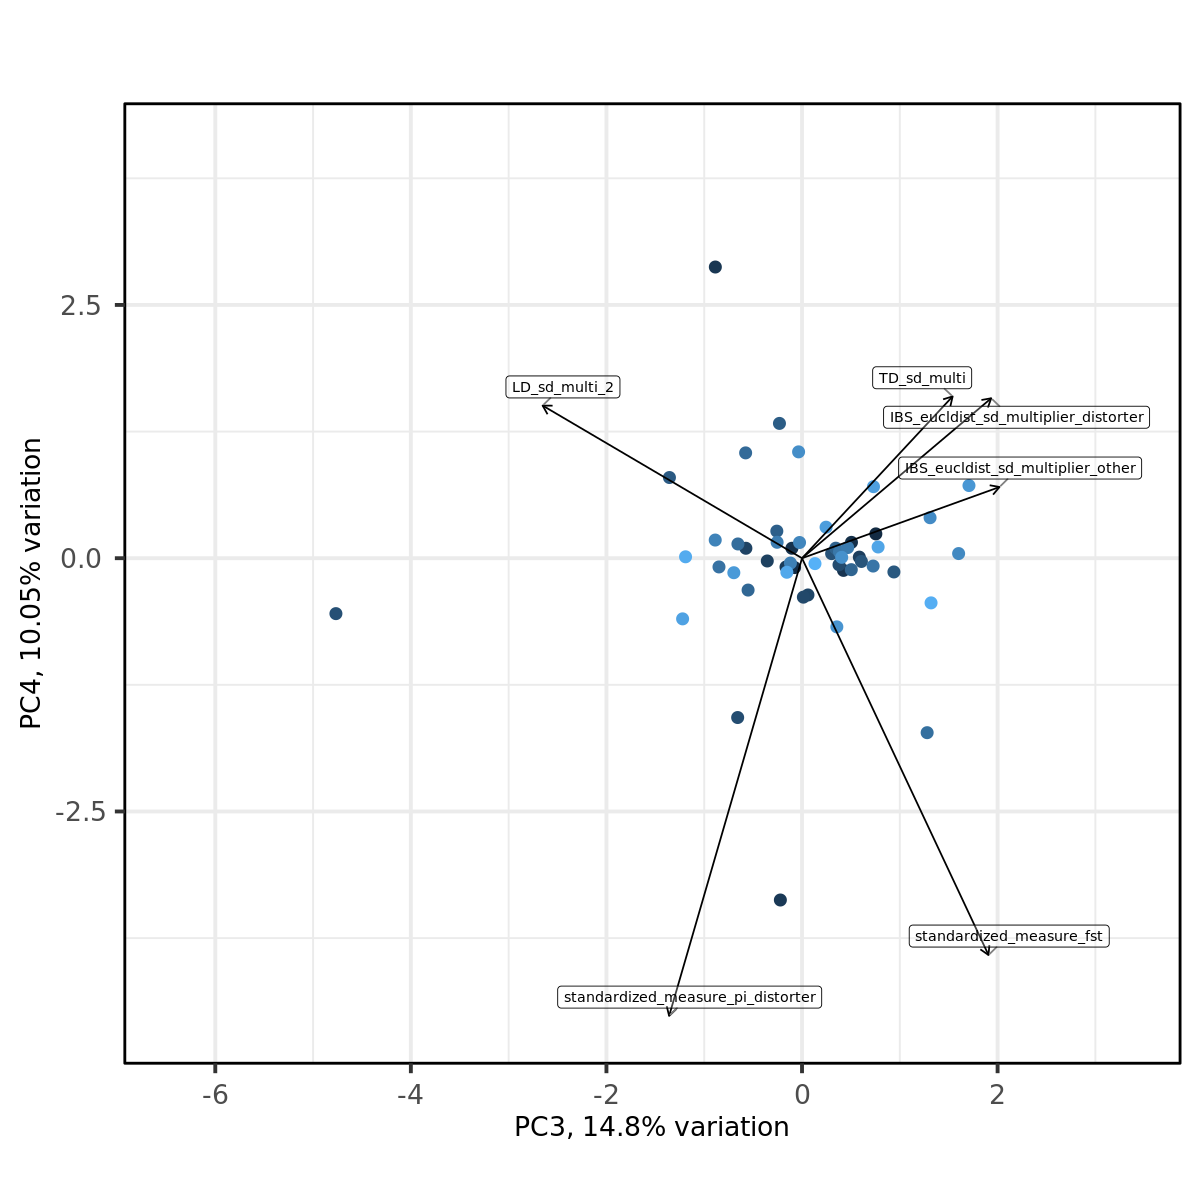

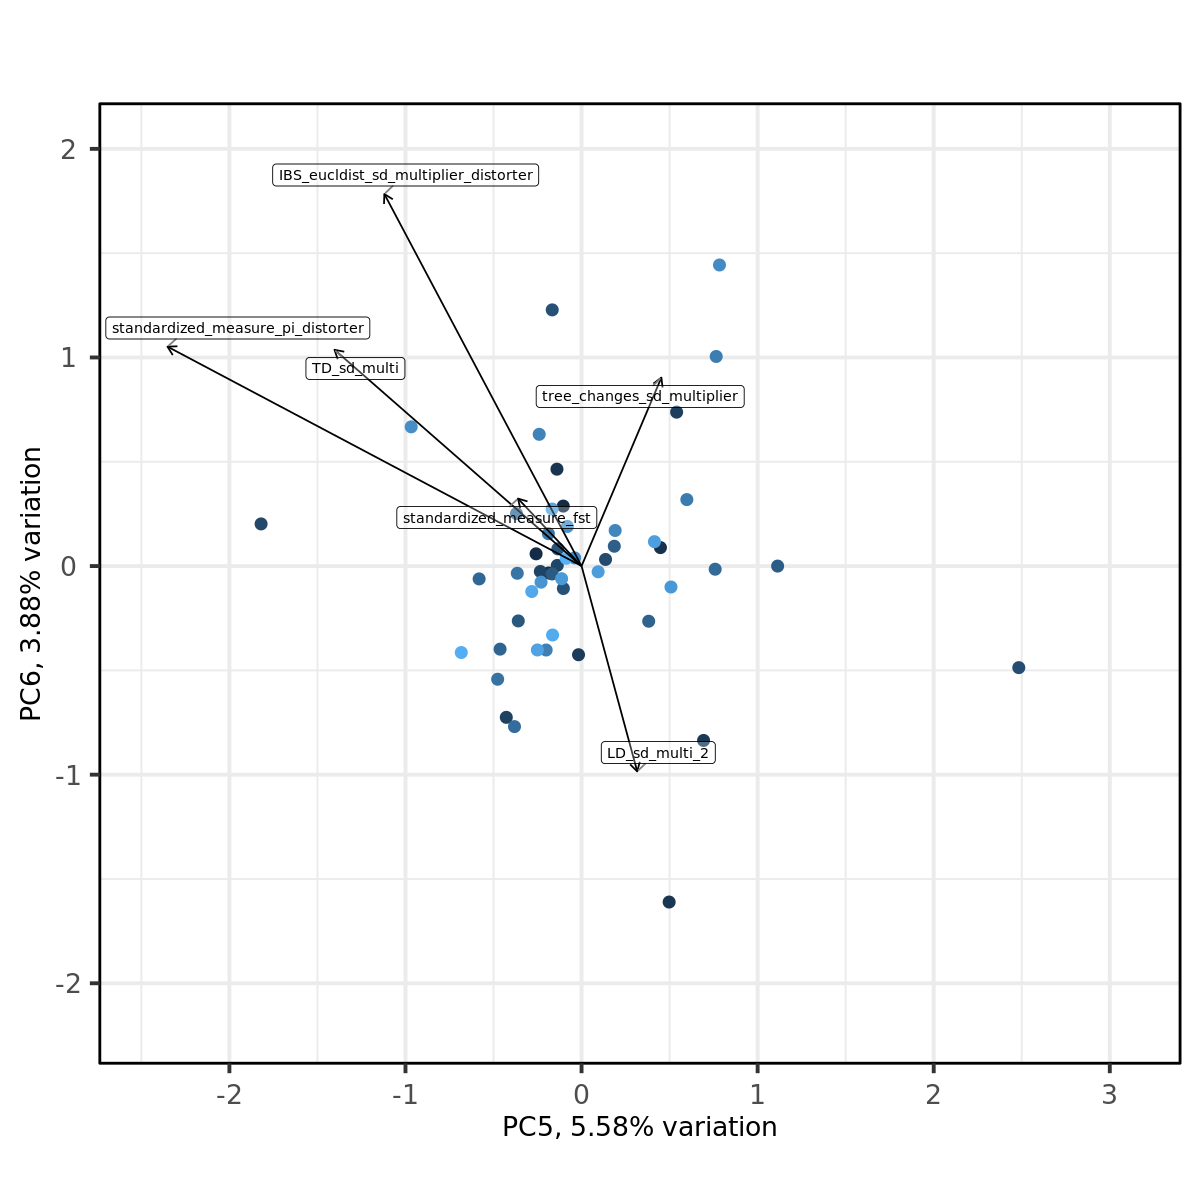

In [52]:
library(PCAtools)
#metadata<-data.frame(row.names = colnames(cluster_transposed), AF=pull(clustering_subset, AF))
p <- pca(cluster_transposed)
biplot(p, showLoadings = TRUE, lab = NULL, showLoadingsNames=TRUE, ntopLoadings=10)
biplot(p, "PC3", "PC4", showLoadings = TRUE, lab = NULL, showLoadingsNames=TRUE, ntopLoadings=10)
biplot(p, "PC5", "PC6", showLoadings = TRUE, lab = NULL, showLoadingsNames=TRUE, ntopLoadings=10)


In [53]:
# GO terms

library(rrvgo)

GO_files<-list.files("/home/jnrunge/data/trd/GO_data", full.names = TRUE, pattern="GOdata.RDS$")
# filter for TRD signals filtering
GO_files<-GO_files[basename(GO_files)%in%paste0(pull(One_Table,cross),".",pull(One_Table, ID),".GOdata.RDS")]


if(!file.exists("overall_reducedTerms2.RDS") || file.mtime("overall_reducedTerms2.RDS")<max(file.mtime(GO_files))){
    


# across all samples, I am aggregating all data on "over-represented" (by simple division) GO terms across samples, summarize the frequencies, and then test again against the global distribution.

GO_terms<-bind_rows(lapply(GO_files, readRDS))%>%group_by(GO, Freq, Other)%>%summarize(Freq_TRD=sum(Freq_location),
                                                               Other_TRD=sum(Other_location))%>%arrange(GO)%>%ungroup()
GO_terms<-filter(GO_terms,(Freq_TRD/Other_TRD) > (Freq/Other))
nrow(GO_terms)

GO_terms<-mutate(GO_terms, pChisq=NA)

for(i in 1:nrow(GO_terms)){
        col1<-slice(GO_terms, i)%>%select(Freq_TRD,Other_TRD)%>%t()
        col2<-slice(GO_terms, i)%>%select(Freq,Other)%>%t()
        colnames(col1)<-"col1"
        colnames(col2)<-"col2"
        cols<-bind_cols(col1,col2)
        p_chi<-chisq.test(cols, simulate.p.value = TRUE, B = round((1/(0.05/nrow(GO_terms)))*2))$p.value # 2x as many replicates as would be needed to reach corrected significance if possible
        GO_terms<-mutate(GO_terms, pChisq=ifelse(row_number()==i,
                                                p_chi,
                                                pChisq))
    }


    GO_terms_enriched<-filter(GO_terms, pChisq<(0.05/nrow(GO_terms)))
    
    GO_terms

    simMatrix <- calculateSimMatrix(pull(GO_terms_enriched, GO),
                                    orgdb="org.Sc.sgd.db", # yeast Sc 
                                    ont="BP", # biological processes; could also use CC or MF
                                    method="Rel")
    
    simMatrix2 <- calculateSimMatrix(pull(GO_terms, GO),
                                    orgdb="org.Sc.sgd.db", # yeast Sc 
                                    ont="BP", # biological processes; could also use CC or MF
                                    method="Rel")

    scores <- setNames(-log10(pull(GO_terms_enriched, pChisq)), pull(GO_terms_enriched, GO))
    scores2 <- setNames(-log10(pull(GO_terms, pChisq)), pull(GO_terms, GO))
    reducedTerms <- reduceSimMatrix(simMatrix,
                                    scores,
                                    threshold=0.7,
                                    orgdb="org.Sc.sgd.db")
    
    reducedTerms2 <- reduceSimMatrix(simMatrix2,
                                    scores2,
                                    threshold=0.7,
                                    orgdb="org.Sc.sgd.db")




saveRDS(reducedTerms, "overall_reducedTerms.RDS")
saveRDS(reducedTerms2, "overall_reducedTerms2.RDS")
}else{
    reducedTerms<-readRDS("overall_reducedTerms.RDS")
    reducedTerms2<-readRDS("overall_reducedTerms2.RDS")
}

Warning message in wordcloud::wordcloud(d$word, d$freq, ...):
"transcription could not be fit on page. It will not be plotted."


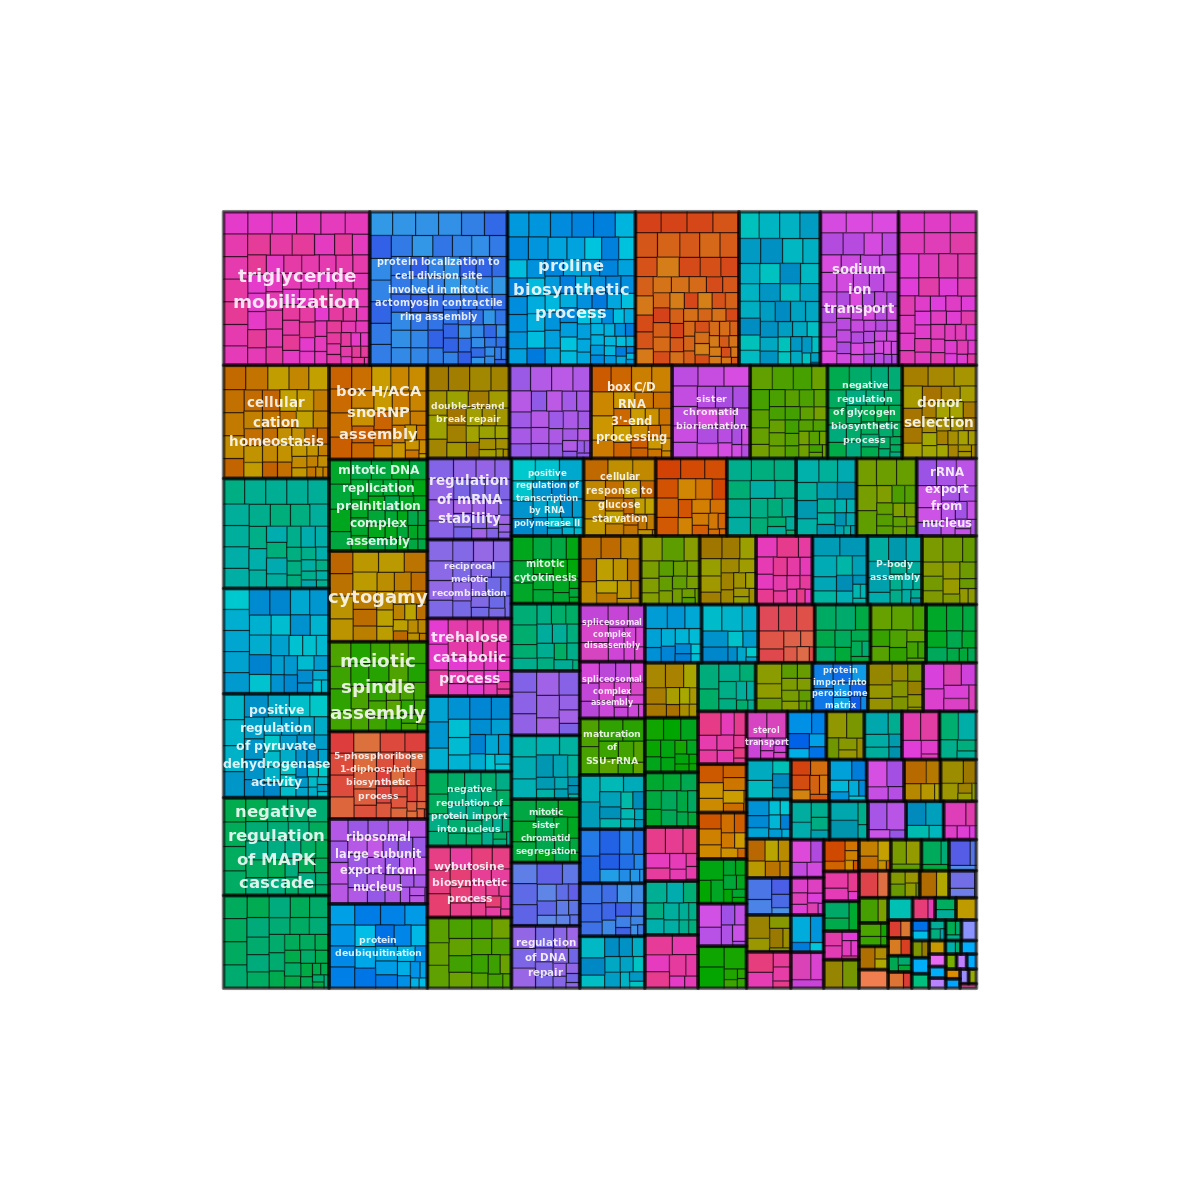

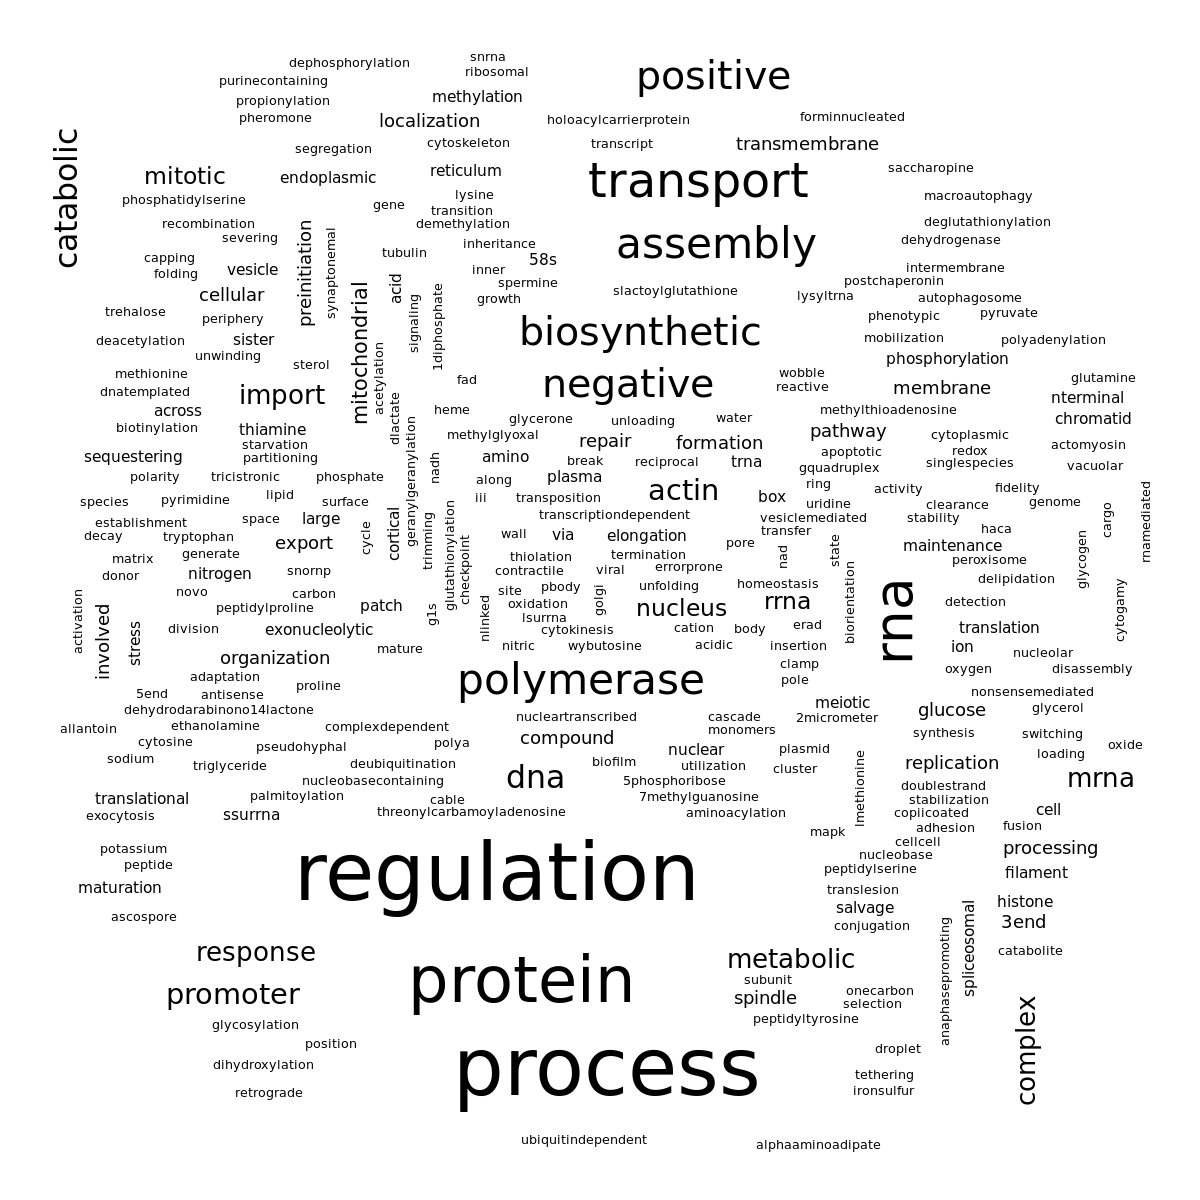

In [54]:

treemapPlot(reducedTerms2)
wordcloudPlot(reducedTerms2, min.freq=1, colors="black")

Warning message in wordcloud::wordcloud(d$word, d$freq, ...):
"polyadenylationdependent could not be fit on page. It will not be plotted."


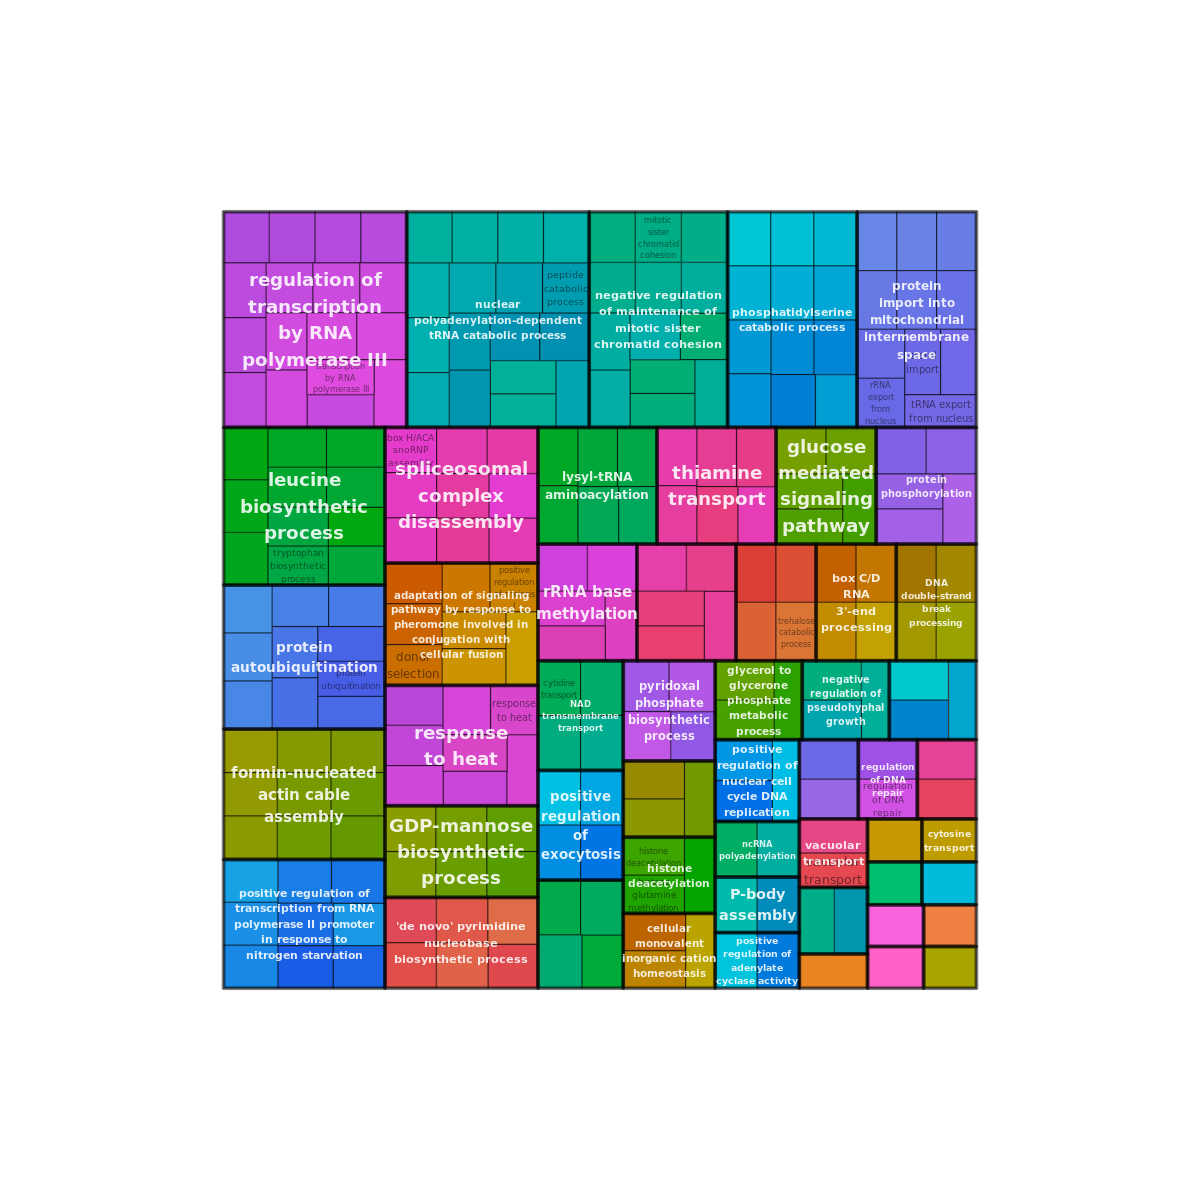

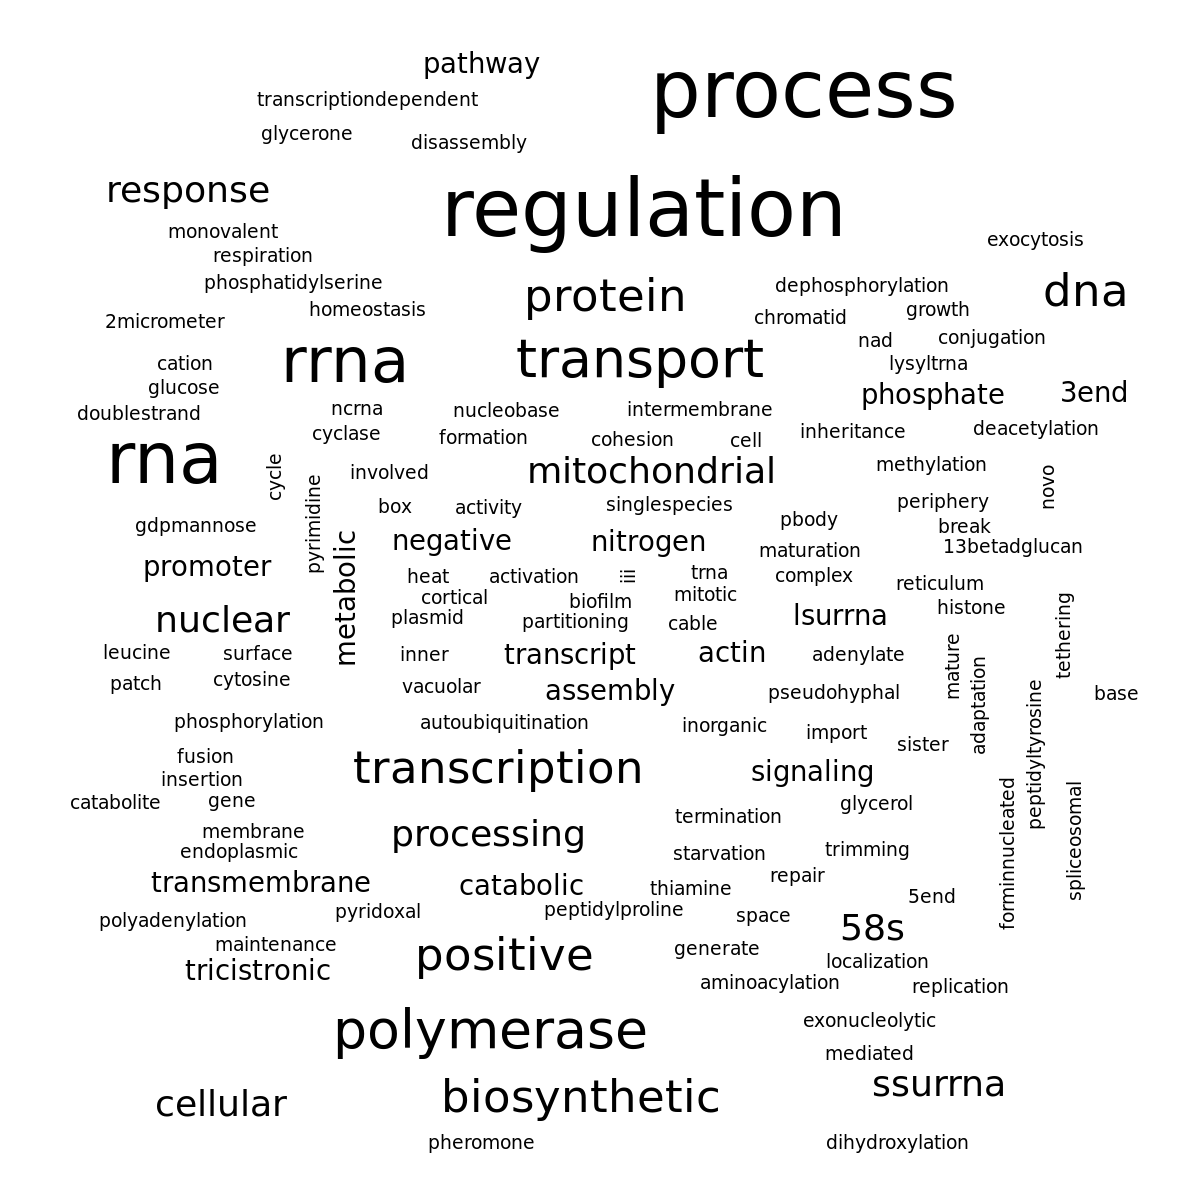

In [55]:

treemapPlot(reducedTerms)
wordcloudPlot(reducedTerms, min.freq=1, colors="black")

In [56]:
One_Table<-filter(One_Table, !is.na(lengthBp))

In [57]:
# missing values

missing_overview <- One_Table %>%
  group_by(cross) %>%
  summarise(across(everything(), ~sum(is.na(.x)), .names = "missing_in_{.col}"))

missing_long <- missing_overview %>%
  tidyr::gather(column, missing_count, -cross)
missing_ordered <- missing_long %>% group_by(column)%>%summarize(missing_count=sum(missing_count))%>%
  filter(missing_count > 0) %>%
  arrange(desc(missing_count))
missing_ordered %>%
  rowwise() %>%
  mutate(description = paste("Column", column, "is missing in", missing_count, "regions.")) %>%
  pull(description) %>%
  print()


 [1] "Column missing_in_CONTR is missing in 1 regions."                            
 [2] "Column missing_in_DEL is missing in 1 regions."                              
 [3] "Column missing_in_DUP is missing in 1 regions."                              
 [4] "Column missing_in_INS is missing in 1 regions."                              
 [5] "Column missing_in_INV is missing in 1 regions."                              
 [6] "Column missing_in_TRA is missing in 1 regions."                              
 [7] "Column missing_in_ecdf_value_dxy is missing in 1 regions."                   
 [8] "Column missing_in_ecdf_value_fst is missing in 1 regions."                   
 [9] "Column missing_in_ecdf_value_pi_distorter is missing in 1 regions."          
[10] "Column missing_in_ecdf_value_pi_other is missing in 1 regions."              
[11] "Column missing_in_standardized_measure_dxy is missing in 1 regions."         
[12] "Column missing_in_standardized_measure_fst is missing in 1 regions."  

In [58]:
filter(One_Table, is.na(sum_value_pi_distorter))

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,...,TD_sd_multi,TD_ecdf,PCA_eucldist_sd_multiplier_distorter,PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_other,PCA_eucldist_quantile_distorter,PCA_eucldist_quantile_other,IBS_eucldist_quantile_distorter,IBS_eucldist_quantile_other
<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,142,chromosome4,1832928,1892912,59984,YJNRC17,487542,547526,0.982575,...,3.850202,0.9929402,4.114667,2.775308,5.845453,4.884182,4.114667,2.775308,5.845453,4.884182


In [59]:
fwrite(One_Table, "03_OneTable.csv.gz")

In [60]:
SV_data_org<-SV_data

In [65]:
 # the render function seems to overwrite variables...
for(cross_render in select(One_Table, cross)%>%distinct()%>%pull(cross))
    {
    #if(nrow(filter(SV_data_org, cross==cross_render))==0){
    #    next
    #}
    cross<-cross_render
    print(cross_render)
    rmarkdown::render("03_RegionReportTemplate.Rmd", params = 
                  list(cross=cross),
                  output_file = paste0("~/TRD/03_GenomicSignals/PDF_reports/",cross, '.HTML'), 
                 )
}



[1] "ChrisC1"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML



[1] "ChrisC3"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC3.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC3.HTML



[1] "ChrisC5"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC5.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC5.HTML



[1] "ChrisC7"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC7.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC7.HTML



[1] "ChrisC8"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC8.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC8.HTML



[1] "YJNRC14"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC14.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC14.HTML



[1] "YJNRC15"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC15.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC15.HTML



[1] "YJNRC17"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC17.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC17.HTML



[1] "YJNRC18"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC18.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC18.HTML



[1] "YJNRC19"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC19.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC19.HTML



[1] "YJNRC21"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC21.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC21.HTML



[1] "YJNRC22"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC22.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC22.HTML



[1] "YJNRC23"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC23.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC23.HTML



[1] "YJNRC25"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC25.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC25.HTML



[1] "YJNRC26"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC26.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC26.HTML



[1] "YJNRC27"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC27.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC27.HTML



[1] "YJNRC3"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC3.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highlig


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC3.HTML



[1] "YJNRC5"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC5.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highlig


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC5.HTML



[1] "YJNRC6"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC6.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highlig


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC6.HTML



[1] "YJNRC7"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC7.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highlig


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC7.HTML



[1] "YJNRC8"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC8.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highlig


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC8.HTML

